# Imports and Data

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import os
import matplotlib.pyplot as plt
import phonecalls as pc
import scipy.stats as stats
import scipy.interpolate as interpol
import time
import copy
import math
import pickle


plt.rcParams['figure.figsize'] = (20, 10)
markers = ['o', 'v', 's', 'P', '*', 'X', 'd', 'x', 'D', '2', '+']
colors = ['#348ABD', '#A60628', '#7A68A6', '#467821', '#D55E00', '#CC79A7', '#56B4E9', '#009E73', '#F0E442', '#0072B2']

with open('unfiltered.pkl', 'rb') as handle:
    unfiltered = pickle.load(handle)
handle.close()

with open('filtered.pkl', 'rb') as handle:
    filtered = pickle.load(handle)
handle.close()

with open('filterednc.pkl', 'rb') as handle:
    filterednc = pickle.load(handle)
handle.close()

import statsmodels.api as sm

globalt0 = dt.datetime.now()

# Edit main paper results

There is an inconsistency between the reported results and the results of the current version of the paper. Since lifetimes for each alter were limited to $\mathcal{T}$, whenever an alter reaches lifetime $\ell >= \mathcal{T}$, its lifetime is truncated to $\mathcal{T}$. This generates an over representation of alters with $\ell = \mathcal{T}$. The fix is simple: I will only consider alters with $\ell < \mathcal{T}$.

In [2]:
calls = {}
for c in ['uk', 'uk2', 'mit']:
#     df = unfiltered[c].copy(deep=True)
#     df['ea'] = list(zip(df['ego'], df['alter']))
#     ncalls = df.groupby('ea')[['time']].count()
#     ncalls = ncalls.loc[ncalls['time'] > 2]
#     df = df[df['ea'].isin(ncalls.index)]
#     df = df.drop(columns=['ea'])
    calls[c] = pc.limit_calls(unfiltered[c], 231)

## Fig 2

In [3]:
alldff = {}
for c in calls.keys():
    alldff[c] = pc.get_f(calls[c], 'all', 15, 67)
    
with open('../itdata/mtl_fig2.pickle', 'rb') as handle:
    alldff['it'] = pickle.load(handle)
    handle.close()

FileNotFoundError: [Errno 2] No such file or directory: '../itdata/mtl_fig2.pickle'

In [ ]:
lives = {}
for c in calls.keys():
    lives[c] = pc.lives_dictionary(calls[c])
    
with open('../itdata/mtl_lives.pickle', 'rb') as handle:
    lives['it'] = pickle.load(handle)
    handle.close()

In [ ]:
limits = {}
limits[0] = (0, 50)
limits[1] = (100, 150)
limits[2] = (180, 230)

stablec = {}
for c in ['uk', 'uk2', 'it', 'mit']:
    stablec[c] = {}
    for i in limits.keys():
        stablec[c][i] = pc.get_avgfa(alldff[c], lives[c], limits[i][0], limits[i][1])

In [ ]:
lines = {}
lines[0] = (1, 3)
lines[1] = (1, 8)
lines[2] = (2, 12)
dashed = {}

for c in ['uk', 'uk2', 'it', 'mit']:
    dashed[c] = {}
    print(f'======================={c}=====================')
    for l in stablec[c].keys():
        df = stablec[c][l].loc[(stablec[c][l].index >= lines[l][0]) & (stablec[c][l].index <= lines[l][1])]
        h = np.mean(df['f'])
        dashed[c][l] = ([lines[l][0], lines[l][1]], [h, h])
        print(f'\draw[dashed, {["charmander", "squirtle", "ekans"][int(l)]}, ultra thick] (axis cs: {lines[l][0]}, {h}) -- (axis cs: {lines[l][1]}, {h});')

In [ ]:
plt.figure(figsize=(20, 40))
p = 1
labels = [fr'${limits[i][0]} \leq \ell \leq {limits[i][1]}$' for i in range(3)]
labels.append(r'$\ell >= 199$')
cohorts = ['UK', 'UK2', 'Italy', 'USA']
for c in ['uk', 'uk2', 'it', 'mit']:
    plt.subplot(4,1,p)
    plt.xlabel(f"Lapse in cohort {cohorts[p - 1]}")
    plt.ylabel(r"$\bar{f}$")
    plt.xticks(range(0, 201, 15))
    for lamb in stablec[c].keys():
        l = int(lamb)
        plt.plot([15 * x for x in stablec[c][l].index], stablec[c][l]['f'], marker=markers[l], ls="-", lw=5, markersize=15, label=labels[l])
        plt.plot([15 * x for x in dashed[c][l][0]], dashed[c][l][1], marker="", ls="--", lw=3, c=colors[l])
    plt.legend()
    p += 1

In [ ]:
# for c in stablec.keys():
#     tmp = pd.DataFrame()
#     for l in stablec[c].keys():
#         df = stablec[c][l]
#         df.columns = [f'l{int(l)}']
#         if len(tmp) == 0:
#             tmp = tmp.append(df)
#         else:
#             tmp = tmp.merge(df, left_index=True, right_index=True, how='outer')
#     tmp.index.rename('a', inplace=True)
#     tmp.fillna('nan', inplace=True)
#     tmp = tmp.loc[tmp.index < 13]
#     tmp.to_csv(f"../commpatterns/PNAS_paper/figs/fig2d_{c}.dat", header=True, sep="\t")

## fig 3

In [ ]:
tmp = {}
for c in calls.keys():
    tmp[c] = pc.get_f(calls[c], 'all', 30, 10)
    
with open('../itdata/mtl_fig3.pickle', 'rb') as handle:
    tmp['it'] = pickle.load(handle)
    handle.close()
    
alldff2 = {}
for c in ['uk', 'uk2', 'it', 'mit']:
    alldff2[c] = {}
    nump = 0
    nump2 = 0
    for ego in tmp[c].keys():
        alldff2[c][ego] = {}
        for alter in tmp[c][ego].keys():
            ell = lives[c][ego][alter]['ell']
            nump += 1
            if ell < 201:
                alldff2[c][ego][alter] = tmp[c][ego][alter]
                nump2 += 1
    print(c, nump, nump2)

In [ ]:
alldff2['all'] = {}
for c in ['uk', 'mit', 'it']:
    alldff2['all'].update(alldff2[c])
    
len(alldff2['all']) == len(alldff2['uk']) + len(alldff2['mit']) + len(alldff2['it'])

In [ ]:
survall = pc.get_survival(alldff2['all'])

In [ ]:
plt.figure(figsize=(16,9))
plt.xlabel(f"Lifetime ")
plt.ylabel("Survival Probability")
plt.xticks(range(0, 200, 10))
df = survall
for gamma in range(4):
    plt.plot([10 * x for x in df[gamma].index], df[gamma][0], marker=markers[gamma], markersize=13, ls="--", lw=3, label=fr'$\gamma = {gamma}$')
plt.legend()

In [ ]:
# tmp = pd.DataFrame({'lc': list(survall[0].index)})
# for s in range(5):
#     df = survall[s]
#     tmp[f'p{int(s)}'] = df[0]
# tmp.to_csv(f'../commpatterns/PNAS_paper/figs/allsurvivalb.dat', header=True, index=False, sep="\t")

## Fig 4

In [ ]:
dffUM = {}
for c in ['uk', 'mit']:
    dffUM.update(alldff2[c])
    
surv_cont = pc.get_survival(dffUM)

In [ ]:
# tmp = pd.DataFrame()
# for s in range(6):
#     df = surv_cont[s].reset_index()
#     df.columns = ['lc', 'p']
#     df['lc'] *= 10
#     df['f'] = 2**s
#     ttmmpp = pd.DataFrame({'x': df['f'], 'y': df['lc'], 'z': df['p']})
#     tmp = tmp.append(ttmmpp).reset_index(drop=True)
# tmp.to_csv(f"../commpatterns/PNAS_paper/figs/contour.dat", header=False, index=False, sep="\t")

In [ ]:
points_it = pc.get_survival(alldff2['it'], unbinned=True)

# tmp = pd.DataFrame()
# for s in points_it.keys():
#     if s <= 2**5 + 1:
#         df = points_it[s].reset_index()
#         df.columns = ['lc', 'p']
#         df['lc'] *= 10
#         df['f'] = s
#         ttmmpp = pd.DataFrame({'x': df['f'], 'y': df['lc'], 'z': df['p']})
#         tmp = tmp.append(ttmmpp).reset_index(drop=True)
# sub = [(i/4, (i + 1)/4) for i in range(4)]
# p = 0
# for s in sub:
#     df = tmp.loc[(tmp['z'] > s[0]) & (tmp['z'] <= s[1])]
#     df = df.drop(columns='z')
#     df.to_csv(f'../commpatterns/PNAS_paper/figs/points{p}.dat', header=False, index=False, sep="\t")
#     print(s)
#     p += 1

# SI (revised)

I need to produce a version of the calls dataframe that I will be able to modify tfor the different variants included in the SI.

## Different values of $\Delta a$.

In [ ]:
limits = {}
limits[0] = (0, 66)
limits[1] = (67, 133)
limits[2] = (134, 199)

In [ ]:
supB = {}
for c in calls.keys():
    supB[c] = {}
    for Da in [7, 15, 30, 45]:
        supB[c][Da] = {}
        dff = pc.get_f(calls[c], 'all', Da, 67)
        for i in limits.keys():
            supB[c][Da][i] = pc.get_avgfa(dff, lives[c], limits[i][0], limits[i][1])

And Italy is also required

In [ ]:
with open('../itdata/mtl_supB.pickle', 'rb') as handle:
    supB['it'] = pickle.load(handle)
    handle.close()
    
# supB['it'] = {}    
# for Da in tmp.keys():
#     supB['it'][Da] = {}
#     for i in limits.keys():
#         supB['it'][Da][i] = pc.get_avgfa(tmp[Da], lives['it'], limits[i][0], limits[i][1])

In [ ]:
plt.figure(figsize=(48, 24))
labels = ['Short Lifetime', 'Middle Lifetime', 'Long Lifetime']
p = 1
for Da in supB['uk'].keys():
    for c in ['uk', 'uk2', 'it', 'mit']:
        plt.subplot(4,4,p)
        plt.xlabel(f"Lapse in {Da} day bins. Cohort {c}")
        plt.ylabel(fr"Calls during 15 days.")
        for l in supB[c][Da].keys():
            plt.plot(supB[c][Da][int(l)].index, supB[c][Da][l]['f'], marker=markers[int(l)], markersize=15, ls="--", label=labels[int(l)])
        plt.legend()
        p += 1

In [ ]:
lines = {}
lines[7] = {}
for lamb in range(3):
    lines[7][lamb] = ([1,3,3][lamb], [9, 15, 27][lamb])
lines[15] = {}
for lamb in range(3):
    lines[15][lamb] = (1, [4,8,12][lamb])
lines[30] = {}
for lamb in range(3):
    lines[30][lamb] = (1, [2,3,5][lamb])
lines[45] = {}
for lamb in range(3):
    lines[45][lamb] = (1, [1,2,3][lamb])

In [ ]:
for c in ['uk', 'uk2', 'it', 'mit']:
    print(f'======================={c}=====================')
    for Da in supB[c].keys():
        print(f'===={Da}====')
        for lamb in supB[c][Da].keys():
            df = supB[c][Da][lamb].loc[(supB[c][Da][lamb].index >= lines[Da][lamb][0]) & (supB[c][Da][lamb].index <= lines[Da][lamb][1])]
            h = np.mean(df['f'])
            print(f'\draw[dashed, {["charmander", "squirtle", "ekans"][int(lamb)]}, ultra thick] (axis cs: {lines[Da][lamb][0]}, {h}) -- (axis cs: {lines[Da][lamb][1]}, {h});')

In [ ]:
# for c in supB.keys():
#     tmp = pd.DataFrame(index=list(range(29)))
#     for Da in supB[c].keys():
#         for lamb in supB[c][Da].keys():
#             df = supB[c][Da][lamb]
#             if (lamb == 2) and (Da < 30):
#                 df = df.loc[df.index < list(df.index)[-1]] # To crop the last part of the longer lifetime series
#             df.columns = [f'Da{Da}l{int(lamb)}']
#             tmp = tmp.merge(df, left_index=True, right_index=True, how='outer')
#         tmp.index.rename('a', inplace=True)
#         tmp.fillna('nan', inplace=True)
#         tmp.to_csv(f"../commpatterns/PNAS_paper/SI/figs/SIb_{c}.dat", header=True, sep="\t")

## Variations on each lifetime group

In [ ]:
limits = {}
limits['s0'] = (0, 66)
limits['s1'] = (0, 40)
limits['s2'] = (0, 50)
limits['s3'] = (0, 70)

limits['m0'] = (67, 133)
limits['m1'] = (67, 100)
limits['m2'] = (67, 115)
limits['m3'] = (67, 150)

limits['l0'] = (134, 199)
limits['l1'] = (134, 210)
limits['l2'] = (134, 220)
limits['l3'] = (134, 220)

In [ ]:
supC = {}
for c in ['uk', 'uk2', 'mit']:
    supC[c] = {}
    for lf in limits.keys():
        supC[c][lf] = pc.get_avgfa(alldff[c], lives[c], limits[lf][0], limits[lf][1])

In [ ]:
with open('../itdata/mtl_supC.pickle', 'rb') as handle:
    supC['it'] = pickle.load(handle)
    handle.close()

In [ ]:
plt.figure(figsize=(36, 24))
p = 1
for c in ['uk', 'uk2', 'it', 'mit']:
    for lf in ['s', 'm', 'l']:
        plt.subplot(4,3,p)
        plt.xlabel(fr"$a$ cohort {c} $\Delta a = 15$")
        plt.ylabel(r"$\bar{f}$")
        for i in range(4):
            key = lf + str(i)
            if i == 0:
                plt.plot(supC[c][key].index, supC[c][key]['f'], marker=markers[i], markersize=13, ls="--", lw=2, color="black", label=fr"${limits[key][0]} \leq \ell \leq {limits[key][1]}$")
            else:
                plt.plot(supC[c][key].index, supC[c][key]['f'], marker=markers[i], markersize=13, ls="--", lw=2, label=fr"${limits[key][0]} \leq \ell \leq {limits[key][1]}$")
        plt.legend()
        p += 1

In [ ]:
# for c in supC.keys():
#     tmp = pd.DataFrame(index=list(range(14)))
#     for series in supC[c].keys():
#         data = supC[c][series].copy(deep=True)
#         data.columns = [f'{series}']
#         tmp = tmp.merge(data, left_index=True, right_index=True, how='outer')
#     tmp = tmp.fillna('nan')
#     tmp.index.rename('a', inplace=True)
#     tmp = tmp.loc[tmp.index < 13]
#     tmp.to_csv(f"../commpatterns/PNAS_paper/SI/figs/SIc_{c}.dat", header=True, sep="\t")

In [ ]:
supC.keys()

## Distribution of $g$

In [ ]:
t0 = dt.datetime.now()
supD = {}
for c in ['uk', 'uk2', 'mit']:
    df = calls[c].copy(deep=True)
    df['ea'] = list(zip(df['ego'], df['alter']))
    lifetime = df.groupby('ea')[['aclock']].max()
    lifetime = lifetime.loc[lifetime['aclock'] <= 199]
    df = df[df['ea'].isin(lifetime.index)]
    g = df.groupby('ea')[['time']].count()
    Hall = pc.histogram(g['time'], 30)
    df2 = df.loc[(df['aclock'] >= 30) & (df['aclock'] <= 60)]
    g = df2.groupby('ea')[['time']].count()
    H = pc.histogram(g['time'], 30)
    supD[c] = (Hall, H)
print(f'Took {dt.datetime.now() - t0}')

In [ ]:
with open('../itdata/mtl_supD.pickle', 'rb') as handle:
    supD['it'] = pickle.load(handle)
    handle.close()

In [ ]:
plt.figure(figsize=(32, 32))
p = 1
for c in ['uk', 'uk2', 'it', 'mit']:
    for i in range(2):
        plt.subplot(4,2,p)
        plt.xlabel(f"Number of calls. Cohort {c}")
        plt.ylabel(f"PMF")
        plt.loglog()
        df = supD[c][i]
        plt.plot(df['label'], df['h'], "o-", markersize=13)
        p += 1

In [ ]:
# tmp = pd.DataFrame(index=list(range(30)))
# for c in supD.keys():
#     for col in range(2):
#         df = supD[c][col].sort_index()
#         x = []
#         y = []
#         df2 = df.reset_index(drop=True)
#         for i in range(30):
#             if i in df2.index:
#                 x.append(df2.at[i, 'label'])
#                 y.append(df2.at[i, 'pmf'])
#             else:
#                 x.append('nan')
#                 y.append('nan')
#         tmp[f'{c+["a", "s"][col]}_x'] = x
#         tmp[f'{c+["a", "S"][col]}_y'] = y
# tmp.to_csv(f"../commpatterns/PNAS_paper/SI/figs/SId.dat", header=True, index=False, sep="\t")

## Different values for $a_o$ and $a_f$: fig 3

In [ ]:
for c in calls.keys():
    print(max(calls[c]['aclock']))

In [ ]:
def get_survival(callsdf, maxT, ao, af, lives, unbinned=False):
    tmp = {}
    df = callsdf.loc[(callsdf['aclock'] >= ao) & (callsdf['aclock'] <= af)]
    for ego in df['ego'].unique():
        df1 = df.loc[df['ego'] == ego]
        for alter in df1['alter'].unique():
            ell = lives[ego][alter]['ell']
            if ell <= maxT:
                df2 = df1.loc[df1['alter'] == alter]
                if unbinned:
                    g = len(df2)
                else:
                    g = int(np.log2(len(df2)))
                tmp[g] = tmp.get(g, {})
                lamb = ell // 10
                tmp[g][lamb] = tmp[g].get(lamb, 0) + 1
    tmp2 = {}
    for g in sorted(tmp.keys()):
        df = pd.DataFrame.from_dict(tmp[g], orient='index').sort_index()
        tmp2[g] = {}
        df['p'] = df[0].div(sum(df[0]))
        for lc in range(max(df.index) + 1):
            df2 = df.loc[df.index >= lc]
            tmp2[g][lc] = round(sum(df2['p']), 6)
        tmp2[g] = pd.DataFrame.from_dict(tmp2[g], orient='index').sort_index()
    return tmp2

In [ ]:
lives['all'] = {}
for c in lives.keys():
    if c != 'uk2':
        lives['all'].update(lives[c])

In [ ]:
# calls['all'] = calls['uk'].copy(deep=True)
# calls['all'] = calls['all'].append(calls['mit'])

# for c in calls.keys():
#     df = calls[c].copy(deep=True)
#     df['ea'] = list(zip(df['ego'], df['alter']))
#     ncalls = df.groupby('ea')[['time']].count()
#     ncalls = ncalls.loc[ncalls['time'] >= 3]
#     df = df[df['ea'].isin(ncalls.index)]

In [ ]:
# len(lives['all'].keys()) == len(lives['uk'].keys()) + len(lives['mit'].keys())

In [ ]:
# len(calls['all']) == len(calls['uk']) + len(calls['mit'])

In [ ]:
limitsa = [(0, 30), (15, 45), (30, 60), (45, 75)]

In [ ]:
# supE = {}
# for i in range(len(limitsa)):
#     supE[i] = get_survival(calls['all'], 199, limitsa[i][0], limitsa[i][1], lives['all'])

In [ ]:
# plt.figure(figsize=(20, 40))
# p = 1
# for lima in supE.keys():
#     plt.subplot(4, 1, p)
#     plt.xlabel(fr"Lifetime. ${limitsa[lima][0]} \leq a \leq {limitsa[lima][1]}$")
#     plt.ylabel(f"Surv. prob. All cohorts")
#     for i in range(5):
#         plt.plot([x * 10 for x in supE[lima][i].index], supE[lima][i][0], marker=markers[i], markersize=13, ls="--", lw=3, label=fr'$\gamma = {i}$')
#     plt.legend()
#     p+=1

Another way to do this. Since I will need the information from Italy.

In [ ]:
tmp = {}
tmp['all'] = {}
for c in ['uk', 'mit']:
    tmp[c] = pc.get_f(calls[c], 'all', 15, 10)
    
with open('../itdata/mtl_supE.pickle', 'rb') as handle:
    tmp['it'] = pickle.load(handle)
    handle.close()
    
for c in ['uk', 'it', 'mit']:
    tmp['all'].update(tmp[c])

dffa15 = {}
for c in tmp.keys():
    dffa15[c] = {}
    for ego in tmp[c].keys():
        dffa15[c][ego] = {}
        for alter in tmp[c][ego].keys():
            if lives[c][ego][alter]['ell'] < 199:
                dffa15[c][ego][alter] = tmp[c][ego][alter]

In [ ]:
len(dffa15['all'].keys())

In [ ]:
alphas = [(i, i + 1) for i in range(4)]
supE2 = {}
for i in range(len(alphas)):
    supE2[i] = pc.get_survival(dffa15['all'], alphafixed=alphas[i])

In [ ]:
supE2.keys()

In [ ]:
plt.figure(figsize=(20, 40))
p = 1
for lima in range(len(limitsa)):
    plt.subplot(4, 1, p)
    plt.xlabel(fr"Lifetime. ${limitsa[lima][0]} \leq a \leq {limitsa[lima][1]}$")
    plt.ylabel(f"Surv. prob. All cohorts")
    for i in range(5):
        plt.plot([x * 10 for x in supE2[lima][i].index], supE2[lima][i][0], marker=markers[i], markersize=13, ls="--", lw=3, label=fr'$\gamma = {i}$')
    plt.legend()
    p+=1

## Intervent times

There are two ways in which I can compute the time between phone calls.

1. By taking the difference between two consecutive phone calls.
2. By counting the number of days without communication

They both measure something similar, but I will test if the results are similar.

### Difference between consecutive calls

In [ ]:
def histogram(array, bins, log=True):
    xl = sorted(list(array))
    xo = xl[0]
    xf = xl[-1]
    if log:
        lmu = np.log10(xf / xo) / bins
        mu = 10**lmu
    dx = (xf - xo) / bins
    h = {}
    if log:
        for x in xl:
            if x == xf:
                h[bins - 1] = h.get(bins - 1, 0) + 1
            else:
                i = np.log10(x / xo) // lmu
                h[i] = h.get(i, 0) + 1
    else:
        for x in xl:
            if x == xf:
                h[bins - 1] = h.get(bins - 1, 0) + 1
            else:
                i = int((x - xo) // dx)
                h[i] = h.get(i, 0) + 1
    df = pd.DataFrame.from_dict(h, orient='index', columns=['h'])
    df['pmf'] = df['h'].div(sum(df['h']))
    for i in df.index:
        if log:
            df.at[i, 'label'] = xo*(mu**i)
        else:
            df.at[i, 'label'] = xo + (dx * (i + 0.5))
    return df

In [ ]:
def consecutive(callsdf, ello, ellf, dayres=1):
    allie = []
    cv = []
    df = callsdf.copy()
    df['ea'] = list(zip(df['ego'], df['alter']))
    lifetime = df.groupby('ea')[['aclock']].max()
    lifetime = lifetime.loc[(lifetime['aclock'] >= ello) & (lifetime['aclock'] <= ellf)]
    use = list(lifetime.index)
    df = df[df['ea'].isin(use)]  
    for ego in df['ego'].unique():
        df1 = df.loc[df['ego'] == ego]
        for alter in df1['alter'].unique():
            df2 = df1.loc[df['alter'] == alter]
            if len(df2) > 2:
                df2 = df2.sort_values(by='time')
                mint = min(df['time'])
                dft = df2.copy().drop(columns=['aclock'])
                dft['aclock'] = (df2['time'] - mint).dt.days
                ie = list(dft['aclock'].diff())[1:]
                if dayres > 1:
                    ie = [x // dayres for x in ie]
                allie += ie
                if (np.nanmean(ie) == 0) and (np.nanstd(ie) == 0):
                    cvego = 1
                elif (np.nanmean(ie) == 0) and (np.nanstd(ie) > 0):
                    cvego = np.nanstd(ie)
                else:
                    cvego = np.nanstd(ie) / np.nanmean(ie)
                if (not pd.isna(cvego)):
                    cv.append(cvego)
    mean = np.mean(cv)
    std = np.std(cv)
    H = histogram(allie, 10, log=False)
    Hcv = histogram(cv, 10, log=False)
    return (H, Hcv, mean, std, allie)

In [ ]:
limits = {}
limits[0] = (0, 66)
limits[1] = (67, 133)
limits[3] = (134, 199)
limits['all'] = (0, 199)

In [ ]:
t0 = dt.datetime.now()
consec = {}
for c in ['uk', 'uk2', 'mit']:
    consec[c] = {}
    for dr in [1,2,4,8,16]:
        consec[c][dr] = {}
        for k in limits.keys():
            consec[c][dr][k] = consecutive(calls[c], limits[k][0], limits[k][1], dayres=dr)
        print(f'Cohort {c}, res {dr} took {dt.datetime.now() - t0}')
        t0 = dt.datetime.now()

In [ ]:
with open('../itdata/mtl_consec.pickle', 'rb') as handle:
    consec['it'] = pickle.load(handle)
    handle.close()

In [ ]:
plt.figure(figsize=(48, 40))
p = 1
for dr in [1,2,4,8,16]:
    for c in ['uk', 'uk2', 'it', 'mit']:
        plt.subplot(5,4,p)
        plt.xlabel(f"Days between calls. Cohort {c}, res {dr}")
        plt.ylabel("PMF")
        plt.xlim(0.8, 301)
        plt.loglog()
        m = 0
        for k in consec[c][dr].keys():
            plt.plot(consec[c][dr][k][0]['label'] + 1, consec[c][dr][k][0]['pmf'], marker=markers[m], ls="-", markersize=15, lw=3, 
                     label=fr'${limits[k][0]} \leq \ell \leq {limits[k][1]}$')
            m += 1
        plt.legend()
        p += 1

In [ ]:
plt.figure(figsize=(48, 40))
p = 1
for dr in [1,2,4,8,16]:
    for c in ['uk', 'uk2', 'it', 'mit']:
        plt.subplot(5,4,p)
        plt.xlabel(f"CV. Cohort {c}, res {dr}")
        plt.ylabel("PMF")
        plt.xlim(-0.5, 20)
        plt.semilogy()
        m = 0
        for k in consec[c][dr].keys():
            plt.plot(consec[c][dr][k][1]['label'] + 1, consec[c][dr][k][1]['pmf'], marker=markers[m], ls="-", markersize=15, lw=3, 
                     label=fr'${limits[k][0]} \leq \ell \leq {limits[k][1]}$ [{consec[c][dr][k][2]:.2f} ({consec[c][dr][k][3]:.2f})]')
            m += 1
        plt.legend()
        p += 1

### Count gap length

In [ ]:
def gaps(callsdf, ello, ellf, dayres=1, zero=False):
    allgaps = []
    allcv = []
    df = callsdf.copy()
    df['ea'] = list(zip(df['ego'], df['alter']))
    lifetime = df.groupby('ea')[['aclock']].max()
    lifetime = lifetime.loc[(lifetime['aclock'] >= ello) & (lifetime['aclock'] <= ellf)]
    df1 = df[df['ea'].isin(lifetime.index)]
    for ego in df1['ego'].unique():
        df2 = df1.loc[df1['ego'] == ego]
        for alter in df2['alter'].unique():
            df3 = df2.loc[df2['alter'] == alter]
            if len(df3) > 1:
                gaps = []
                df4 = df3.sort_values(by='time')
                maxa = max(df4['aclock'])
                d = 0
                for i in range(maxa + 1):
                    if i not in df4['aclock'].unique():
                        d += 1
                    elif (not zero) and (d != 0):
                        gaps.append(d)
                        d = 0
                    elif zero and d == 0:
                        gaps.append(d)
                    elif zero and d > 0:
                        gaps.append(d)
                        d = 0                        
                if dayres > 1:
                    gaps = [x // dayres for x in gaps]
                allgaps += gaps
                cv = np.nanstd(gaps) / np.nanmean(gaps)
                if not pd.isna(cv):
                    allcv.append(cv)
                    
    H = pc.histogram(allgaps, 30, log=False)
    H['label'] = H['label'].replace({0:0.1})
    Hcv = pc.histogram(allcv, 30, log=False)
    mcv = np.mean(allcv)
    scv = np.std(allcv)
    return (H, Hcv, mcv, scv)

In [ ]:
t0 = dt.datetime.now()
gapsplot = {}
for c in ['uk', 'uk2', 'mit']:
    gapsplot[c] = {}
    for dr in [1,2,4,8,16]:
        gapsplot[c][dr] = {}
        for k in limits.keys():
            gapsplot[c][dr][k] = gaps(calls[c], limits[k][0], limits[k][1], dayres=dr)
        print(f'Cohort {c}, res {dr} took {dt.datetime.now() - t0}')
        t0 = dt.datetime.now()

In [ ]:
with open('../itdata/mtl_gaps.pickle', 'rb') as handle:
    gapsplot['it'] = pickle.load(handle)
    handle.close()

In [ ]:
plt.figure(figsize=(36, 40))
p = 1
for dr in [1,2,4,8,16]:
    for c in ['uk', 'uk2', 'mit']:
        plt.subplot(5,3,p)
        plt.xlabel(f"size of gps without calls. Cohort {c}, res {dr}")
        plt.ylabel("PMF")
        plt.loglog()
        plt.xlim(0.8, 301)
        m = 0
        for k in gapsplot[c][dr].keys():
            if dr == 1:
                plt.plot(gapsplot[c][dr][k][0]['label'], gapsplot[c][dr][k][0]['pmf'], marker=markers[m], ls="-", markersize=15, lw=3,
                     label=fr'${limits[k][0]} \leq \ell \leq {limits[k][1]}$')
            else:
                plt.plot(gapsplot[c][dr][k][0]['label'] + 1, gapsplot[c][dr][k][0]['pmf'], marker=markers[m], ls="-", markersize=15, lw=3,
                     label=fr'${limits[k][0]} \leq \ell \leq {limits[k][1]}$')
            m += 1
        plt.legend()
        p += 1

In [ ]:
plt.figure(figsize=(36, 40))
p = 1
for dr in [1,2,4,8,16]:
    for c in ['uk', 'uk2', 'mit']:
        plt.subplot(5,3,p)
        plt.xlabel(f"CV. Cohort {c}, res {dr}")
        plt.ylabel("PMF")
        plt.xlim(-0.3, 6)
        plt.semilogy()
        m = 0
        for k in gapsplot[c][dr].keys():
            plt.plot(gapsplot[c][dr][k][1]['label'], gapsplot[c][dr][k][1]['pmf'], marker=markers[m], ls="-", markersize=15, lw=3, 
                     label=fr'${limits[k][0]} \leq \ell \leq {limits[k][1]}$')
            m += 1
        plt.legend()
        p += 1

### Gaps including zero

In [ ]:
t0 = dt.datetime.now()
gapsplot2 = {}
for c in ['uk', 'uk2', 'mit']:
    gapsplot2[c] = {}
    for dr in [1,2,4,8,16]:
        gapsplot2[c][dr] = {}
        for k in limits.keys():
            gapsplot2[c][dr][k] = gaps(calls[c], limits[k][0], limits[k][1], dayres=dr, zero=True)
        print(f'Cohort {c}, res {dr} took {dt.datetime.now() - t0}')
        t0 = dt.datetime.now()

In [ ]:
with open('../itdata/mtl_gaps.pickle', 'rb') as handle:
    gapsplot2['it'] = pickle.load(handle)
    handle.close()

In [ ]:
plt.figure(figsize=(48, 40))
p = 1
for dr in [1,2,4,8,16]:
    for c in ['uk', 'uk2', 'it', 'mit']:
        plt.subplot(5,4,p)
        plt.xlabel(f"size of gps without calls. Cohort {c}, res {dr}")
        plt.ylabel("PMF")
        plt.loglog()
        plt.xlim(0.08, 301)
        m = 0
        plt.plot(gapsplot2[c][dr][k][0]['label'], gapsplot2[c][dr][k][0]['pmf'], marker=markers[m], ls="-", markersize=15, lw=3,
                     label=fr'Seconds')
        plt.legend()
        p += 1

In [ ]:
plt.figure(figsize=(48, 40))
p = 1
for dr in [1,2,4,8,16]:
    for c in ['uk', 'uk2', 'it', 'mit']:
        plt.subplot(5,4,p)
        plt.xlabel(f"CV. Cohort {c}, res {dr}")
        plt.ylabel("PMF")
        plt.xlim(-0.3, 6)
        plt.semilogy()
        m = 0
        for k in gapsplot2[c][dr].keys():
            if dr != 1:
                plt.plot(gapsplot2[c][dr][k][1]['label'], gapsplot2[c][dr][k][1]['pmf'], marker=markers[m], ls="-", markersize=15, lw=3, 
                     label=fr'${limits[k][0]} \leq \ell \leq {limits[k][1]}$')
            else:
                plt.plot(gapsplot2[c][dr][k][1]['label'], gapsplot2[c][dr][k][1]['pmf'], marker=markers[m], ls="-", markersize=15, lw=3, 
                     label=fr'${limits[k][0]} \leq \ell \leq {limits[k][1]}$ [{gapsplot2[c][dr][k][2]:.2f} ({gapsplot2[c][dr][k][3]:.2f})]')
            m += 1
        plt.legend()
        p += 1

In [ ]:
for c in gapsplot2.keys():
    tmp = pd.DataFrame()
    for i in gapsplot2[c][1].keys():
        df = gapsplot2[c][1][i][1]
        tmp[f'x{i}'] = df['label']
        tmp[f'y{i}'] = df['pmf']
    tmp = tmp.fillna('nan')
    tmp.to_csv(f"../commpatterns/PNAS_paper/SI/figs/cvgaps_{c}.dat", header=True, index=False, sep="\t")

In [ ]:
tmp

In [ ]:
gapsplot2['it'][1][0][1]

In [ ]:
gapsplot2['it'][1][0][1]

### Lowering resolution

In [ ]:
def calls_by_second(callsdf):
    df = callsdf.copy(deep=True)
    minT = min(df['time'])
    df['u'] = (df['time'] - minT).dt.total_seconds()
    df['ea'] = list(zip(df['ego'], df['alter']))
    ulocmin = df.groupby('ea')[['u']].min()
    df['a'] = df.index.map(lambda i: df.at[i, 'u'] - ulocmin['u'][df.at[i, 'ea']])
    df = df.sort_values(by=['ego', 'alter', 'time'])
    g = df.groupby('ea')[['time']].count()
    old = len(df['ea'].unique())
    g = g.loc[g['time'] > 3]
    df = df[df['ea'].isin(g.index)]
    new = len(df['ea'].unique())
    print(f'lost {old - new} pairs')
    df = df.drop(columns=['ea'])
    return df

In [ ]:
def get_la_bys(callsdf, limitsmap):
    globaldf = pd.DataFrame()
    df = callsdf.copy(deep=True)
    df['ea'] = list(zip(df['ego'], df['alter']))
    lf = df.groupby('ea')[['aclock']].max()
    minT = min(df['time'])
    for i in limitsmap:
        lf1 = lf.loc[(lf['aclock'] >= limitsmap[i][0]) & (lf['aclock'] <= limitsmap[i][1])]
        df1 = df[df['ea'].isin(lf1.index)]
        for ego in df1['ego'].unique():
            df2 = df1.loc[df1['ego'] == ego]
            df3 = df2.copy()
            df3['alter'] = f'lambda{i}'
            df4 = df3.drop(columns=['ea'])
            df4['u'] = (df4['time'] - minT).dt.total_seconds()
            mint = min(df4['u'])
            df4['a'] = df4['u'].map(lambda i: i - mint)
            globaldf = globaldf.append(df4).sort_values(by=['ego', 'alter', 'time']).reset_index(drop=True)
    return globaldf

In [ ]:
calls.keys()

In [ ]:
t0 = dt.datetime.now()
calls_bys = {}
for c in ['uk', 'uk2', 'mit']:
    calls_bys[c] = calls_by_second(calls[c])
print(f'Took {dt.datetime.now() - t0}')

In [ ]:
def consecutive_bys(callsdf, ello, ellf, nolives = True):
    allie2 = {}
    allie = []
    cv = []
    df = callsdf.copy(deep=True)
    df['ea'] = list(zip(df['ego'], df['alter']))
    if type(nolives) != pd.core.frame.DataFrame:
        lifetime = df.groupby('ea')[['aclock']].max()
        lifetime = lifetime.loc[(lifetime['aclock'] >= ello) & (lifetime['aclock'] <= ellf)]
        use = list(lifetime.index)
    else:
        df_alt = nolives.copy(deep=True)
        df_alt['ea'] = list(zip(df_alt['ego'], df_alt['alter']))
        lifetime = df_alt.groupby('ea')[['aclock']].max()
        lifetime = lifetime.loc[(lifetime['aclock'] >= ello) & (lifetime['aclock'] <= ellf)]
        use = list(lifetime.index)
    df = df[df['ea'].isin(use)]
    for ego in df['ego'].unique():
        allie2[ego] = {}
        df1 = df.loc[df['ego'] == ego]
        for alter in df1['alter'].unique():
            df2 = df1.loc[df['alter'] == alter]
            if len(df2) > 2:
                df2 = df2.sort_values(by='time')
                ie = list(df2['a'].diff())[2:]
                allie2[ego][alter] = ie
                allie += ie
                cvego = np.nanstd(ie) / np.nanmean(ie)
                if not pd.isna(cvego):
                    cv.append(cvego)

    mean = np.mean(cv)
    std = np.std(cv)
    H = histogram(allie, 20, log=False)
    Hcv = histogram(cv, 20, log=False)
    return (H, Hcv, mean, std, allie2)

In [ ]:
t0 = dt.datetime.now()
consec_bys = {}
for c in ['uk', 'uk2', 'mit']:
    consec_bys[c] = {}
    for k in limits.keys():
        consec_bys[c][k] = consecutive_bys(calls_bys[c], limits[k][0], limits[k][1])
    print(f'Cohort {c} took {dt.datetime.now() - t0}')
    t0 = dt.datetime.now()

In [ ]:
plt.figure(figsize=(32, 24))
p = 1
for c in ['uk', 'uk2', 'mit']:
    for col in ['l', 'r']:
        plt.subplot(3,2,p)
        plt.xlabel(f"Seconds between calls. Cohort {c}")
        plt.ylabel("PMF")
        if col == 'r':
            plt.xlim(10**5, 3*10**7)
        plt.loglog()
        m = 0
        plt.plot(consec_bys[c]['all'][0]['label'] + 1, consec_bys[c]['all'][0]['pmf'], marker=markers[m], ls="-", markersize=15, lw=3, 
                     label=fr'Seconds')
        plt.plot([x * 24 * 3600 for x in consec[c][1]['all'][1]['label'] + 1], consec[c][1]['all'][1]['pmf'], marker=markers[m], ls="-", markersize=15, lw=3, 
                     label=fr'Days')
        plt.legend()
        p += 1

In [ ]:
plt.figure(figsize=(20, 30))
p = 1
for c in ['uk', 'uk2', 'mit']:
    plt.subplot(3,1,p)
    plt.xlabel(f"CV seconds between calls. Cohort {c}")
    plt.ylabel("PMF")
#     plt.xlim(10**5, 10**8)
    plt.semilogy()
    m = 0
    for k in consec_bys[c].keys():
        plt.plot(consec_bys[c][k][1]['label'] + 1, consec_bys[c][k][1]['pmf'], marker=markers[m], ls="-", markersize=15, lw=3, 
                 label=fr'${limits[k][0]} \leq \ell \leq {limits[k][1]}$ [{consec_bys[c][k][2]:.2f} ({consec_bys[c][k][3]:.2f})]')
        m += 1
    plt.legend()
    p += 1

### Pick a day

In [ ]:
hh = {}
for c in calls.keys():
    df = calls[c].copy(deep=True)
    df['ea'] = list(zip(df['ego'], df['alter']))
    ncalls = df.groupby('ea')[['time']].count()
    ncalls = ncalls.loc[ncalls['time'] > 2]
    df = df[df['ea'].isin(ncalls.index)]
    df['cal_day'] = df['time'].map(lambda x: x.date())
    hh[c] = {}
    hh[c]['calls'] = df.groupby('cal_day')[['aclock']].count().sort_index()
    hh[c]['calls']['calls'] = hh[c]['calls']['aclock'].div(sum(hh[c]['calls']['aclock']))
    hh[c]['pairs'] = df.groupby('cal_day')[['ea']].nunique()
    hh[c]['pairs']['pairs'] = hh[c]['pairs']['ea'].div(sum(hh[c]['pairs']['ea']))

In [ ]:
plt.figure(figsize=(20, 30))
p = 1
for c in hh.keys():
    plt.subplot(3, 1, p)
    plt.xlabel(f"Calendar date, cohort {c}")
#     if c == 'uk':
#         plt.xlim(dt.date(2007, 4, 1), dt.date(2007, 5, 31))
#     elif c == 'uk2':
#         plt.xlim(dt.date(2007, 10, 1), dt.date(2007, 11, 30))
#     else:
#         plt.xlim(dt.date(2010, 10, 1), dt.date(2010, 11, 30))
    for v in hh[c].keys():
        plt.plot(hh[c][v].index, hh[c][v][v], "o-", label=f'{v}')
    plt.legend()
    p += 1

In [ ]:
days = {}
days['uk'] = (dt.datetime(2007, 4, 27, 17, 0), dt.datetime(2007, 4, 28, 16, 59))
days['uk2'] = (dt.datetime(2007, 10, 4, 17, 0), dt.datetime(2007, 10, 5, 16, 59))
days['mit'] = (dt.datetime(2010, 10, 21, 17, 0), dt.datetime(2010, 10, 22, 16, 59))

In [ ]:
calls24h = {}
for c in calls.keys():
    df = calls[c].copy(deep=True)
    df = df.loc[(df['time'] >= days[c][0]) & (df['time'] <= days[c][1])]
    calls24h[c] = calls_by_second(df)

In [ ]:
oneday = {}
for c in calls24h.keys():
    oneday[c] = consecutive_bys(calls24h[c], 0, 200, nolives=calls[c])

In [ ]:
# for c in oneday.keys():
#     print(f'{c}\nAccepted pairs:\t {oneday[c][4]}\nRejected pairs:\t {oneday[c][5]}')

In [ ]:
# for c in calls24h.keys():
#     print(len(calls24h[c]))

In [ ]:
# oneday['uk'][0]

In [ ]:
# plt.figure(figsize=(20, 30))
# p = 1
# for c in ['uk', 'uk2', 'mit']:
#     plt.subplot(3,1,p)
#     plt.xlabel(f"Seconds between calls. One day in Cohort {c}")
#     plt.ylabel("PMF")
#     plt.loglog()
#     plt.plot(oneday[c][0]['label'] + 1, oneday[c][0]['pmf'], "o-", markersize=15, lw=3)
#     p += 1

In [ ]:
# plt.figure(figsize=(20, 30))
# p = 1
# for c in oneday.keys():
#     plt.subplot(3,1,p)
#     plt.xlabel(f'CV seconds between calls. Cohort {c}')
#     plt.plot(oneday[c][1]['label'], oneday[c][1]['pmf'], "o-")
#     p += 1

# An idea to check

In [ ]:
def diff_curves(faverages, fiaverages, scaled=True):
    diff = {}
    for ego in fiaverages.keys():
        for efei in range(3):
            for efe in range(3):
                x = faverages[efe]
                if len(fiaverages[ego][efei]) > 0:
                    y = fiaverages[ego][efei]
                    r = min(max(x.index), max(y.index))
                    locsum = 0
                    n = 0
                    for i in range(r):
                        if (i in x.index) and (i in y.index):
                            n += 1
                            locsum += abs(x.at[i, 'f'] - y.at[i, 'f'])**2
                    diff[efei] = diff.get(efei, {})
                    diff[efei][efe] = diff[efei].get(efe, [])
                    if n > 0:
                        if scaled:
                            diff[efei][efe].append((locsum**(1/2)) / n)
                        else:
                            diff[efei][efe].append(locsum**(1/2))
    return diff

In [ ]:
f = {}
for c in ['uk', 'uk2', 'mit']:
    f[c] = {}
    for lamb in stablec[c].keys():
        f[c][lamb] = stablec[c][lamb]

In [ ]:
t0 = dt.datetime.now()
limits = {}
limits[0] = (0, 50)
limits[1] = (100, 150)
limits[2] = (180, 230)

fi = {}
for c in ['uk', 'uk2', 'mit']:
    fi[c] = {}
    egolist = calls[c]['ego'].unique()
    for ego in egolist:
        fi[c][ego] = {}
        dff = pc.get_f(calls[c], ego, 15, 67)
        for i in limits.keys():
            fi[c][ego][i] = pc.get_avgfa(dff, lives[c], limits[i][0], limits[i][1])
print(f'Took {dt.datetime.now() - t0}')

In [ ]:
t0 = dt.datetime.now()
diffc = {}
for c in fi.keys():
    diffc[c] = diff_curves(f[c], fi[c], scaled=True)
print(f'Took {dt.datetime.now() - t0}')

In [ ]:
for c in diffc.keys():
    print(f'=============={c}==========')
    for i in diffc[c].keys():
        for j in diffc[c][i].keys():
            print(len(diffc[c][i][j]))

In [ ]:
Hdif = {}
for c in diffc.keys():
    Hdif[c] = {}
    for i in diffc[c].keys():
        Hdif[c][i] = {}
        for j in diffc[c][i].keys():
            Hdif[c][i][j] = pc.histogram(diffc[c][i][j], 10, log=False)

In [ ]:
sum(Hdif['uk'][0][0]['h'] * Hdif['uk'][0][0]['label']) / sum(Hdif['uk'][0][0]['h'])

In [ ]:
plt.figure(figsize=(48, 24))
mm = ["D", "X", "v"]
p = 1
labs = {0: 'short', 1: 'middle', 2: 'long'}
for c in Hdif.keys():
    plt.subplot(3,4,p)
    plt.loglog()
    plt.xlabel(fr'$L^2$ scaled. Cohort {c}')
    plt.ylabel('pmf')
    for i in range(3):
        mean = sum(Hdif[c][i][i]['h'] * Hdif[c][i][i]['label']) / sum(Hdif[c][i][i]['h'])
        plt.plot(Hdif[c][i][i]['label'], Hdif[c][i][i]['pmf'], marker="o", markersize=15, ls="solid", lw=3, label=f'{labs[i]}/{labs[i]} ({mean:.3f})')
    plt.legend()
    p += 1
    
    plt.subplot(3,4,p)
    plt.loglog()
    plt.xlabel(fr'$L^2$ scaled. Cohort {c}')
    plt.ylabel('pmf')
    for i in range(3):
        mean = sum(Hdif[c][0][i]['h'] * Hdif[c][0][i]['label']) / sum(Hdif[c][0][i]['h'])
        if i == 0:
            plt.plot(Hdif[c][0][i]['label'], Hdif[c][0][i]['pmf'], marker="o", markersize=15, ls="solid", c=colors[0], label=f'{labs[0]}/{labs[i]} ({mean:.3f})')
        else:
            plt.plot(Hdif[c][0][i]['label'], Hdif[c][0][i]['pmf'], marker=mm[i], markersize=13, ls="dashed", c=colors[0], label=f'{labs[0]}/{labs[i]} ({mean:.3f})')
    plt.legend()
    p += 1
    
    plt.subplot(3,4,p)
    plt.loglog()
    plt.xlabel(fr'$L^2$ scaled. Cohort {c}')
    plt.ylabel('pmf')
    for i in range(3):
        mean = sum(Hdif[c][1][i]['h'] * Hdif[c][1][i]['label']) / sum(Hdif[c][1][i]['h'])
        if i == 1:
            plt.plot(Hdif[c][1][i]['label'], Hdif[c][1][i]['pmf'], marker="o", markersize=15, ls="solid", c=colors[1], label=f'{labs[1]}/{labs[i]} ({mean:.3f})')
        else:
            plt.plot(Hdif[c][1][i]['label'], Hdif[c][1][i]['pmf'], marker=mm[i], markersize=13, ls="dashed", c=colors[1], label=f'{labs[1]}/{labs[i]} ({mean:.3f})')
    plt.legend()
    p += 1
    
    plt.subplot(3,4,p)
    plt.loglog()
    plt.xlabel(fr'$L^2$ scaled. Cohort {c}')
    plt.ylabel('pmf')
    for i in range(3):
        mean = sum(Hdif[c][2][i]['h'] * Hdif[c][2][i]['label']) / sum(Hdif[c][2][i]['h'])
        if i == 2:
            plt.plot(Hdif[c][2][i]['label'], Hdif[c][2][i]['pmf'], marker="o", markersize=15, ls="solid", c=colors[2], label=f'{labs[2]}/{labs[i]} ({mean:.3f})')
        else:
            plt.plot(Hdif[c][2][i]['label'], Hdif[c][2][i]['pmf'], marker=mm[i], markersize=13, ls="dashed", c=colors[2], label=f'{labs[2]}/{labs[i]} ({mean:.3f})')
    plt.legend()
    p += 1

In [ ]:
Hdif['uk'][0].keys()

In [ ]:
f = {}
for lamb in stablec['uk'].keys():
    f[lamb] = stablec['uk'][lamb]
    
egolist = calls['uk']['ego'].unique()

t0 = dt.datetime.now()
fi = {}
for ego in egolist:
    fi[ego] = {}
    dff = pc.get_f(calls['uk'], ego, 15, 67)
    for i in limits.keys():
        fi[ego][i] = pc.get_avgfa(dff, lives['uk'], limits[i][0], limits[i][1])
print(f'Took {dt.datetime.now() - t0}')



In [ ]:
limits = {}
limits[0] = (0, 50)
limits[1] = (100, 150)
limits[2] = (180, 230)

t0 = dt.datetime.now()
fi = {}
for ego in egolist:
    fi[ego] = {}
    dff = pc.get_f(calls['uk'], ego, 15, 67)
    for i in limits.keys():
        fi[ego][i] = pc.get_avgfa(dff, lives['uk'], limits[i][0], limits[i][1])
print(f'Took {dt.datetime.now() - t0}')

In [ ]:
for lamb in f.keys():
    print(lamb, len(f[lamb]))

In [ ]:
samed = {}
for ego in fi.keys():
    for lamb in fi[ego].keys():
        x = f[lamb]
        y = fi[ego][lamb]
        r = min(max(x.index), max(y.index))
        locsum = 0
        n = 0
        for i in range(r):
            if (i in x.index) and (i in y.index):
                locsum += abs(x.at[i, 'f'] - y.at[i, 'f'])**2
        samed[lamb] = samed.get(lamb, [])
        samed[lamb].append(locsum**(1/2))

In [ ]:
[x / 3 for x in samed[0]]

In [ ]:
[x / 10 for x in samed[1]]

In [ ]:
[x / 15 for x in samed[2]]

In [ ]:
plt.hist([x / 10 for x in samed[1]], bins=10, label='medium')
plt.hist([x / 15 for x in samed[2]], bins=10, label='long')
plt.hist([x / 3 for x in samed[0]], bins=10, label='short')
plt.legend()

In [ ]:
Hs = {}
for lamb in samed.keys():
    Hs[lamb] = pc.histogram(samed[lamb], 10, log=True)

In [ ]:
for i in f.keys():
    print(i, len(f[i]))

In [ ]:
labels = ['f(s)/fi(s)', 'f(m)/fi(m)', 'f(l)/fi(l)']
plt.semilogx()
plt.plot([x / 1 for x in Hs[0]['label']], [y * 1 for y in Hs[0]['pmf']], marker="o", markersize=15, ls="solid", lw=2, label=labels[0])
plt.plot([x / 1 for x in Hs[1]['label']], [y * 1 for y in Hs[1]['pmf']], marker="o", markersize=15, ls="solid", lw=2, label=labels[1])
plt.plot([x / 1 for x in Hs[2]['label']], [y * 1 for y in Hs[2]['pmf']], marker="o", markersize=15, ls="solid", lw=2, label=labels[2])
plt.legend()

In [ ]:
labels = ['f(s)/fi(s)', 'f(m)/fi(m)', 'f(l)/fi(l)']
plt.semilogx()
plt.plot([x / 3 for x in Hs[0]['label']], [y * 3 for y in Hs[0]['pmf']], marker="o", markersize=15, ls="solid", lw=2, label=labels[0])
plt.plot([x / 10 for x in Hs[1]['label']], [y * 10 for y in Hs[1]['pmf']], marker="o", markersize=15, ls="solid", lw=2, label=labels[1])
plt.plot([x / 15 for x in Hs[2]['label']], [y * 15 for y in Hs[2]['pmf']], marker="o", markersize=15, ls="solid", lw=2, label=labels[2])
plt.legend()

In [ ]:
sum([x * 5 for x in Hs[0]['pmf']])

In [ ]:
diffd = {}
for ego in fi.keys():
    for efei in [0, 1, 2]:
        for efe in [0, 1, 2]:
            if efei != efe:
                x = f[efe]
                y = fi[ego][efei]
                r = min(max(x.index), max(y.index))
                locsum = 0
                for i in range(r):
                    if (i in x.index) and (i in y.index):
                        locsum += abs(x.at[i, 'f'] - y.at[i, 'f'])**2
                diffd[efei] = diffd.get(efei, {})
                diffd[efei][efe] = diffd[efei].get(efe, [])
                diffd[efei][efe].append(locsum)

In [ ]:
Hd = {}
for efei in diffd.keys():
    Hd[efei] = {}
    for efe in diffd[efei].keys():
        Hd[efei][efe] = pc.histogram(diffd[efei][efe], 10, log=True)

In [ ]:
f[0]

In [ ]:
plt.figure(figsize=(20, 40))

plt.subplot(4, 1, 1)
plt.semilogx()
labels = ['f(s)/fi(s)', 'f(m)/fi(m)', 'f(l)/fi(l)']
for k in Hs.keys():
    plt.plot(Hs[k]['label'], Hs[k]['pmf'], marker="o", markersize=15, ls="solid", lw=2, label=labels[k])
plt.legend()


plt.subplot(4, 1, 2)
plt.semilogx()
lines = ['solid', 'dashed', 'dotted']
labels = ['fi(s)/f(s)', 'fi(s)/f(m)', 'fi(s)/fi(l)']
plt.plot([x / 3 for x in Hs[0]['label']], [y * 3 for y in  Hs[0]['pmf']], marker="o", markersize=15, ls=lines[0], lw=2, c=colors[0], label=labels[0])
for k in [1,2]:
    plt.plot([x / 3 for x in Hd[0][k]['label']], [y * 3 for y in Hd[0][k]['pmf']], marker="o", markersize=12, ls=lines[k], c=colors[0], lw=2, label=labels[k])
plt.legend()

plt.subplot(4, 1, 3)
plt.semilogx()
lines = ['dashed', 'solid', 'dotted']
labels = ['fi(m)/f(s)', 'fi(m)/f(m)', 'fi(m)/fi(l)']
plt.plot([x / 10 for x in Hs[1]['label']], [y * 10 for y in Hs[1]['pmf']], marker="o", markersize=15, ls=lines[1], lw=2, c=colors[1], label=labels[1])
plt.plot([x / 3 for x in Hd[1][0]['label']], [y * 3 for y in Hd[1][0]['pmf']], marker="o", markersize=12, ls=lines[0], c=colors[1], lw=2, label=labels[0])
plt.plot([x / 10 for x in Hd[1][2]['label']], [y * 10 for y in Hd[1][2]['pmf']], marker="o", markersize=12, ls=lines[2], c=colors[1], lw=2, label=labels[2])
plt.legend()

plt.subplot(4, 1, 4)
plt.semilogx()
lines = ['dashed', 'dotted', 'solid']
labels = ['fi(l)/f(s)', 'fi(l)/f(m)', 'fi(l)/fi(l)']
plt.plot([x / 15 for x in Hs[2]['label']], [y * 15 for y in Hs[2]['pmf']], marker="o", markersize=15, ls=lines[2], lw=2, c=colors[2], label=labels[2])
plt.plot([x / 3 for x in Hd[2][0]['label']], [y * 3 for y in Hd[2][0]['pmf']], marker="o", markersize=12, ls=lines[0], c=colors[2], lw=2, label=labels[0])
plt.plot([x / 10 for x in Hd[2][1]['label']], [y * 10 for y in Hd[2][1]['pmf']], marker="o", markersize=12, ls=lines[1], c=colors[2], lw=2, label=labels[0])
plt.legend()

In [ ]:
Hsl = {}
for lamb in samed.keys():
    Hsl[lamb] = pc.histogram(samed[lamb], 10, log=False)
Hdl = {}
for efei in diffd.keys():
    Hdl[efei] = {}
    for efe in diffd[efei].keys():
        Hdl[efei][efe] = pc.histogram(diffd[efei][efe], 10, log=False)

In [ ]:
plt.figure(figsize=(20, 40))

plt.subplot(4, 1, 1)
# plt.semilogx()
labels = ['f(s)/fi(s)', 'f(m)/fi(m)', 'f(l)/fi(l)']
plt.plot([x / 3 for x in Hsl[0]['label']], [y * 3 for y in Hsl[0]['pmf']], marker="o", markersize=15, ls="solid", lw=2, label=labels[0])
plt.plot([x / 10 for x in Hsl[1]['label']], [y * 10 for y in Hsl[1]['pmf']], marker="o", markersize=15, ls="solid", lw=2, label=labels[1])
plt.plot([x / 15 for x in Hsl[2]['label']], [y * 15 for y in Hsl[2]['pmf']], marker="o", markersize=15, ls="solid", lw=2, label=labels[2])
plt.legend()


plt.subplot(4, 1, 2)
# plt.semilogx()
lines = ['solid', 'dashed', 'dotted']
labels = ['fi(s)/f(s)', 'fi(s)/f(m)', 'fi(s)/fi(l)']
plt.plot([x / 3 for x in Hsl[0]['label']], [y * 3 for y in  Hsl[0]['pmf']], marker="o", markersize=15, ls=lines[0], lw=2, c=colors[0], label=labels[0])
for k in [1,2]:
    plt.plot([x / 3 for x in Hdl[0][k]['label']], [y * 3 for y in Hdl[0][k]['pmf']], marker="o", markersize=12, ls=lines[k], c=colors[0], lw=2, label=labels[k])
plt.legend()

plt.subplot(4, 1, 3)
# plt.semilogx()
lines = ['dashed', 'solid', 'dotted']
labels = ['fi(m)/f(s)', 'fi(m)/f(m)', 'fi(m)/fi(l)']
plt.plot([x / 10 for x in Hsl[1]['label']], [y * 10 for y in Hsl[1]['pmf']], marker="o", markersize=15, ls=lines[1], lw=2, c=colors[1], label=labels[1])
plt.plot([x / 3 for x in Hdl[1][0]['label']], [y * 3 for y in Hdl[1][0]['pmf']], marker="o", markersize=12, ls=lines[0], c=colors[1], lw=2, label=labels[0])
plt.plot([x / 10 for x in Hdl[1][2]['label']], [y * 10 for y in Hdl[1][2]['pmf']], marker="o", markersize=12, ls=lines[2], c=colors[1], lw=2, label=labels[2])
plt.legend()

plt.subplot(4, 1, 4)
# plt.semilogx()
lines = ['dashed', 'dotted', 'solid']
labels = ['fi(l)/f(s)', 'fi(l)/f(m)', 'fi(l)/fi(l)']
plt.plot([x / 15 for x in Hsl[2]['label']], [y * 15 for y in Hsl[2]['pmf']], marker="o", markersize=15, ls=lines[2], lw=2, c=colors[2], label=labels[2])
plt.plot([x / 3 for x in Hdl[2][0]['label']], [y * 3 for y in Hdl[2][0]['pmf']], marker="o", markersize=12, ls=lines[0], c=colors[2], lw=2, label=labels[0])
plt.plot([x / 10 for x in Hdl[2][1]['label']], [y * 10 for y in Hdl[2][1]['pmf']], marker="o", markersize=12, ls=lines[1], c=colors[2], lw=2, label=labels[0])
plt.legend()

# $f_i$ compared to $f$

In [ ]:
calls251 = {}
for c in ['uk', 'mit']:
    calls251[c] = pc.limit_calls(unfiltered[c], 251)

dfftmp = {}
dfftmp['all'] = {}
for c in calls251.keys():
    dfftmp[c] = pc.get_f(calls251[c], 'all', 15, 67)
    dfftmp['all'].update(dfftmp[c])

lives251 = {}
lives251['all'] = {}
for c in calls251.keys():
    lives251[c] = pc.lives_dictionary(calls251[c])
    lives251['all'].update(lives251[c])

    
limits = {}
limits[0] = (0, 50)
limits[1] = (100, 150)
limits[2] = (200, 250)


f = {}
for i in limits.keys():
    f[i] = pc.get_avgfa(dfftmp['all'], lives251['all'], limits[i][0], limits[i][1])

In [ ]:
fi = {}
for c in ['uk', 'mit']:
    egolist = calls251[c]['ego'].unique()
    for ego in egolist:
        fi[ego] = {}
        dff = pc.get_f(calls251[c], ego, 15, 67)
        for i in limits.keys():
            fi[ego][i] = pc.get_avgfa(dff, lives251[c], limits[i][0], limits[i][1])

In [ ]:
# np.random.seed(41)
egosuk = {2: 'C07800755987', 1: 'C07791428359', 0: 'C07974937643'}
egosus = {2: 'sp10-01-07', 1: 'sp10-01-07', 0: 'sp10-01-52'}
# egosuk = {i: np.random.choice(calls251['uk']['ego'].unique()) for i in range(3)}
# egosus = {i: np.random.choice(calls251['mit']['ego'].unique()) for i in range(3)}
labels = ['Short Lifetime', 'Middle Lifetime', 'Long Lifetime']
plt.figure(figsize=(30, 15))
plt.xlabel("Lapse in relationship, UK and USA")
plt.ylabel(r"$f(a, \ell)$")
plt.semilogy()
print(egosuk, '\t',  egosus)
for i in range(3):
    plt.plot([x * 15 for x in f[i].index], f[i]['f'], marker=markers[i], markersize=15, ls="solid", lw=5, c=colors[i], label=labels[i])
    plt.plot([x * 15 for x in fi[egosuk[i]][i].index], fi[egosuk[i]][i]['f'], marker=markers[i], markersize=12, ls="dashed", lw=3, c=colors[i])
    plt.plot([x * 15 for x in fi[egosus[i]][i].index], fi[egosus[i]][i]['f'], marker=markers[i], markersize=12, ls="dotted", lw=3, c=colors[i])
plt.legend()

In [ ]:
# tmp = pd.DataFrame(index=list(f[2].index))
# for i in range(3):
#     df = f[i].copy(deep=True).rename({'f': f'avg{i}'}, axis='columns')
#     tmp = tmp.merge(df, left_index=True, right_index=True, how='outer')
#     df1 = fi[egosuk[i]][i].copy(deep=True).rename({'f': f'e1_{i}'}, axis='columns')
#     tmp = tmp.merge(df1, left_index=True, right_index=True, how='outer')
#     df2 = fi[egosus[i]][i].copy(deep=True).rename({'f': f'e2_{i}'}, axis='columns')
#     tmp = tmp.merge(df2, left_index=True, right_index=True, how='outer')
# tmp = tmp.loc[tmp.index < 16]
# tmp = tmp.fillna('nan')
# tmp.index = [x*15 for x in tmp.index]
# tmp.index.names = ['a']
# tmp.to_csv(f"../commpatterns/PNAS_paper/figs/fig1.dat", header=True, index=True, sep="\t")

In [ ]:
tmp

In [ ]:
a = f[2].copy(deep=True).rename({'f': f'avg2'}, axis='columns')
a

# Different values of $T$

In [ ]:
def limit_calls(unf_calls, T):
    '''
    This method takes a calls dataframe produced with the "allcalls" method
    and returns a new dataframe with some calls removed. The arguments are:
    
    unf_calls          : unfiltered calls dataframe produced with the "allcalls"
                       method
    T                  : all lifetime values will be truncated to this parameter.
    
    Note that all alters with lifetime > T will be set to ell = T
    '''
    maxT = max(unf_calls['uclock'])
    df = unf_calls.loc[unf_calls['aclock'] <= T].copy()
    df['ea'] = list(zip(df['ego'], df['alter']))
    #maxT = max(df['uclock'])
    mint = df.groupby('ea')[['uclock']].min()
    mint = mint.loc[mint['uclock'] < (maxT - T)]
    tokeep = list(mint.index)
    df2 = df[df['ea'].isin(tokeep)]
    if 'rm' in df2.columns:
        df3 = df2.drop(columns = ['aclock', 'rm', 'ea'])
    else:
        df3 = df2.drop(columns = ['aclock', 'ea'])
    df3['aclock'] = df2.index.map(lambda i: df2.at[i, 'uclock'] - mint['uclock'][(df2.at[i, 'ego'], df2.at[i, 'alter'])])
    df4 = df3.sort_values(by=['ego', 'alter', 'time']).reset_index(drop=True)
    return df4

In [ ]:
max(unfiltered['uk2']['uclock'])

In [ ]:
t0 = dt.datetime.now()

callsT = {}
for c in ['uk', 'uk2', 'mit']:
    callsT[c] = {}
    for T in [10, 30, 60, 90]:
        callsT[c][T] = limit_calls(unfiltered[c], 250 + T)
        df = callsT[c][T].groupby(['ego', 'alter'])[['time']].count()
        print(c, T, len(df))
        
dffT = {}
for c in callsT.keys():
    dffT[c] = {}
    for T in callsT[c].keys():
        dffT[c][T] = pc.get_f(callsT[c][T], 'all', 15, 67)

livesT = {}
for c in callsT.keys():
    livesT[c] = {}
    for T in callsT[c].keys():
        livesT[c][T] = pc.lives_dictionary(callsT[c][T])
    
limits = {}
limits[0] = (0, 50)
limits[1] = (100, 150)
limits[2] = (200, 250)


f = {}
for c in dffT.keys():
    f[c] = {}
    for T in dffT[c].keys():
        f[c][T] = {}
        for i in limits.keys():
            f[c][T][i] = pc.get_avgfa(dffT[c][T], livesT[c][T], limits[i][0], limits[i][1])
            
print(f'Took {dt.datetime.now() - t0}')

In [ ]:
len(unfiltered['mit'].groupby(['ego', 'alter'])[['time']].count())

In [ ]:
plt.figure(figsize=(12*3, 6*4))
p = 1
for T in [10, 30, 60, 90]:
    for c in ['uk', 'uk2', 'mit']:
        plt.subplot(4,3,p)
        plt.ylim(5* 10**(-2), 3* 10)
        plt.xlabel(fr"$a, \Delta a  = 15$. Cohort {c}, $T = {250 + T}$")
        plt.ylabel(r"$\bar{f}$")
        plt.semilogy()
        for i in range(3):
            plt.plot(f[c][T][i].index, f[c][T][i]['f'], marker=markers[i], markersize=13, ls="solid", lw=4, label=fr'${limits[i][0]} \leq \ell \leq {limits[i][1]}$')
        plt.legend()
        p += 1

In [ ]:
lft = {}
lf = livesT['uk2'][90]
for ego in lf.keys():
    for alter in lf[ego].keys():
        if (lf[ego][alter]['ell'] >= 100) and (lf[ego][alter]['ell'] <= 150):
            lft['s'] = lft.get('s', [])
            lft['s'].append((ego, alter))
        elif (lf[ego][alter]['ell'] >= 200) and (lf[ego][alter]['ell'] <= 250):
            lft['l'] = lft.get('l', [])
            lft['l'].append((ego, alter))

# Back to CV
This time they are going to be computed in second. The only difference is that I will treat all alters of the same ego in the same interval $\lambda$ as being the same alter.

In [ ]:
limits

In [ ]:
t0 = dt.datetime.now()
lessalters = {}
for c in calls.keys():
    lessalters[c] = pd.DataFrame()
    df = calls[c].copy(deep = True)
    df['ea'] = list(zip(df['ego'], df['alter']))
    lf = df.groupby('ea')[['aclock']].max()
    for i in limits:
        lf1 = lf.loc[(lf['aclock'] >= limits[i][0]) & (lf['aclock'] <= limits[i][1])]
        df1 = df[df['ea'].isin(lf1.index)]
        for ego in df1['ego'].unique():
            df2 = df1.loc[df1['ego'] == ego]
            df3 = df2.copy()
            df3['alter'] = f'lambda{i}'
            lessalters[c] = lessalters[c].append(df3).reset_index(drop=True)
    lessalters[c] = lessalters[c].sort_values(by=['ego', 'alter', 'time']).reset_index(drop=True)
print(f'Took {dt.datetime.now() - t0}')

In [ ]:
for c in calls.keys():
    a = len(calls[c])
    b = len(lessalters[c])
    print(c, a, b)

In [ ]:
la_bys = {}
for c in lessalters.keys():
    la_bys[c] = calls_by_second(lessalters[c])

In [ ]:
laH = {}
for c in la_bys.keys():
    laH[c] = {}
    for i in limits.keys():
        laH[c][i] = consecutive_bys(la_bys[c], limits[i][0], limits[i][1])

In [ ]:
plt.figure(figsize=(32, 24))
p = 1
labs = ['short', 'middle', 'long']
for c in ['uk', 'uk2', 'mit']:
    for col in ['l', 'r']:
        plt.subplot(3,2,p)
        plt.xlabel(f"Seconds between calls. Cohort {c}")
        plt.ylabel("PMF")
        if col == 'r':
            plt.xlim(10**5, 3*10**7)
        plt.loglog()
        for i in laH[c].keys():
            plt.plot(laH[c][i][0]['label'] + 1, laH[c][i][0]['pmf'], marker=markers[i], ls="-", markersize=15, lw=3, label=fr'{labs[i]}')
        plt.legend()
        p += 1

In [ ]:
plt.figure(figsize=(20, 30))
p = 1
for c in ['uk', 'uk2', 'mit']:
    plt.subplot(3,1,p)
    plt.xlabel(f"CV seconds between calls. Cohort {c}")
    plt.ylabel("PMF")
    plt.semilogy()
    m = 0
    for k in laH[c].keys():
        plt.plot(laH[c][k][1]['label'] + 1, laH[c][k][1]['pmf'], marker=markers[m], ls="-", markersize=15, lw=3, 
                 label=fr'${limits[k][0]} \leq \ell \leq {limits[k][1]}$ [{laH[c][k][2]:.2f} ({laH[c][k][3]:.2f})]')
        m += 1
    plt.legend()
    p += 1

In [ ]:
normalters = {}
for c in lessalters.keys():
    df = calls[c].copy()
    df['ea'] = list(zip(df['ego'], df['alter']))
    df = df[df['ea'].isin(lessalters[c]['ea'].unique())]
    normalters[c] = df

In [ ]:
for c in normalters.keys():
    if len(normalters[c]) == len(lessalters[c]):
        print(c, 'success')

In [ ]:
for c in normalters.keys():
    print(len(normalters[c]))

In [ ]:
na_bys = {}
for c in normalters.keys():
    na_bys[c] = calls_by_second(normalters[c])

naH = {}
for c in na_bys.keys():
    naH[c] = {}
    for i in limits.keys():
        naH[c][i] = consecutive_bys(na_bys[c], limits[i][0], limits[i][1])

In [ ]:
plt.figure(figsize=(20, 30))
p = 1
for c in ['uk', 'uk2', 'mit']:
    plt.subplot(3,1,p)
    plt.xlabel(f"CV seconds between calls. Cohort {c}")
    plt.ylabel("PMF")
    plt.semilogy()
    m = 0
    for k in naH[c].keys():
        plt.plot(naH[c][k][1]['label'] + 1, naH[c][k][1]['pmf'], marker=markers[m], ls="-", markersize=15, lw=3, 
                 label=fr'${limits[k][0]} \leq \ell \leq {limits[k][1]}$ [{naH[c][k][2]:.2f} ({naH[c][k][3]:.2f})]')
        m += 1
    plt.legend()
    p += 1

# $f(t, \ell)$

In [ ]:
def get_ftl(calls, ello, ellf, bint):
    df = calls.copy(deep=True)
    df['ea'] = list(zip(df['ego'], df['alter']))
    lf = df.groupby('ea')[['aclock']].max()
    lf = lf.loc[(lf['aclock'] >= ello) & (lf['aclock'] <= ellf)]
    df = df[df['ea'].isin(lf.index)]
    fi = {}
    maxt = 0
    for ego in df['ego'].unique():
        df1 = df.loc[df['ego'] == ego]
        minT = min(df1['time'])
        df2 = df1.copy()
        df2['t'] = (df1['time'] - minT).dt.days
        df3 = df2.copy()
        df3['t'] = df2['t'] // bint
        callsdays = df3.groupby('t')[['time']].count().rename({'time': 'f'}, axis='columns')
        callsdays['f'] /= len(df3['alter'].unique())
        callsdays = callsdays.sort_index()
        if max(callsdays.index) > maxt:
            maxt = max(callsdays.index)
        fi[ego] = callsdays
    
    tmp = {}
    for ego in fi.keys():
        for i in fi[ego].index:
            tmp[i] = tmp.get(i, [])
            tmp[i].append(fi[ego].at[i, 'f'])
            
    tmp2 = {}
    for i in tmp.keys():
        tmp2[i] = np.nanmean(tmp[i])
        
    f = pd.DataFrame.from_dict(tmp2, orient='index')
    f = f.sort_index()
    return {'f': f, 'fi': fi}

In [ ]:
limits = {}
limits[0] = (0, 50)
limits[1] = (100, 150)
limits[2] = (200, 250)

fial = {}
for c in ['uk', 'uk2', 'mit']:
    fial[c] = {}
    egolist = callsT[c][60]['ego'].unique()
    for ego in egolist:
        fial[c][ego] = {}
        dff = pc.get_f(callsT[c][60], ego, 15, 67)
        for i in limits.keys():
            fial[c][ego][i] = pc.get_avgfa(dff, livesT[c][60], limits[i][0], limits[i][1])

In [ ]:
t0 = dt.datetime.now()
ftl = {}
for c in ['uk', 'uk2', 'mit']:
    ftl[c] = {}
    for i in limits.keys():
        ftl[c][i] = get_ftl(callsT[c][60], limits[i][0], limits[i][1], 15)
print(f'Took {dt.datetime.now() - t0}')

In [ ]:
plt.figure(figsize=(2*12, 3*6))
p = 1
for c in ['uk', 'uk2', 'mit']:
    plt.subplot(3,2,p)
    plt.ylim(5*10**(-2), 10)
    plt.xlabel(fr'$a$. Cohort {c}')
    plt.ylabel(r'$\bar{f}$ and $\bar{f}_i$')
    plt.semilogy()
    for i in range(3):
        plt.plot([x * 15 for x in f[c][60][i].index], f[c][60][i]['f'], marker=markers[i], markersize=13, ls="solid", lw=4, c=colors[i], label=fr'${limits[i][0]} \leq \ell \leq {limits[i][1]}$')
#         egos = np.random.choice(list(fial[c].keys()), size=2)
#         for e in egos:
#             plt.plot([x * 15 for x in fial[c][e][i].index], fial[c][e][i]['f'], marker=markers[i], markersize=13, ls="dashed", lw=2, c=colors[i])
    p += 1
    plt.legend()
    
    plt.subplot(3,2,p)
    plt.ylim(5*10**(-2), 10)
    plt.xlabel(fr'$t_i$. Cohort {c}')
    plt.ylabel(r'$\bar{f}$ and $\bar{f}_i$')
    plt.semilogy()
    for i in range(3):
        plt.plot([x * 15 for x in ftl[c][i]['f'].index], ftl[c][i]['f'][0], marker=markers[i], markersize=13, ls="solid", lw=4, c=colors[i], label=fr'${limits[i][0]} \leq \ell \leq {limits[i][1]}$')
#         egos = np.random.choice(list(ftl[c][i]['fi'].keys()), size=2)
#         for e in egos:
#             plt.plot([x * 15 for x in ftl[c][i]['fi'][e].index], ftl[c][i]['fi'][e]['f'], marker=markers[i], markersize=13, ls="dashed", lw=2, c=colors[i])
    p += 1
    plt.legend()

In [ ]:
ftl['uk'][0]['f']

# $P(\tau)$

We define $P(\tau | \ell)$ as the probability of a specific inter prone call time $\tau$, given lifetime $\ell$. This considers the strategy of assuming all alters with lifetime $\ell$ are **the same alter**. We call $P(\tau)$ the probability of getting an inter phone call time of $\tau$, **distinguishing among alters**.

This results should be in agreement with

$$P(\tau) = \sum\limits_{\ell} \left[P(\tau | \ell)P(\ell)\right]$$

In [ ]:
limits = {}
limits[0] = (0, 50)
limits[1] = (100, 150)
limits[2] = (200, 250)

In [ ]:
# This obtains a dataframe in which for each ego, all alters in the same interval [ello, ellf] are treated as the same alter.
t0 = dt.datetime.now()
lessalters60 = {}
for c in callsT.keys():
    lessalters60[c] = pd.DataFrame()
    df = callsT[c][60].copy(deep = True)
    df['ea'] = list(zip(df['ego'], df['alter']))
    lf = df.groupby('ea')[['aclock']].max()
    for i in limits:
        lf1 = lf.loc[(lf['aclock'] >= limits[i][0]) & (lf['aclock'] <= limits[i][1])]
        df1 = df[df['ea'].isin(lf1.index)]
        for ego in df1['ego'].unique():
            df2 = df1.loc[df1['ego'] == ego]
            df3 = df2.copy()
            df3['alter'] = f'lambda{i}'
            df4 = df3.drop(columns=['ea'])
            lessalters60[c] = lessalters60[c].append(df3).reset_index(drop=True)
    lessalters60[c] = lessalters60[c].sort_values(by=['ego', 'alter', 'time'], ascending=[False, False, True]).reset_index(drop=True)
print(f'Took {dt.datetime.now() - t0}')

In [ ]:
nodup = {}
for c in callsT.keys():
    numd = 0
    tmp = pd.DataFrame()
    df = callsT[c][60].copy(deep=True)
    for ego in df['ego'].unique():
        df1 = df.loc[df['ego'] == ego]
        for alter in df1['alter'].unique():
            df2 = df1.loc[df1['alter'] == alter]
            df2 = df2.sort_values(by='time')
            dups = df2.duplicated(subset=['time'])
            df3 = df2[dups]
            numd += (len(df2) - len(df3))
            tmp = tmp.append(df3).reset_index(drop=True)
    nodup[c] = tmp
    print(f'Cohort {c} removed {numd} duplicates')

In [ ]:
a = callsT['uk'][60].copy(deep=True)
a['ea'] = list(zip(a['ego'], a['alter']))
a

In [ ]:
b = a.loc[a['ea'] == ('C07779270485', 'C01132304499')]
b

In [ ]:
lessalters60_bys = {}
for c in ['uk', 'uk2', 'mit']:
    lessalters60_bys[c] = get_la_bys(callsT[c][60], limits)

In [ ]:
la_bys

In [ ]:
callsT_bys = {}
for c in callsT.keys():
    callsT_bys[c] = calls_by_second(callsT[c][60])

In [ ]:
limits[99] = (0, 250)

In [ ]:
# This gets P(tau | ell) with resolution of 1 day.
Ptauell = {}
for c in lessalters60.keys():
    Ptauell[c] = {}
    for i in limits.keys():
        Ptauell[c][i] = consecutive(lessalters60[c], limits[i][0], limits[i][1])

In [ ]:
Ptauell_bys = {}
for c in lessalters60_bys.keys():
    Ptauell_bys[c] = {}
    for i in limits.keys():
        Ptauell_bys[c][i] = consecutive_bys(lessalters60_bys[c], limits[i][0], limits[i][1])

In [ ]:
Ptau = {}
for c in callsT.keys():
    Ptau[c] = {}
    for i in limits.keys():
        Ptau[c][i] = consecutive(callsT[c][60], limits[i][0], limits[i][1])

In [ ]:
# This gets P(tau) with resolution of 1 day
Ptau_bys = {}
for c in callsT_bys.keys():
    Ptau_bys[c] = {}
    for i in limits.keys():
        Ptau_bys[c][i] = consecutive_bys(callsT_bys[c], limits[i][0], limits[i][1])

In [ ]:
import plotly.graph_objects as go

In [ ]:
fig = go.Figure()

for i in range(3):
    fig.add_trace(go.Scatter(x=Ptauell['uk'][i][0]['label'], y=Ptauell['uk'][i][0]['pmf'], mode='lines+markers', name=fr"${limits[i][0]} \leq \ell \leq {limits[i][1]}$    ", marker_size = 13))
fig.add_trace(go.Scatter(x=Ptau['uk'][99][0]['label'], y=Ptau['uk'][99][0]['pmf'], mode='lines+markers', name=r'$P(\tau)$', marker_size=15))

fig.update_yaxes(type="log")
fig.update_layout(autosize=False, width=1300, height=800,
                 font={'size': 22},
                 legend_font_size = 40)

fig

In [ ]:
plt.figure(figsize=(20*1, 10*3))
p = 1

for c in ['uk', 'uk2', 'mit']:
#     plt.subplot(3,2,p)
#     plt.loglog()
#     plt.xlabel(fr'$\tau$ in days. Cohort {c}')
#     plt.ylabel(r"$P(\tau)$")
#     for i in range(3):
#         #plt.plot(Ptau[c][i][0]['label'], Ptau[c][i][0]['pmf'], marker="o", markersize=13, linestyle="solid", lw=4, c=colors[i], label=fr"${limits[i][0]} \leq \ell \leq {limits[i][1]}$ One alter")
#         plt.plot(Ptauell[c][i][0]['label'], Ptauell[c][i][0]['pmf'], marker="X", markersize=15, linestyle="dotted", lw=3, c=colors[i], label=fr"${limits[i][0]} \leq \ell \leq {limits[i][1]}$ Multiple alters")
#     plt.legend()
#     p += 1
    
    plt.subplot(3,1,p)
    plt.loglog()
    plt.xlabel(fr'$\tau$ in seconds. Cohort {c}')
    plt.ylabel(r"$P(\tau)$")
    for i in [1]:
        plt.plot(Ptau_bys[c][i][0]['label'], Ptau_bys[c][i][0]['pmf'], marker="o", markersize=13, linestyle="dotted", lw=4, c=colors[i], label=fr"${limits[i][0]} \leq \ell \leq {limits[i][1]}$ Multiple alters")
        plt.plot(Ptauell_bys[c][i][0]['label'], Ptauell_bys[c][i][0]['pmf'], marker="X", markersize=15, linestyle="solid", lw=3, c=colors[i], label=fr"${limits[i][0]} \leq \ell \leq {limits[i][1]}$ one alter")
    plt.legend()
    p += 1

In [ ]:
sorted(Ptauell_bys['uk'][1][4])

# From the beginning

To keep consistency, I will go back to the original unfiltered data sets with all phone calls. Then, for each cohort I will apply the following filters, image for reference

<center><img src="filters.png" style="width: 30%"/></center>

1. Remove all phone calls with duplicated time stamp. Actually, I will keep the first ocurrence and delete the rest. 
2. In the image, alter $x$ is excluded from the analysis because its lifetime exceeds $\ell_f$ for the long lifetime group
3. Even though $\ell_q = \ell_w$, alter $w$ is excluded because it ceased its activity in the interval delimited by the brown lines. 
4. Alter $z$ is excluded because it appread too late in the study.

## Remove duplicates

In [4]:
a = unfiltered['uk'].copy(deep=True)
a.head()

ego           alter                time  uclock  aclock   rm
0  C07814508939  C0020165636994 2008-02-07 16:18:00     339       0  0.0
1  C07814508939  C0020165636994 2008-02-07 17:11:00     339       0  0.0
2  C07814508939  C0020165636994 2008-02-20 15:39:00     352      13  0.0
3  C07792658311  C0021213487966 2008-02-27 17:01:00     359       0  0.0
4  C07792658311  C0021213487966 2008-02-27 17:55:00     359       0  0.0

In [5]:
t0 = dt.datetime.now()
norep = {}
eas = {}
for c in ['uk', 'uk2', 'mit']:
    eas[c] = []
    df = unfiltered[c].copy(deep=True)
    tmp = pd.DataFrame()
    counter = 0
    for ego in df['ego'].unique():
        df1 = df.loc[df['ego'] == ego]
        for alter in df1['alter'].unique():
            df2 = df1.loc[df1['alter'] == alter].sort_values(by='time')
            idx = list(df2.index)
            torm = []
            for i in range(1, len(idx)):
                if df2.at[idx[i], 'time'] == df2.at[idx[i - 1], 'time']:
                    if np.random.random() < 0.001:
                        print(c, '\t', ego, '\t',  alter, '\t', df2.at[idx[i - 1], 'time'], '\t', df2.at[idx[i], 'time'])
                        eas[c].append((ego, alter))
                    torm.append(idx[i])
                    counter += 1
            df3 = df2.drop(torm)
            tmp = tmp.append(df3).reset_index(drop=True)
    norep[c] = tmp
    print(f'Cohort {c} removed {counter} calls')
print(f'Took {dt.datetime.now() - t0}')

uk 	 C07974937603 	 C07955460117 	 2008-07-25 12:26:00 	 2008-07-25 12:26:00
uk 	 C07800650314 	 C0027727579975 	 2008-02-19 00:50:00 	 2008-02-19 00:50:00
uk 	 C07800755987 	 C07973100123 	 2007-12-03 19:19:00 	 2007-12-03 19:19:00
uk 	 C07800643277 	 C07800643466 	 2007-07-29 23:34:00 	 2007-07-29 23:34:00
uk 	 C07800643415 	 C07800643466 	 2007-08-24 14:07:00 	 2007-08-24 14:07:00
uk 	 C07896537661 	 C07973866269 	 2008-06-21 11:07:00 	 2008-06-21 11:07:00
uk 	 C07970136770 	 C07846512563 	 2008-07-24 12:10:00 	 2008-07-24 12:10:00
uk 	 C07817280467 	 C07975653749 	 2007-10-24 03:27:00 	 2007-10-24 03:27:00
Cohort uk removed 5488 calls
Cohort uk2 removed 1584 calls
mit 	 fa10-01-03 	 356a192b7913b04c54574d18c28d46e6395428ab 	 2011-02-12 10:17:25 	 2011-02-12 10:17:25
mit 	 fa10-01-48 	 955cc888e676a09aa2caf968627e58fbfbecde88 	 2011-01-05 15:46:02 	 2011-01-05 15:46:02
mit 	 sp10-01-18 	 75e7dada655af4d2265ab68f79d3c415c8a3fa67 	 2011-02-14 14:09:44 	 2011-02-14 14:09:44
mit 	 fa10-

In [6]:
for c in ['uk', 'uk2', 'mit']:
    print(c, '\t', len(unfiltered[c]), '\t', len(norep[c]), '\t', len(unfiltered[c]) - len(norep[c]))

uk 	 107542 	 102054 	 5488
uk2 	 31618 	 30034 	 1584
mit 	 164905 	 159590 	 5315


In [7]:
t0 = dt.datetime.now()
norep = {}
for c in ['uk', 'uk2', 'mit']:
    eas[c] = []
    df = unfiltered[c].copy(deep=True)
    tmp = pd.DataFrame()
    counter = 0
    df['ea'] = list(zip(df['ego'], df['alter']))
    df = df.sort_values(by=['ea', 'time'])
    df['shifted'] = df['time'].shift(-1)
    df['d'] = (df['shifted'] - df['time']).dt.total_seconds()
    torm = list(df.loc[df['d'] == 0].index)
    df = df.drop(torm)
    norep[c] = df
print(f'Took {dt.datetime.now() - t0}')

Took 0:00:00.258050


In [8]:
for c in ['uk', 'uk2', 'mit']:
    print(c, '\t', len(unfiltered[c]), '\t', len(norep[c]), '\t', len(unfiltered[c]) - len(norep[c]))

uk 	 107542 	 102048 	 5494
uk2 	 31618 	 30031 	 1587
mit 	 164905 	 159590 	 5315


## Review function to limit alters

In [9]:
def apply_filters(unf_calls, T, delta):
    '''
    This function implements the following filters for the data:
    
    1. Removes dtimestamp duplicates for all ego-alter pairs
    2. Removes all ego-alter pairs with fewer than 3 calls
    3. Removes all pairs with the last contact in the interval
       [T - delta, T)
    4. Removes all alters that due to the time they entered the study,
       could not have reached lifetime T - delta
    '''
    df = unf_calls.copy(deep=True)
    df['ea'] = list(zip(df['ego'], df['alter']))
    df = df.sort_values(by=['ea', 'time'])
    df['shifted'] = df['time'].shift(-1)
    df['d'] = (df['shifted'] - df['time']).dt.total_seconds()
    torm = list(df.loc[df['d'] == 0].index)
    df = df.drop(torm)
    df = df.drop(columns = ['shifted', 'd'])    
    maxu = max(df['uclock'])
    ncalls = df.groupby('ea')[['time']].count().rename(columns={'time': 'ncalls'})
    ncalls = ncalls.loc[ncalls['ncalls'] > 2]
    df = df[df['ea'].isin(ncalls.index)]
    last = df.groupby('ea')[['uclock']].max().rename(columns={'uclock': 'last'})
    tokeep = list(last.loc[(last['last'] <= (T - delta)) | (last['last'] > T)].index)
    df = df[df['ea'].isin(tokeep)]
    first = df.groupby('ea')[['uclock']].min().rename(columns={'uclock': 'first'})
    first['diff'] = maxu - first['first']
    tokeep = list(first.loc[first['diff'] >= (T - delta)].index)
    df = df[df['ea'].isin(tokeep)]
    df = df.drop(columns=['ea']).reset_index(drop=True)
    return df

In [10]:
calls310_60 = {}
for c in norep.keys():
    calls310_60[c] = apply_filters(norep[c], 310, 60)
    print(c, "\t", len(norep[c]), "\t", len(calls310_60[c]))

uk 	 102048 	 84278
uk2 	 30031 	 13615
mit 	 159590 	 116866


In [11]:
calls310_60 = {}
for c in ['uk', 'uk2', 'mit']:
    calls310_60[c] = apply_filters(unfiltered[c], 310, 60)
    print(c, "\t", len(unfiltered[c]), "\t", len(calls310_60[c]))

uk 	 107542 	 84278
uk2 	 31618 	 13615
mit 	 164905 	 116866


### Test this by doing a previous analysis

In [12]:
t0 = dt.datetime.now()

callsd = {}
for c in ['uk', 'uk2', 'mit']:
    callsd[c] = {}
    for delta in [10, 30, 60, 90]:
        callsd[c][delta] = apply_filters(unfiltered[c], max(unfiltered[c]['uclock']), delta)
        df = callsd[c][delta].groupby(['ego', 'alter'])[['time']].count()
        print(c, delta, len(df))
        
dffd = {}
for c in callsd.keys():
    dffd[c] = {}
    for T in callsd[c].keys():
        dffd[c][T] = pc.get_f(callsd[c][T], 'all', 15, 67)

livesd = {}
for c in callsd.keys():
    livesd[c] = {}
    for T in callsd[c].keys():
        livesd[c][T] = pc.lives_dictionary(callsd[c][T])
    
limits = {}
limits[0] = (0, 50)
limits[1] = (100, 150)
limits[2] = (200, 250)
limits[3] = (250, 300)


f2 = {}
for c in dffd.keys():
    f2[c] = {}
    for T in dffd[c].keys():
        f2[c][T] = {}
        for i in limits.keys():
            f2[c][T][i] = pc.get_avgfa(dffd[c][T], livesd[c][T], limits[i][0], limits[i][1])
            
print(f'Took {dt.datetime.now() - t0}')

uk 10 439
uk 30 549
uk 60 598
uk 90 626
uk2 10 29
uk2 30 171
uk2 60 310
uk2 90 364
mit 10 14
mit 30 19
mit 60 23
mit 90 27
Took 0:00:07.204778


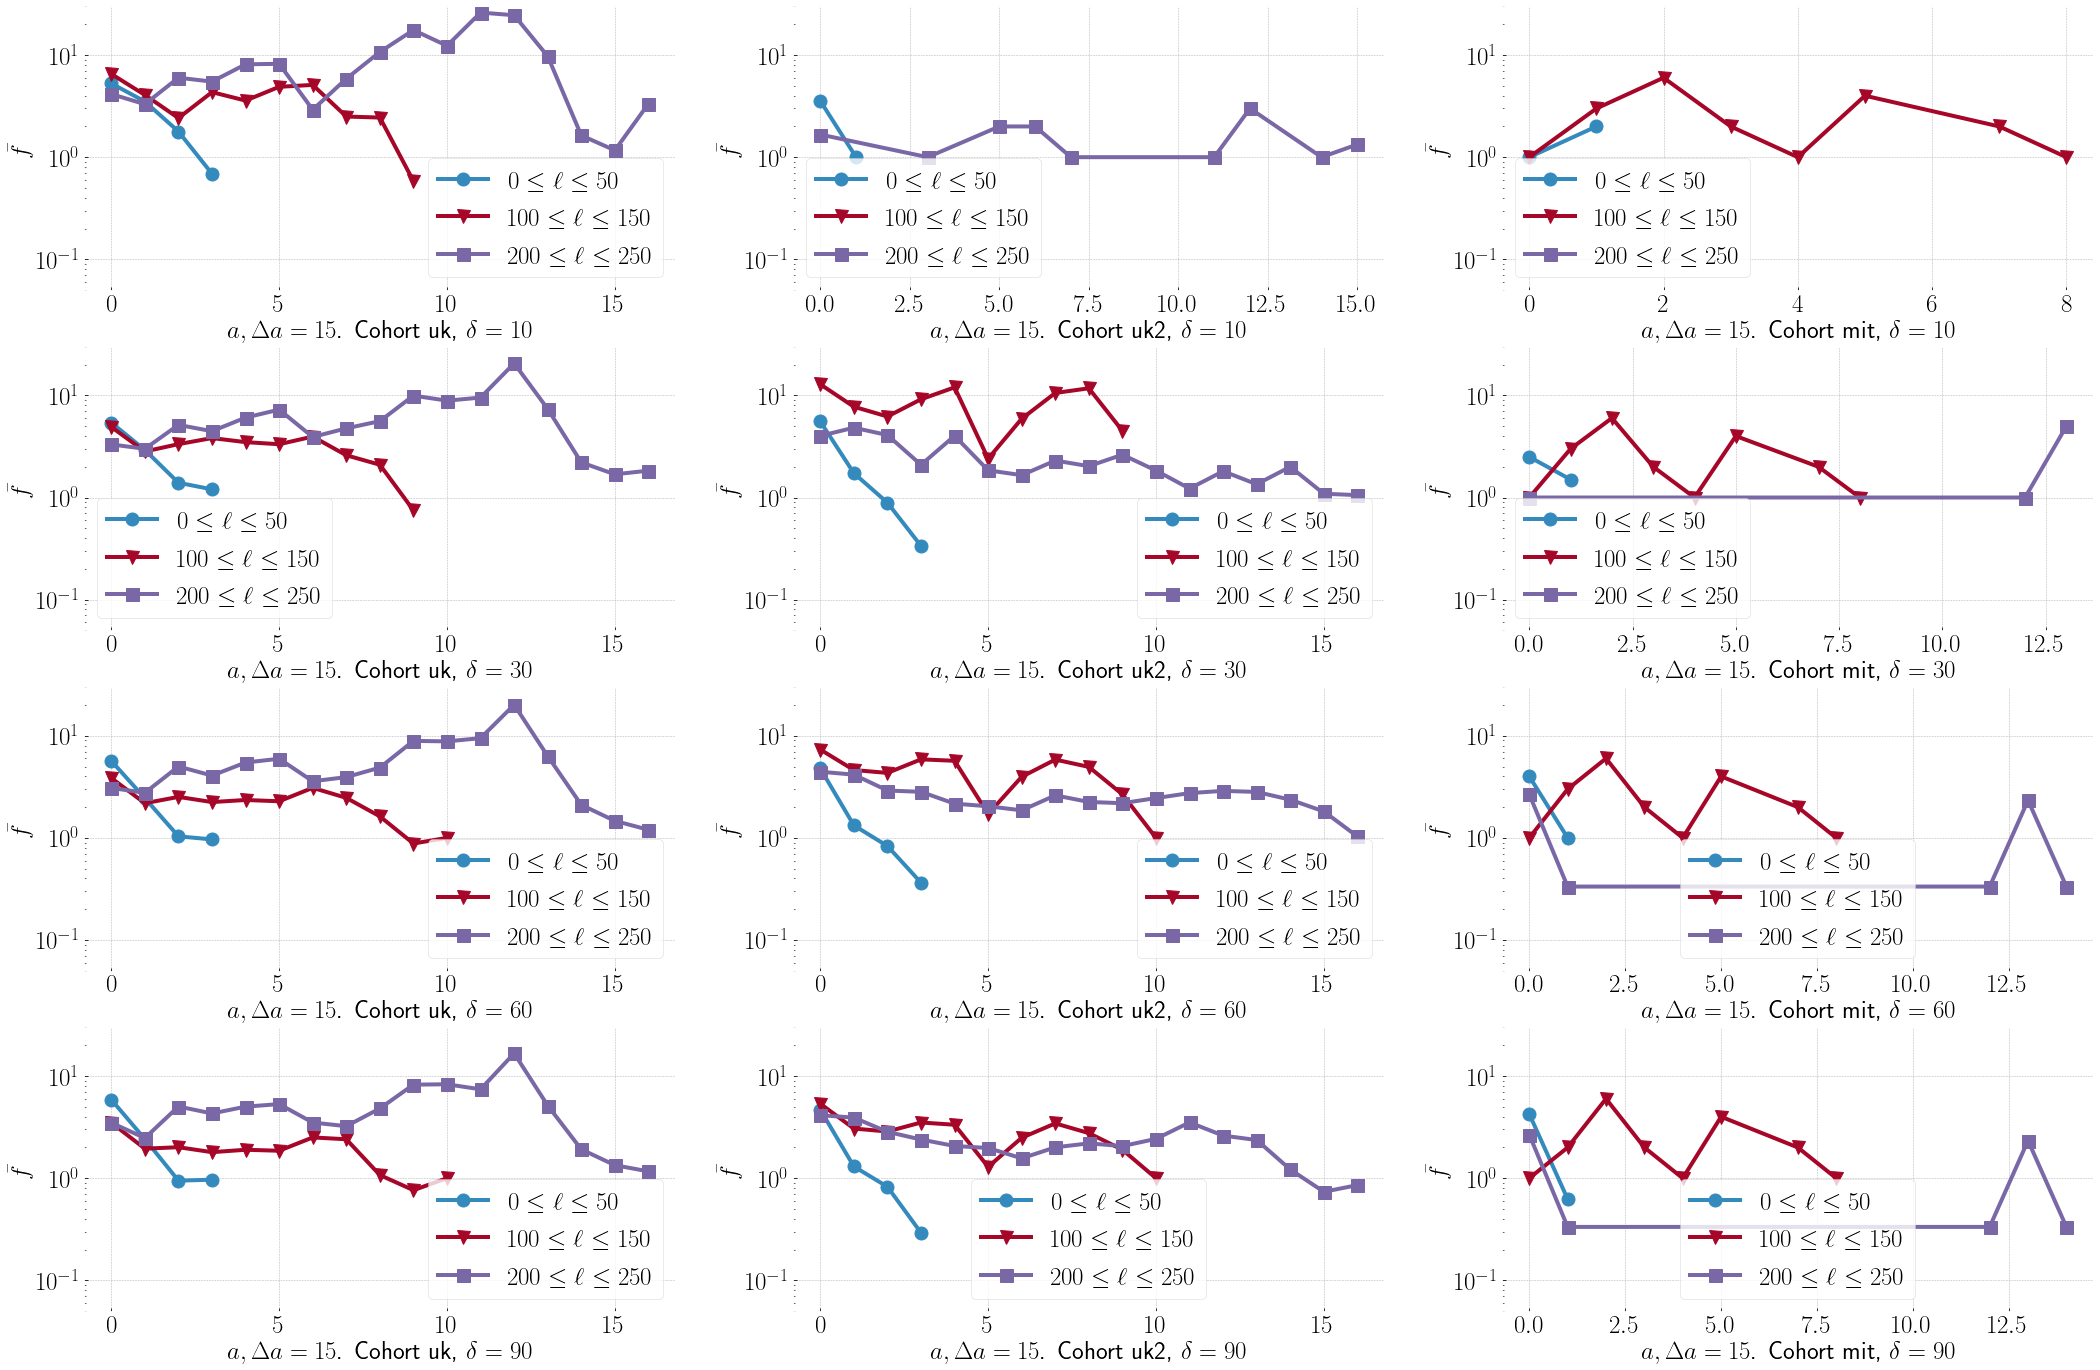

In [13]:
plt.figure(figsize=(12*3, 6*4))
p = 1
for T in [10, 30, 60, 90]:
    for c in ['uk', 'uk2', 'mit']:
        plt.subplot(4,3,p)
        plt.ylim(5* 10**(-2), 3* 10)
        plt.xlabel(fr"$a, \Delta a  = 15$. Cohort {c}, $\delta = {T}$")
        plt.ylabel(r"$\bar{f}$")
        plt.semilogy()
        for i in range(3):
            plt.plot(f2[c][T][i].index, f2[c][T][i]['f'], marker=markers[i], markersize=13, ls="solid", lw=4, label=fr'${limits[i][0]} \leq \ell \leq {limits[i][1]}$')
        plt.legend()
        p += 1

In [14]:
lft2 = {}
lf = livesd['uk2'][90]
for ego in lf.keys():
    for alter in lf[ego].keys():
        if (lf[ego][alter]['ell'] >= 100) and (lf[ego][alter]['ell'] <= 150):
            lft2['s'] = lft2.get('s', [])
            lft2['s'].append((ego, alter))
        elif (lf[ego][alter]['ell'] >= 200) and (lf[ego][alter]['ell'] <= 250):
            lft2['l'] = lft2.get('l', [])
            lft2['l'].append((ego, alter))

In [ ]:
plt.xticks([15 * x for x in f2['uk2'][90][1].index])
plt.plot([15 * x for x in f['uk2'][90][1].index], f['uk2'][90][1]['f'], marker=markers[0], markersize=13, ls="solid", lw=4, label="Old version")
plt.plot([15 * x for x in f2['uk2'][90][1].index], f2['uk2'][90][1]['f'], marker=markers[1], markersize=13, ls="solid", lw=4, label="New version")
plt.legend()

In [ ]:
for c in ['uk', 'uk2', 'mit']:
    print(c, max(unfiltered[c]['uclock']))

# Fix inconsistencies on filters

In [16]:
def apply_filters(unf_calls, delta):
    '''
    This function implements the following filters for the data:
    
    1. Removes dtimestamp duplicates for all ego-alter pairs
    2. Removes all ego-alter pairs with fewer than 3 calls
    3. Removes all pairs with any contact in the interval
       [T - delta, T)
    '''
    T = max(unf_calls['uclock'])
    df = unf_calls.copy(deep=True)
    df['ea'] = list(zip(df['ego'], df['alter']))
    df = df.sort_values(by=['ea', 'time'])
    df['shifted'] = df['time'].shift(-1)
    df['d'] = (df['shifted'] - df['time']).dt.total_seconds()
    torm = list(df.loc[df['d'] == 0].index)
    df = df.drop(torm)
    df = df.drop(columns = ['shifted', 'd'])
    ncalls = df.groupby('ea')[['time']].count().rename(columns={'time': 'ncalls'})
    ncalls = ncalls.loc[ncalls['ncalls'] > 2]
    df = df[df['ea'].isin(ncalls.index)]
    tmp = df.loc[df['uclock'] > (T - delta)]
    rmpairs = list(tmp['ea'].unique())
    df2 = df[~df['ea'].isin(rmpairs)]
    df3 = df2.drop(columns=['ea']).reset_index(drop=True)
    return df3

In [17]:
t0 = dt.datetime.now()
perdida = {}
for c in ['uk', 'uk2', 'mit']:
    df = unfiltered[c].copy(deep=True)
    df['ea'] = list(zip(df['ego'], df['alter']))
    P = len(df['ea'].unique())
    perdida[c] = []
    for i in range(0, 300, 5):
        if i > 0:
            newdf = apply_filters(df, i)
            newdf['ea'] = list(zip(newdf['ego'], newdf['alter']))
            pp = len(newdf['ea'].unique())
            perdida[c].append((i, pp / P))
print(f'Took {dt.datetime.now() - t0}')

Took 0:00:25.515589


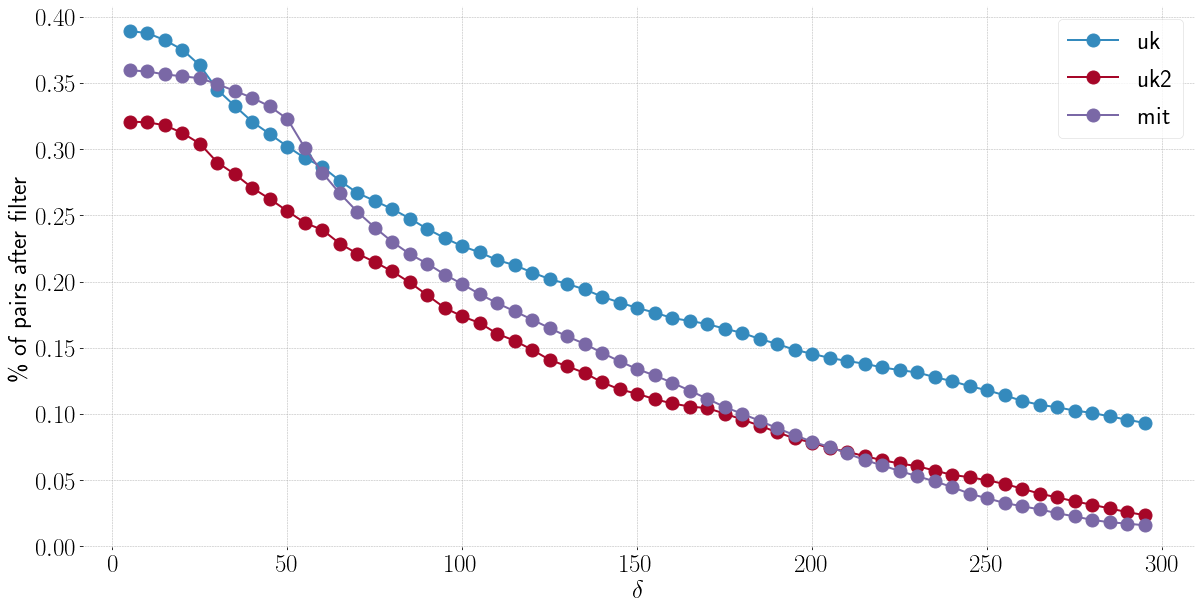

In [18]:
plt.ylabel("\% of pairs after filter")
plt.xlabel(r'$\delta$')
for c in perdida.keys():
    plt.plot([x[0] for x in perdida[c]], [y[1] for y in perdida[c]], "-o", markersize=13, label=f'{c}')
plt.legend()

In [19]:
t0 = dt.datetime.now()

callsd = {}
for c in ['uk', 'uk2', 'mit']:
    callsd[c] = {}
    for delta in [10, 30, 60, 90]:
        callsd[c][delta] = apply_filters(unfiltered[c], delta)
        df = callsd[c][delta].groupby(['ego', 'alter'])[['time']].count()
        print(c, delta, len(df))
        
dffd = {}
for c in callsd.keys():
    dffd[c] = {}
    for T in callsd[c].keys():
        dffd[c][T] = pc.get_f(callsd[c][T], 'all', 15, 67)

livesd = {}
for c in callsd.keys():
    livesd[c] = {}
    for T in callsd[c].keys():
        livesd[c][T] = pc.lives_dictionary(callsd[c][T])
    
limits = {}
limits[0] = (0, 50)
limits[1] = (100, 150)
limits[2] = (200, 250)
#limits[3] = (300, 350)


f3 = {}
for c in dffd.keys():
    f3[c] = {}
    for T in dffd[c].keys():
        f3[c][T] = {}
        for i in limits.keys():
            f3[c][T][i] = pc.get_avgfa(dffd[c][T], livesd[c][T], limits[i][0], limits[i][1])
            
print(f'Took {dt.datetime.now() - t0}')

uk 10 2651
uk 30 2358
uk 60 1960
uk 90 1639
uk2 10 1265
uk2 30 1145
uk2 60 944
uk2 90 749
mit 10 5482
mit 30 5335
mit 60 4311
mit 90 3262
Took 0:00:53.561942


In [58]:
with open('../itdata/mtl_dffa15.pickle', 'rb') as handle:
    itdffa15 = pickle.load(handle)
    handle.close()
    
with open('../itdata/mtl_livesd.pickle', 'rb') as handle:
    livesit = pickle.load(handle)
    handle.close()

In [21]:
f3['it'] = {}
for delta in [10, 30, 60, 90]:
    f3['it'][delta] = {}
    for i in limits.keys():
        f3['it'][delta][i] = pc.get_avgfa(itdffa15[delta], livesit[delta], limits[i][0], limits[i][1])

In [22]:
livesit.keys()

dict_keys([10, 30, 50, 60, 90])

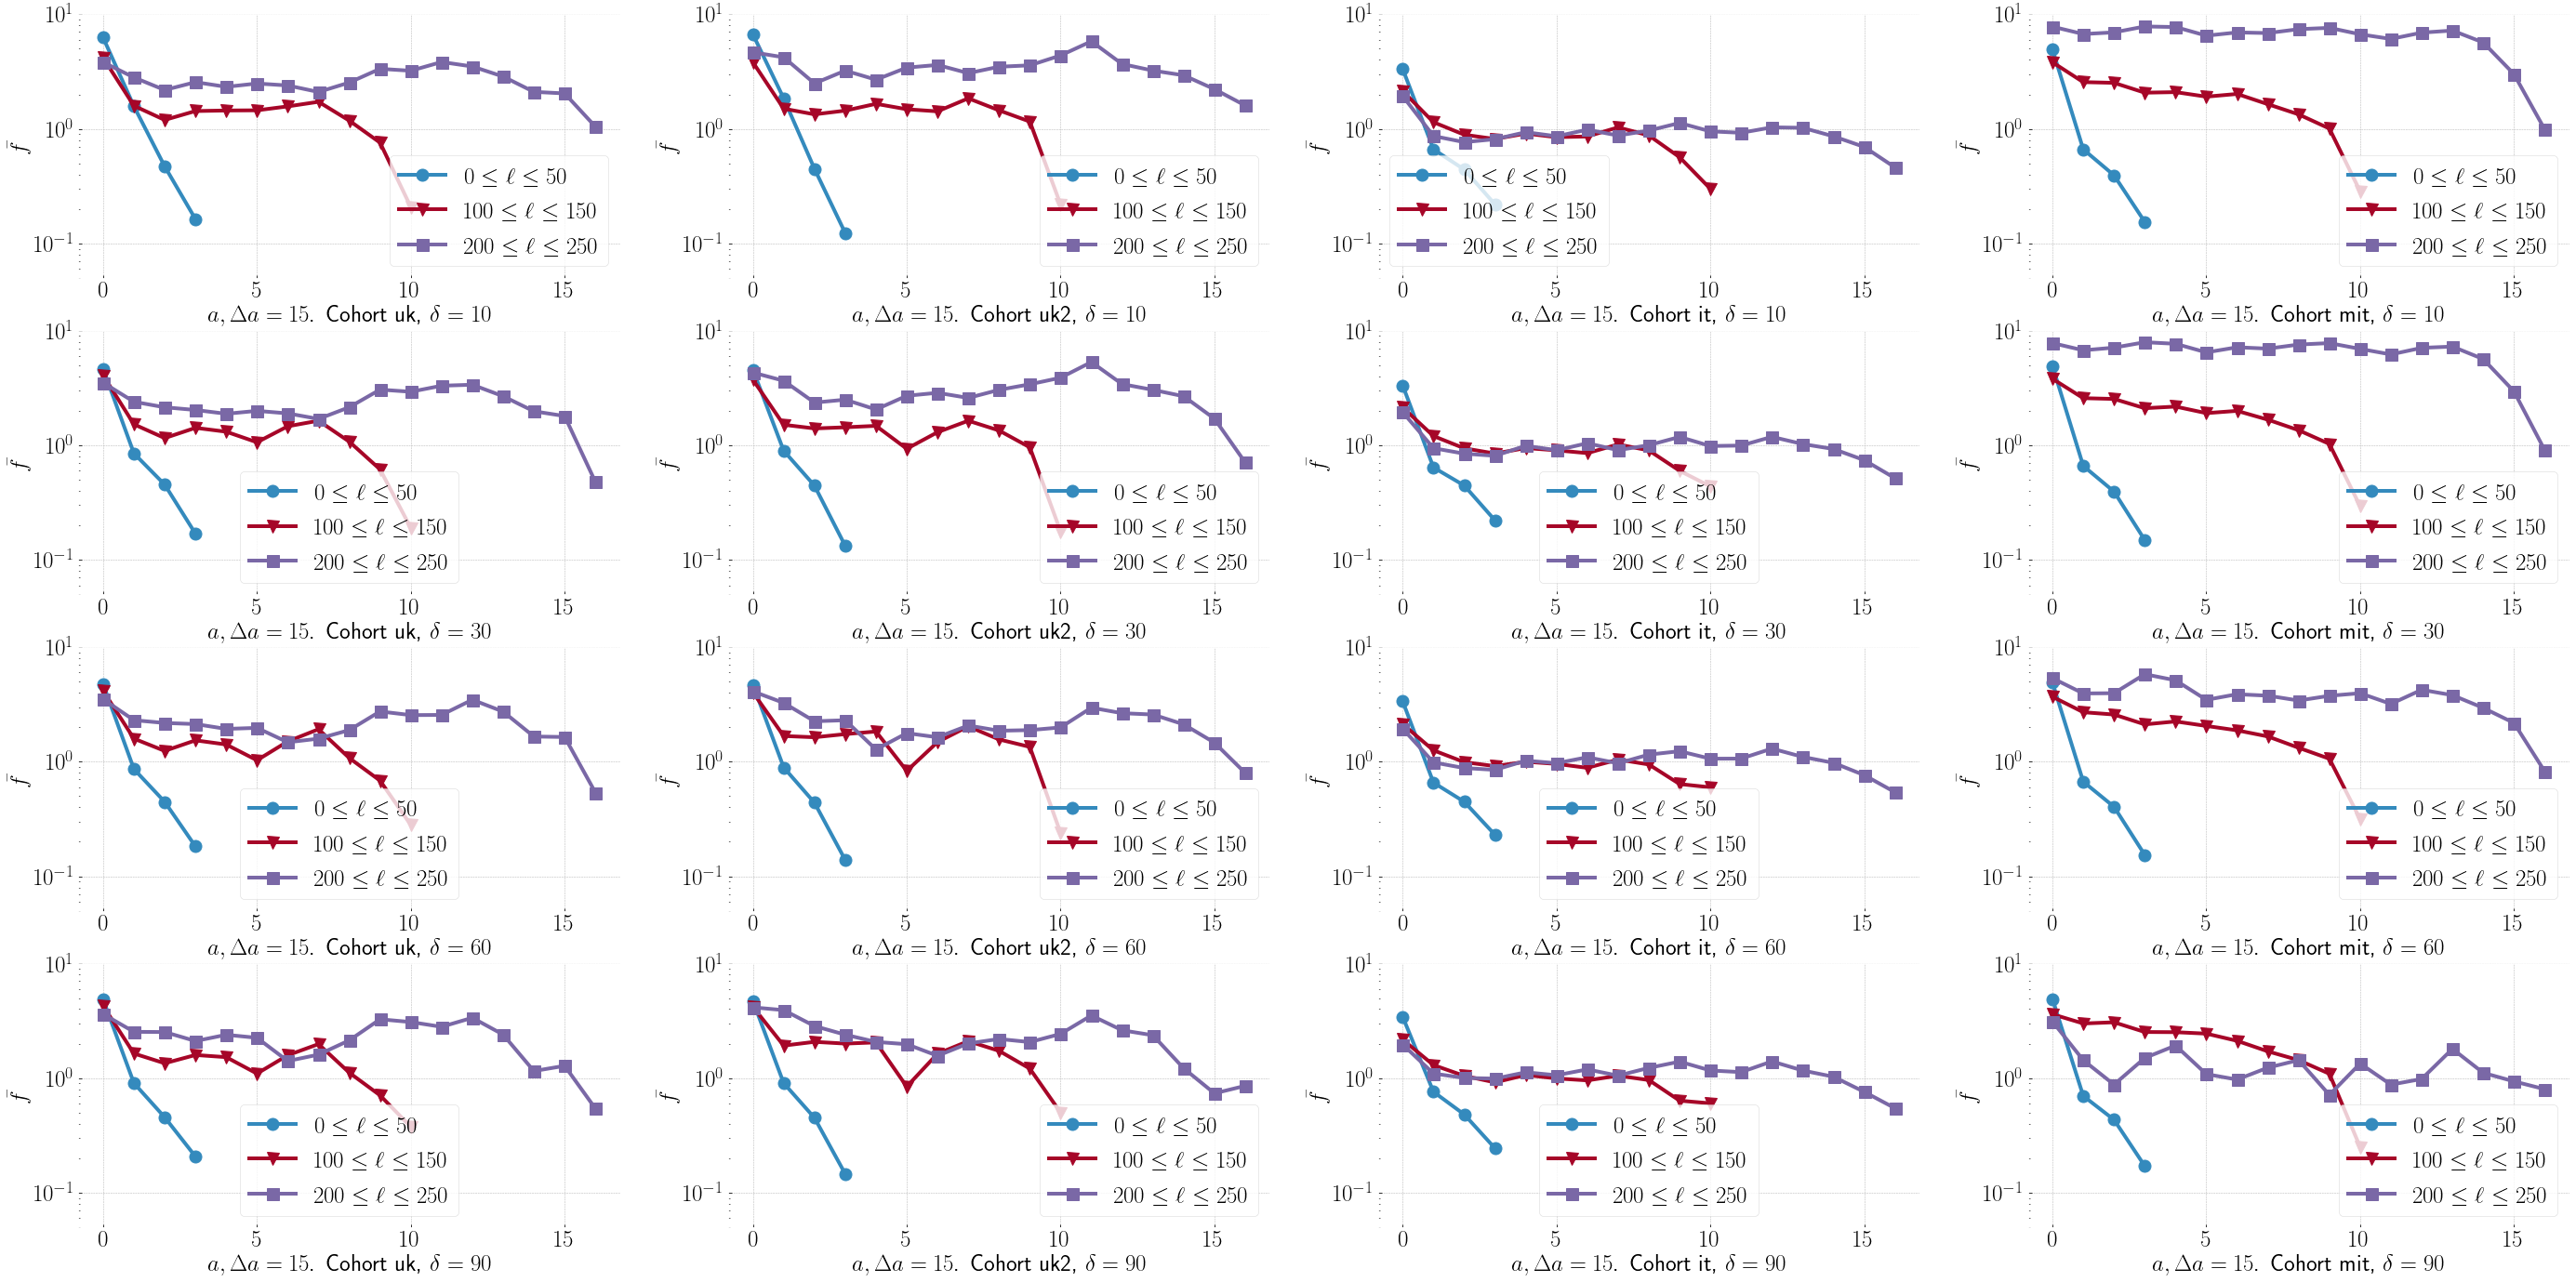

In [23]:
plt.figure(figsize=(12*4, 6*4))
p = 1
for T in [10, 30, 60, 90]:
    for c in ['uk', 'uk2', 'it', 'mit']:
        plt.subplot(4,4,p)
        plt.ylim(5* 10**(-2), 10)
        plt.xlabel(fr"$a, \Delta a  = 15$. Cohort {c}, $\delta = {T}$")
        plt.ylabel(r"$\bar{f}$")
        plt.semilogy()
        for i in range(3):
            plt.plot(f3[c][T][i].index, f3[c][T][i]['f'], marker=markers[i], markersize=13, ls="solid", lw=4, label=fr'${limits[i][0]} \leq \ell \leq {limits[i][1]}$')
        plt.legend()
        p += 1

In [24]:
def get_fal(calls, ello, ellf, bina):
    df = calls.copy(deep=True)
    df['ea'] = list(zip(df['ego'], df['alter']))
    lf = df.groupby('ea')[['aclock']].max()
    lf = lf.loc[(lf['aclock'] >= ello) & (lf['aclock'] <= ellf)]
    df = df[df['ea'].isin(lf.index)]
    fi = {}
    maxt = 0
    for ego in df['ego'].unique():
        df1 = df.loc[df['ego'] == ego]
        mina = min(df1['aclock'])
        df2 = df1.copy()
        df2['a'] = df1['aclock'] // bina
        callsa = df2.groupby('a')[['time']].count().rename({'time': 'f'}, axis='columns')
        callsa['f'] /= len(df2['alter'].unique())
        callsa = callsa.sort_index()
        fi[ego] = callsa
    
    tmp = {}
    for ego in fi.keys():
        for i in fi[ego].index:
            tmp[i] = tmp.get(i, [])
            tmp[i].append(fi[ego].at[i, 'f'])
            
    tmp2 = {}
    for i in tmp.keys():
        tmp2[i] = np.nanmean(tmp[i])
        
    f = pd.DataFrame.from_dict(tmp2, orient='index')
    f = f.sort_index()
    f.columns = ['f']
    return {'f': f, 'fi': fi}

In [25]:
t0 = dt.datetime.now()

callsd = {}
for c in ['uk', 'uk2', 'mit']:
    callsd[c] = {}
    for delta in [10, 30, 60, 90]:
        callsd[c][delta] = apply_filters(unfiltered[c], delta)
        df = callsd[c][delta].groupby(['ego', 'alter'])[['time']].count()
        print(c, delta, len(df))

f3 = {}
for c in callsd.keys():
    f3[c] = {}
    for delta in callsd[c].keys():
        f3[c][delta] = {}
        for i in limits.keys():
            f3[c][delta][i] = get_fal(callsd[c][delta], limits[i][0], limits[i][1], 15)
            
print(f'Took {dt.datetime.now() - t0}')

uk 10 2651
uk 30 2358
uk 60 1960
uk 90 1639
uk2 10 1265
uk2 30 1145
uk2 60 944
uk2 90 749
mit 10 5482
mit 30 5335
mit 60 4311
mit 90 3262
Took 0:00:08.297836


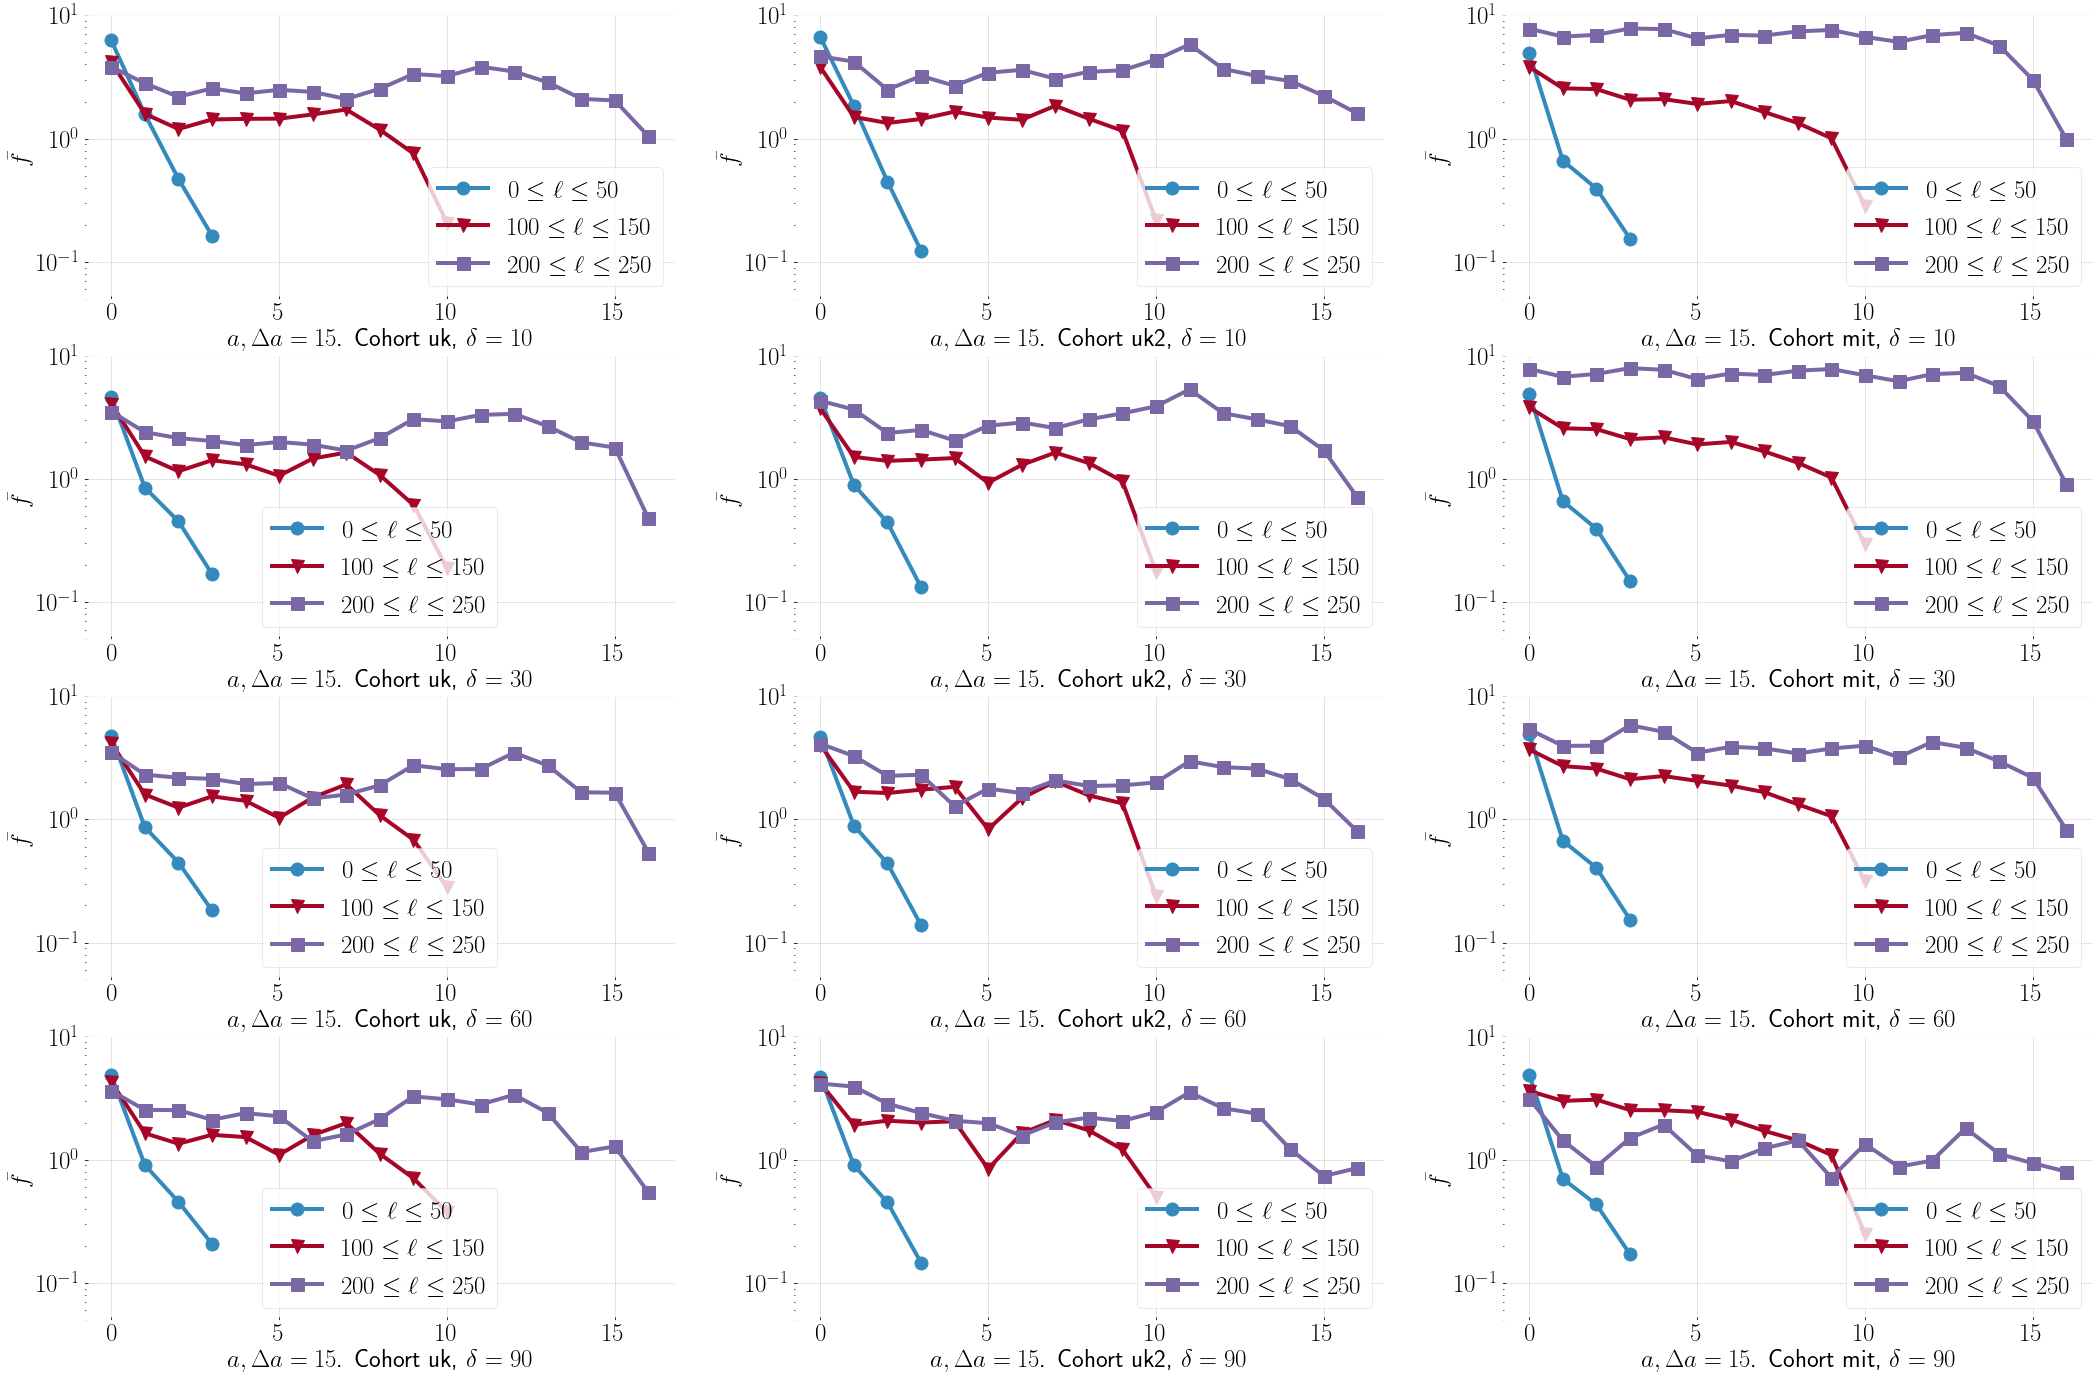

In [26]:
plt.figure(figsize=(12*3, 6*4))
p = 1
for T in [10, 30, 60, 90]:
    for c in ['uk', 'uk2', 'mit']:
        plt.subplot(4,3,p)
        plt.ylim(5* 10**(-2), 10)
        plt.xlabel(fr"$a, \Delta a  = 15$. Cohort {c}, $\delta = {T}$")
        plt.ylabel(r"$\bar{f}$")
        plt.semilogy()
        for i in range(3):
            plt.plot(f3[c][T][i]['f'].index, f3[c][T][i]['f']['f'], marker=markers[i], markersize=13, ls="solid", lw=4, label=fr'${limits[i][0]} \leq \ell \leq {limits[i][1]}$')
        plt.legend()
        p += 1

# Separate UK contacts 

First, import data

In [27]:
import sys

# First, read the files and put them in a list
thefiles = os.listdir("../ukdata/egos_attributeSummaries/")

# now, remove everything that does not follow the structure 'egoxx_...'
for i in thefiles:
    if i[5] != '_':
        thefiles.remove(i)

# I need the following lines because MacOS creates a .DS_Store file
if sys.platform == 'darwin':
    thefiles.remove('.DS_Store')
        
# Next, a list with just the number of the egos.
theindices = [int(i[3:5]) for i in thefiles]

# And finally, everything into a dictionary.
alterinfo = {}
colnames = ['alterid', 'male', 'related', 'sameGen', 'ec1', 'ec2', 'ec3', 'alter_number1', 'alter_number2', 'alter_number3', 'alter_number4']
for i in range(len(thefiles)):
    alterinfo[theindices[i]] = pd.read_csv(f"../ukdata/egos_attributeSummaries/{thefiles[i]}", header=None, sep=" ", names=colnames, na_values=-999, 
                                           dtype={'alter_number1' : 'str', 'alter_number2' : 'str', 'alter_number3' : 'str', 'alter_number4' : 'str'})

In [28]:
thefiles = os.listdir("../ukdata/egos_alterNumbers/")
for i in thefiles:
    if i[5] != '_':
        thefiles.remove(i)
idx = [int(i[3:5]) for i in thefiles]
alterid = {}
for eid in range(len(idx)):
    df = pd.read_csv(f'../ukdata/egos_alterNumbers/{thefiles[eid]}', header=None, sep=" ", dtype={0: 'str'})
    tmp2 = {}
    for i in df.index:
        key = df.at[i, 0][-8:]
        val = df.at[i, 1]
        tmp2[key] = val
    alterid[idx[eid]] = tmp2

eid = pd.read_pickle("egoid.pkl")

In [29]:
alterinfo[30]

alterid  male  related  sameGen  ec1   ec2  ec3 alter_number1  \
0          0   NaN      1.0      NaN  NaN   9.0  0.0      96684666   
1          1   NaN      0.0      NaN  NaN   3.0  0.0      48666822   
2          2   NaN      0.0      NaN  NaN   6.0  0.0      12039523   
3          3   NaN      1.0      NaN  NaN  10.0  0.0      50483877   
4          4   NaN      0.0      NaN  NaN  10.0  0.0      77460723   
..       ...   ...      ...      ...  ...   ...  ...           ...   
268      268   NaN      NaN      NaN  NaN   NaN  NaN      43421460   
269      269   NaN      NaN      NaN  NaN   NaN  NaN      35118014   
270      270   NaN      NaN      NaN  NaN   NaN  NaN      65325474   
271      271   NaN      NaN      NaN  NaN   NaN  NaN      02810244   
272      272   NaN      NaN      NaN  NaN   NaN  NaN      29915810   

    alter_number2 alter_number3 alter_number4  
0             NaN           NaN           NaN  
1             NaN           NaN           NaN  
2             NaN           NaN           NaN  
3             NaN           NaN           NaN  
4             NaN           NaN           NaN  
..            ...           ...           ...  
268           NaN           NaN           NaN  
269           NaN           NaN           NaN  
270           NaN           NaN           NaN  
271           NaN           NaN           NaN  
272           NaN           NaN           NaN  

[273 rows x 11 columns]

In [30]:
ukcalls = unfiltered['uk'].copy(deep=True)
ukcalls = ukcalls.drop(columns=['rm'])
ukcalls.head()

ego           alter                time  uclock  aclock
0  C07814508939  C0020165636994 2008-02-07 16:18:00     339       0
1  C07814508939  C0020165636994 2008-02-07 17:11:00     339       0
2  C07814508939  C0020165636994 2008-02-20 15:39:00     352      13
3  C07792658311  C0021213487966 2008-02-27 17:01:00     359       0
4  C07792658311  C0021213487966 2008-02-27 17:55:00     359       0

In [31]:
egonames = eid.groupby('ego')[['egoid']].mean().to_dict()['egoid']
egonames

{'00643277': 7,
 '00643415': 21,
 '00643466': 13,
 '00650314': 27,
 '00650511': 10,
 '00755987': 8,
 '00756002': 23,
 '00756371': 16,
 '00759083': 3,
 '00759255': 15,
 '05206865': 1,
 '05656488': 2,
 '14508939': 30,
 '17280467': 19,
 '55941005': 5,
 '70136770': 12,
 '74937603': 17,
 '74937643': 18,
 '79270485': 4,
 '90818114': 9,
 '90948782': 25,
 '91428359': 20,
 '92057901': 28,
 '92058001': 29,
 '92658311': 11,
 '92658339': 14,
 '92895869': 24,
 '96537661': 22,
 '96556837': 6,
 '99103487': 26}

In [32]:
ukcalls['eid'] = ukcalls['ego'].map(lambda i: egonames[i[-8:]])
ukcalls.head()

ego           alter                time  uclock  aclock  eid
0  C07814508939  C0020165636994 2008-02-07 16:18:00     339       0   30
1  C07814508939  C0020165636994 2008-02-07 17:11:00     339       0   30
2  C07814508939  C0020165636994 2008-02-20 15:39:00     352      13   30
3  C07792658311  C0021213487966 2008-02-27 17:01:00     359       0   11
4  C07792658311  C0021213487966 2008-02-27 17:55:00     359       0   11

In [33]:
egoaltertable = {}
for ego in alterinfo.keys():
    egoaltertable[ego] = {}
    df = alterinfo[ego]
    for i in df.index:
        for an in ['alter_number1', 'alter_number2', 'alter_number3', 'alter_number4']:
            if not pd.isna(df.at[i, an]):
                number = df.at[i, an]
                egoaltertable[ego][number] = i

In [34]:
ukcalls['alter8'] = ukcalls['alter'].map(lambda i: i[-8:])
ukcalls.head()

ego           alter                time  uclock  aclock  eid  \
0  C07814508939  C0020165636994 2008-02-07 16:18:00     339       0   30   
1  C07814508939  C0020165636994 2008-02-07 17:11:00     339       0   30   
2  C07814508939  C0020165636994 2008-02-20 15:39:00     352      13   30   
3  C07792658311  C0021213487966 2008-02-27 17:01:00     359       0   11   
4  C07792658311  C0021213487966 2008-02-27 17:55:00     359       0   11   

     alter8  
0  65636994  
1  65636994  
2  65636994  
3  13487966  
4  13487966

In [35]:
ukcalls['tmp'] = list(zip(ukcalls['eid'], ukcalls['alter8']))
ukcalls.head()

ego           alter                time  uclock  aclock  eid  \
0  C07814508939  C0020165636994 2008-02-07 16:18:00     339       0   30   
1  C07814508939  C0020165636994 2008-02-07 17:11:00     339       0   30   
2  C07814508939  C0020165636994 2008-02-20 15:39:00     352      13   30   
3  C07792658311  C0021213487966 2008-02-27 17:01:00     359       0   11   
4  C07792658311  C0021213487966 2008-02-27 17:55:00     359       0   11   

     alter8             tmp  
0  65636994  (30, 65636994)  
1  65636994  (30, 65636994)  
2  65636994  (30, 65636994)  
3  13487966  (11, 13487966)  
4  13487966  (11, 13487966)

In [36]:
ukcalls['aid'] = ukcalls['tmp'].map(lambda i: egoaltertable[i[0]].get(i[1], 9999))
ukcalls = ukcalls.drop(columns=['tmp'])
ukcalls = ukcalls.loc[ukcalls['aid'] != 9999]
ukcalls.head()

ego           alter                time  uclock  aclock  eid  \
0  C07814508939  C0020165636994 2008-02-07 16:18:00     339       0   30   
1  C07814508939  C0020165636994 2008-02-07 17:11:00     339       0   30   
2  C07814508939  C0020165636994 2008-02-20 15:39:00     352      13   30   
3  C07792658311  C0021213487966 2008-02-27 17:01:00     359       0   11   
4  C07792658311  C0021213487966 2008-02-27 17:55:00     359       0   11   

     alter8  aid  
0  65636994  177  
1  65636994  177  
2  65636994  177  
3  13487966  182  
4  13487966  182

In [37]:
ukcalls['eaid'] = list(zip(ukcalls['eid'], ukcalls['aid']))
tmp = list(ukcalls['eaid'].unique())
dftmp = pd.DataFrame({'eaid': tmp})
dftmp.head()

eaid
0  (30, 177)
1  (11, 182)
2   (25, 93)
3  (17, 320)
4  (17, 181)

In [38]:
dftmp['family'] = dftmp['eaid'].map(lambda i: alterinfo[i[0]].at[i[1], 'related'])
dftmp.head()

eaid  family
0  (30, 177)     NaN
1  (11, 182)     NaN
2   (25, 93)     NaN
3  (17, 320)     NaN
4  (17, 181)     NaN

In [39]:
for ego in alterinfo.keys():
    df = alterinfo[ego]
    df['ec'] = df[['ec1', 'ec2', 'ec3']].mean(axis=1, skipna=True)

In [40]:
dftmp['ec'] = dftmp['eaid'].map(lambda i: alterinfo[i[0]].at[i[1], 'ec'])
dftmp.head()

eaid  family  ec
0  (30, 177)     NaN NaN
1  (11, 182)     NaN NaN
2   (25, 93)     NaN NaN
3  (17, 320)     NaN NaN
4  (17, 181)     NaN NaN

In [41]:
ukcalls = ukcalls.merge(dftmp, on='eaid', how='outer')
ukcalls.head()

ego           alter                time  uclock  aclock  eid  \
0  C07814508939  C0020165636994 2008-02-07 16:18:00     339       0   30   
1  C07814508939  C0020165636994 2008-02-07 17:11:00     339       0   30   
2  C07814508939  C0020165636994 2008-02-20 15:39:00     352      13   30   
3  C07792658311  C0021213487966 2008-02-27 17:01:00     359       0   11   
4  C07792658311  C0021213487966 2008-02-27 17:55:00     359       0   11   

     alter8  aid       eaid  family  ec  
0  65636994  177  (30, 177)     NaN NaN  
1  65636994  177  (30, 177)     NaN NaN  
2  65636994  177  (30, 177)     NaN NaN  
3  13487966  182  (11, 182)     NaN NaN  
4  13487966  182  (11, 182)     NaN NaN

(array([  353.,  1953.,  3989.,  3036.,  4330.,  5199., 13808.,  7379.,
         8203., 12808.]),
 array([ 0.5 ,  1.45,  2.4 ,  3.35,  4.3 ,  5.25,  6.2 ,  7.15,  8.1 ,
         9.05, 10.  ]),
 <BarContainer object of 10 artists>)

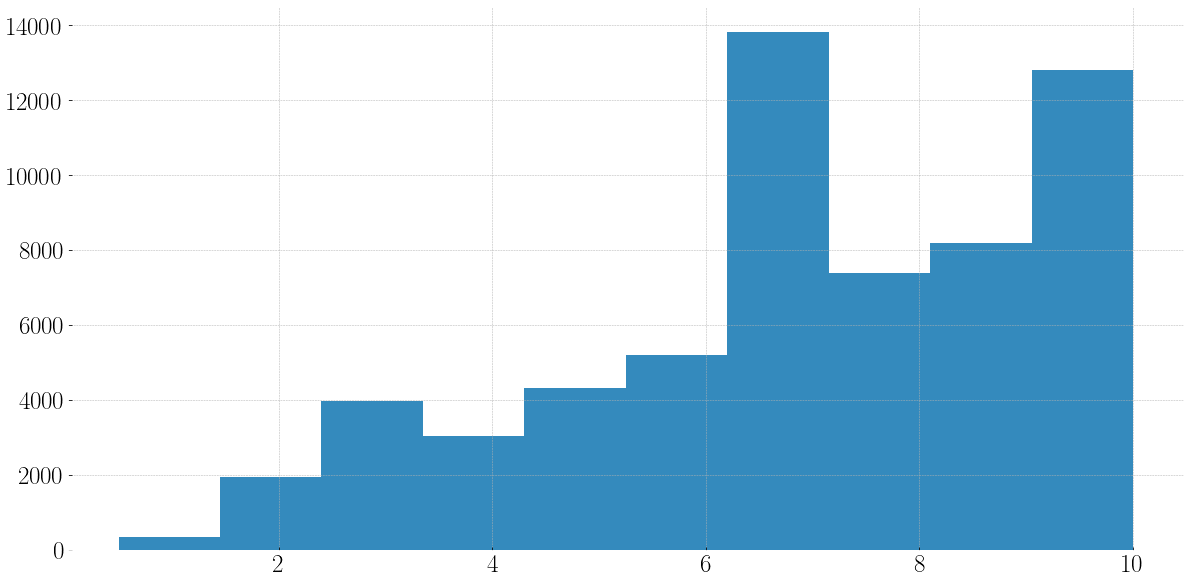

In [42]:
plt.hist(ukcalls['ec'])

In [43]:
ukc = {}
ukc['family'] = ukcalls.loc[ukcalls['family'] == 1]
ukc['friends'] = ukcalls.loc[ukcalls['family'] == 0]
ukc['nolabel'] = ukcalls.loc[(ukcalls['family'] != 0) & (ukcalls['family'] != 1)]

In [44]:
len(ukc['family']) + len(ukc['friends']) + len(ukc['nolabel']) == len(ukcalls)

True

Took 0:00:09.982896


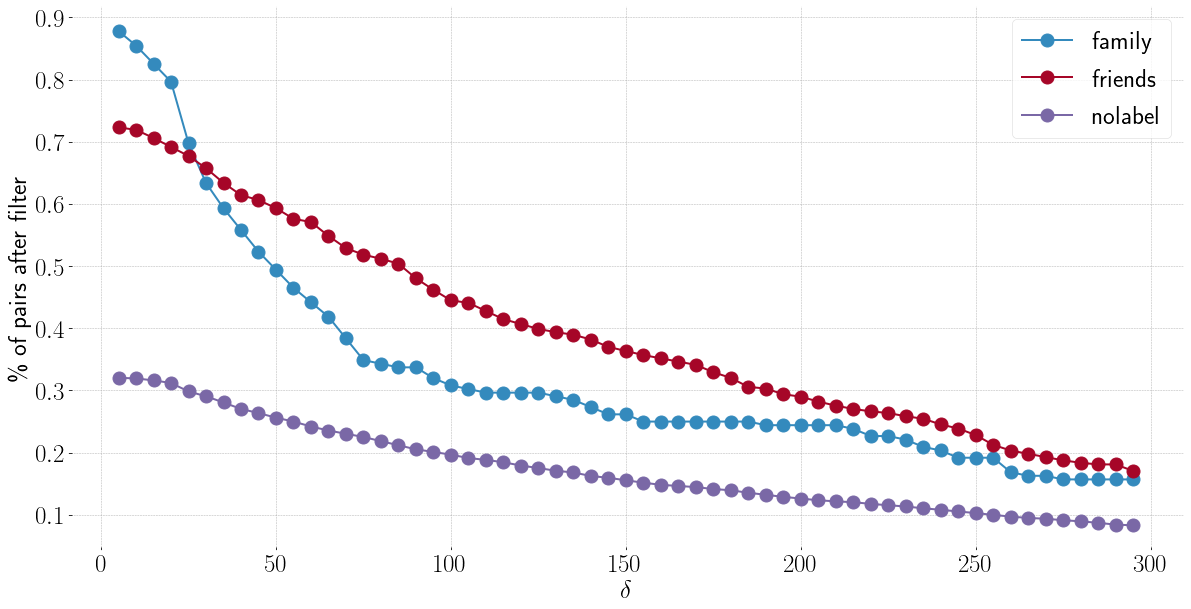

In [45]:
t0 = dt.datetime.now()
perdidauk = {}
for c in ukc.keys():
    df = ukc[c].copy(deep=True)
    P = len(df['eaid'].unique())
    perdidauk[c] = []
    for i in range(0, 300, 5):
        if i > 0:
            newdf = apply_filters(df, i)
            pp = len(newdf['eaid'].unique())
            perdidauk[c].append((i, pp / P))
print(f'Took {dt.datetime.now() - t0}')

plt.ylabel("\% of pairs after filter")
plt.xlabel(r'$\delta$')
for c in perdidauk.keys():
    plt.plot([x[0] for x in perdidauk[c]], [y[1] for y in perdidauk[c]], "-o", markersize=13, label=f'{c}')
plt.legend()

In [46]:
def get_fal(calls, ello, ellf, bina):
    df = calls.copy(deep=True)
    df['ea'] = list(zip(df['ego'], df['alter']))
    lf = df.groupby('ea')[['aclock']].max()
    lf = lf.loc[(lf['aclock'] >= ello) & (lf['aclock'] <= ellf)]
    df = df[df['ea'].isin(lf.index)]
    fi = {}
    maxt = 0
    for ego in df['ego'].unique():
        df1 = df.loc[df['ego'] == ego]
        mina = min(df1['aclock'])
        df2 = df1.copy()
        df2['a'] = df1['aclock'] // bina
        callsa = df2.groupby('a')[['time']].count().rename({'time': 'f'}, axis='columns')
        callsa['f'] /= len(df2['alter'].unique())
        callsa = callsa.sort_index()
        fi[ego] = callsa
    
    tmp = {}
    for ego in fi.keys():
        for i in fi[ego].index:
            tmp[i] = tmp.get(i, [])
            tmp[i].append(fi[ego].at[i, 'f'])
            
    tmp2 = {}
    for i in tmp.keys():
        tmp2[i] = np.nanmean(tmp[i])
        
    f = pd.DataFrame.from_dict(tmp2, orient='index')
    f = f.sort_index()
    f.columns = ['f']
    return {'f': f, 'fi': fi}

In [47]:
ukcf = {}
for c in ukc.keys():
    ukcf[c] = apply_filters(ukc[c], 25)
    
limits = {}
limits[0] = (0, 50)
limits[1] = (100, 150)
limits[2] = (200, 250)

In [48]:
ukfa = {}
for c in ukcf.keys():
    ukfa[c] = {}
    for i in range(3):
        ukfa[c][i] = get_fal(ukcf[c], limits[i][0], limits[i][1], 15)

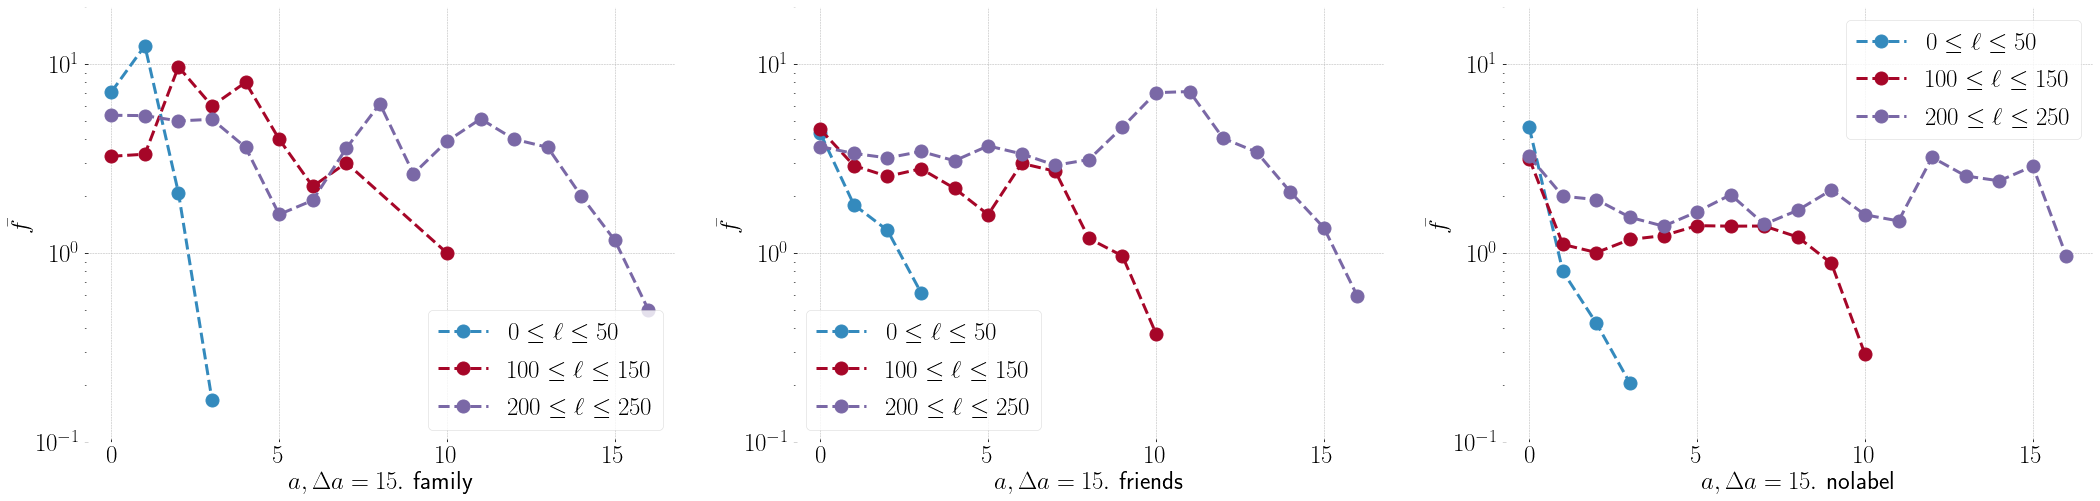

In [49]:
plt.figure(figsize=(12*3, 8*1))
p = 1
for c in ukfa.keys():
    plt.subplot(1,3,p)
    plt.semilogy()
    plt.ylim(10**(-1), 2*10**1)
    plt.xlabel(fr"$a, \Delta a  = 15.$ {c}")
    plt.ylabel(r'$\bar{f}$')
    for i in range(3):
        plt.plot(ukfa[c][i]['f'].index, ukfa[c][i]['f']['f'], marker="o", markersize=13, ls="dashed", lw=3, label=fr'${limits[i][0]} \leq \ell \leq {limits[i][1]}$')
    plt.legend()
    p += 1

In [50]:
ukec = {}
ukec['close'] = ukcalls.loc[ukcalls['ec'] >= 8]
ukec['notclose'] = ukcalls.loc[ukcalls['ec'] < 8]
ukec['nolabel'] = ukcalls[ukcalls['ec'].isna()]

In [51]:
len(ukc['family']) + len(ukc['friends']) + len(ukc['nolabel']) == len(ukcalls)

True

In [52]:
ukecf = {}
for c in ukec.keys():
    ukecf[c] = apply_filters(ukec[c], 25)
    
limits = {}
limits[0] = (0, 50)
limits[1] = (100, 150)
limits[2] = (200, 250)

ukecfa = {}
for c in ukecf.keys():
    ukecfa[c] = {}
    for i in range(3):
        ukecfa[c][i] = get_fal(ukecf[c], limits[i][0], limits[i][1], 15)

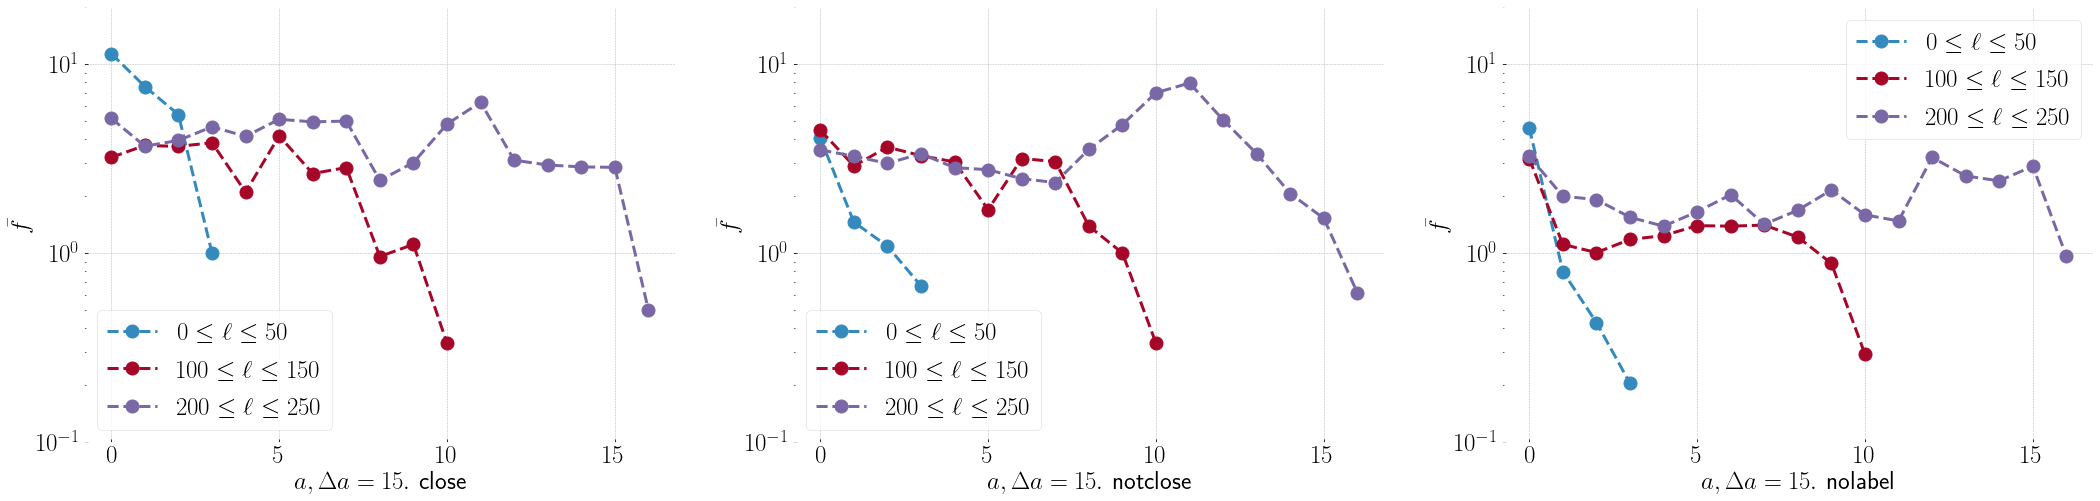

In [53]:
plt.figure(figsize=(12*3, 8*1))
p = 1
for c in ukecfa.keys():
    plt.subplot(1,3,p)
    plt.semilogy()
    plt.ylim(10**(-1), 2*10**1)
    plt.xlabel(fr"$a, \Delta a  = 15.$ {c}")
    plt.ylabel(r'$\bar{f}$')
    for i in range(3):
        plt.plot(ukecfa[c][i]['f'].index, ukecfa[c][i]['f']['f'], marker="o", markersize=13, ls="dashed", lw=3, label=fr'${limits[i][0]} \leq \ell \leq {limits[i][1]}$')
    plt.legend()
    p += 1

# Results from the paper, again

This time I will use the same filters applied before to produce the results from figures 2, 3, and 4. The chosen value for $\delta$ will be 50

In [54]:
calls = {}
for c in ['uk', 'uk2', 'mit']:
    calls[c] = apply_filters(unfiltered[c], 60)

## Fig 2

### Lifetime histogram

In [55]:
Hl = {}
for c in calls.keys():
    Hl[c] = {}
    df = calls[c].copy(deep=True)
    df['ea'] = list(zip(df['ego'], df['alter']))
    lf = df.groupby('ea')[['aclock']].max().rename({'aclock': 'ell'}, axis='columns')
    for ell in lf['ell'] // 10:
        Hl[c][ell] = Hl[c].get(ell, 0) + 1
    Hl[c] = pd.DataFrame.from_dict(Hl[c], orient='index').sort_index()
    Hl[c]['pmf'] = Hl[c][0].div(sum(Hl[c][0]))

In [59]:
Hl['it'] = {}
for ego in itdffa15[60].keys():
    for alter in itdffa15[60][ego].keys():
        ell = livesit[60][ego][alter]['ell'] // 10
        Hl['it'][ell] = Hl['it'].get(ell, 0) + 1
Hl['it'] = pd.DataFrame.from_dict(Hl['it'], orient='index').sort_index()
Hl['it']['pmf'] = Hl['it'][0].div(sum(Hl['it'][0]))

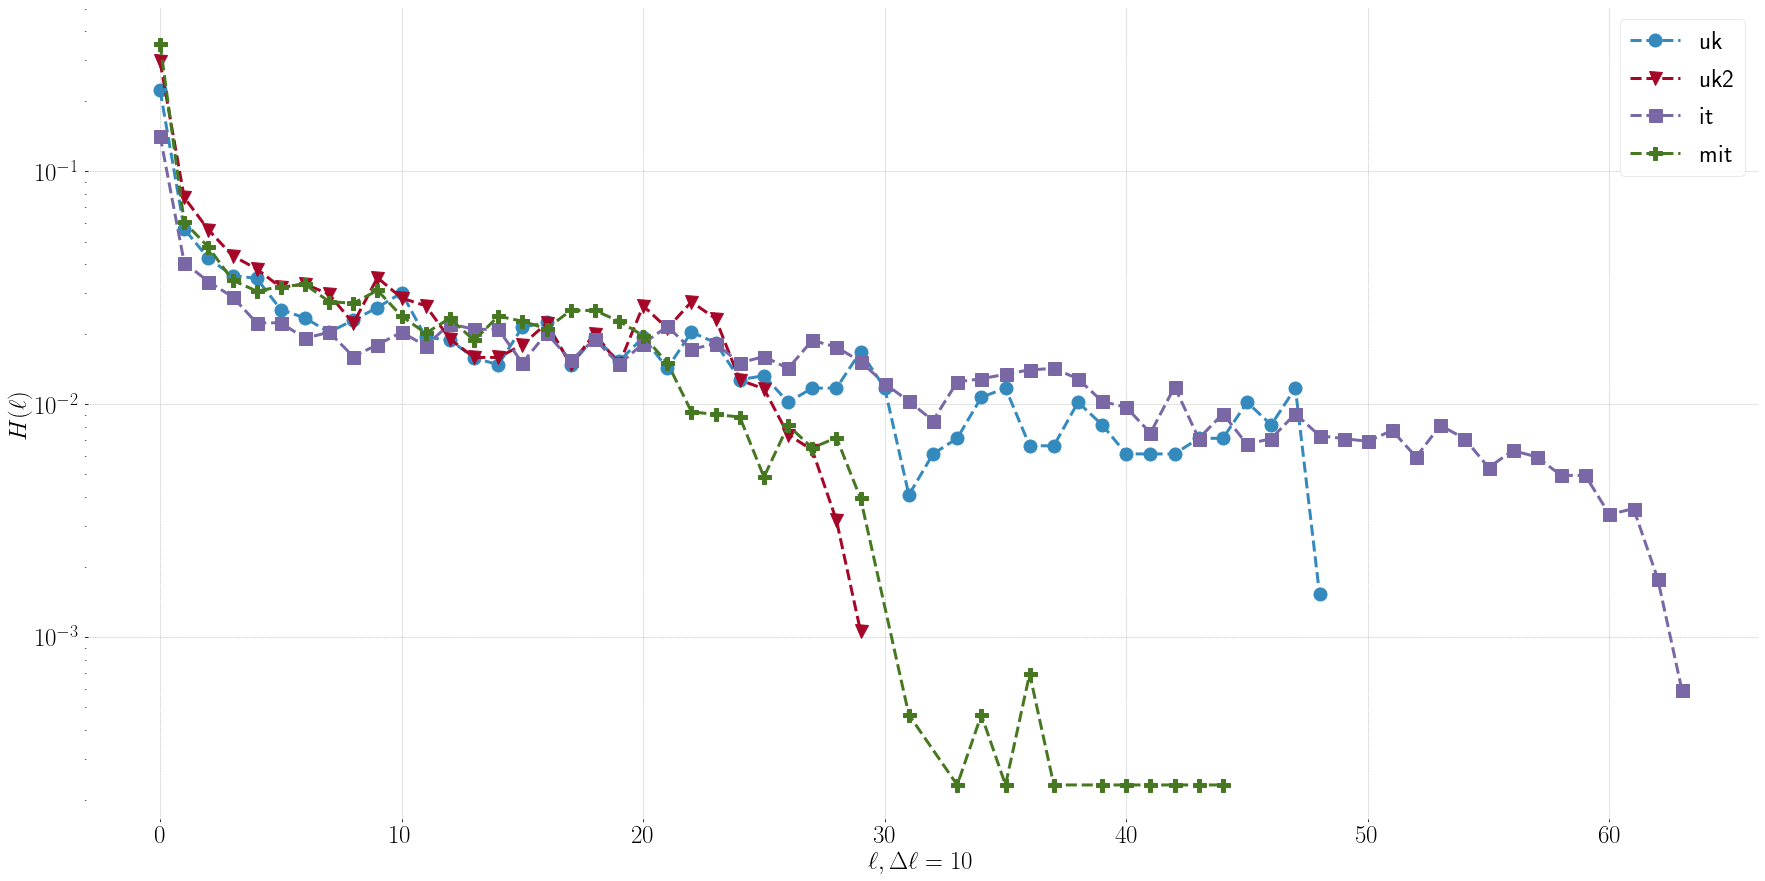

In [60]:
plt.figure(figsize=(30, 15))
plt.xlabel(r"$\ell, \Delta \ell = 10$")
plt.ylabel(r"$H(\ell)$")
plt.semilogy()
m = 0
for c in ['uk', 'uk2', 'it', 'mit']:
    plt.plot(Hl[c].index, Hl[c]['pmf'], marker=markers[m], ls="--", markersize=13, lw=3, label=c)
    m += 1
plt.legend()

In [61]:
limits = {}
for c, ellmax in zip(['uk', 'uk2', 'it', 'mit'], [450, 220, 500, 280]):
    limits[c] = [(i * (ellmax // 6), (i + 1) * (ellmax // 6)) for i in range(0, 6, 2)]

### Back to the results

In [62]:
fa = {}
for c in callsd.keys():
    fa[c] = {}
    for i in range(3):
        fa[c][i] = get_fal(calls[c], limits[c][i][0], limits[c][i][1], 15)

In [63]:
with open('../itdata/mtl_dffa15.pickle', 'rb') as handle:
    itdffa15 = pickle.load(handle)
    handle.close()
    
with open('../itdata/mtl_livesd.pickle', 'rb') as handle:
    itlives = pickle.load(handle)
    handle.close()

In [64]:
fa['it'] = {}
for i in range(3):
    fa['it'][i] = {}
    fa['it'][i]['f'] = pc.get_avgfa(itdffa15[60], itlives[60], limits['it'][i][0], limits['it'][i][1])

In [65]:
lines = {}
lines[0] = (1, 3)
lines[1] = (1, 9)
lines[2] = (2, 14)
dashed = {}

for c in ['uk', 'uk2', 'it', 'mit']:
    dashed[c] = {}
    print(f'======================={c}=====================')
    for l in fa[c].keys():
        df = fa[c][l]['f'].loc[(fa[c][l]['f'].index >= lines[l][0]) & (fa[c][l]['f'].index <= lines[l][1])]
        h = np.mean(df['f'])
        dashed[c][l] = ([lines[l][0], lines[l][1]], [h, h])
        print(f'\draw[dashed, {["charmander", "squirtle", "ekans"][int(l)]}, ultra thick] (axis cs: {lines[l][0]}, {h}) -- (axis cs: {lines[l][1]}, {h});')

=======================uk=====================
\draw[dashed, charmander, ultra thick] (axis cs: 1, 0.9539745338290583) -- (axis cs: 3, 0.9539745338290583);
\draw[dashed, squirtle, ultra thick] (axis cs: 1, 1.61410009620533) -- (axis cs: 9, 1.61410009620533);
\draw[dashed, ekans, ultra thick] (axis cs: 2, 1.1587983032888751) -- (axis cs: 14, 1.1587983032888751);
=======================uk2=====================
\draw[dashed, charmander, ultra thick] (axis cs: 1, 0.8266769309354434) -- (axis cs: 3, 0.8266769309354434);
\draw[dashed, squirtle, ultra thick] (axis cs: 1, 1.3305830206701117) -- (axis cs: 9, 1.3305830206701117);
\draw[dashed, ekans, ultra thick] (axis cs: 2, 1.7327166336332287) -- (axis cs: 14, 1.7327166336332287);
=======================it=====================
\draw[dashed, charmander, ultra thick] (axis cs: 1, 0.46438648083638956) -- (axis cs: 3, 0.46438648083638956);
\draw[dashed, squirtle, ultra thick] (axis cs: 1, 0.729319072819954) -- (axis cs: 9, 0.729319072819954);
\dra

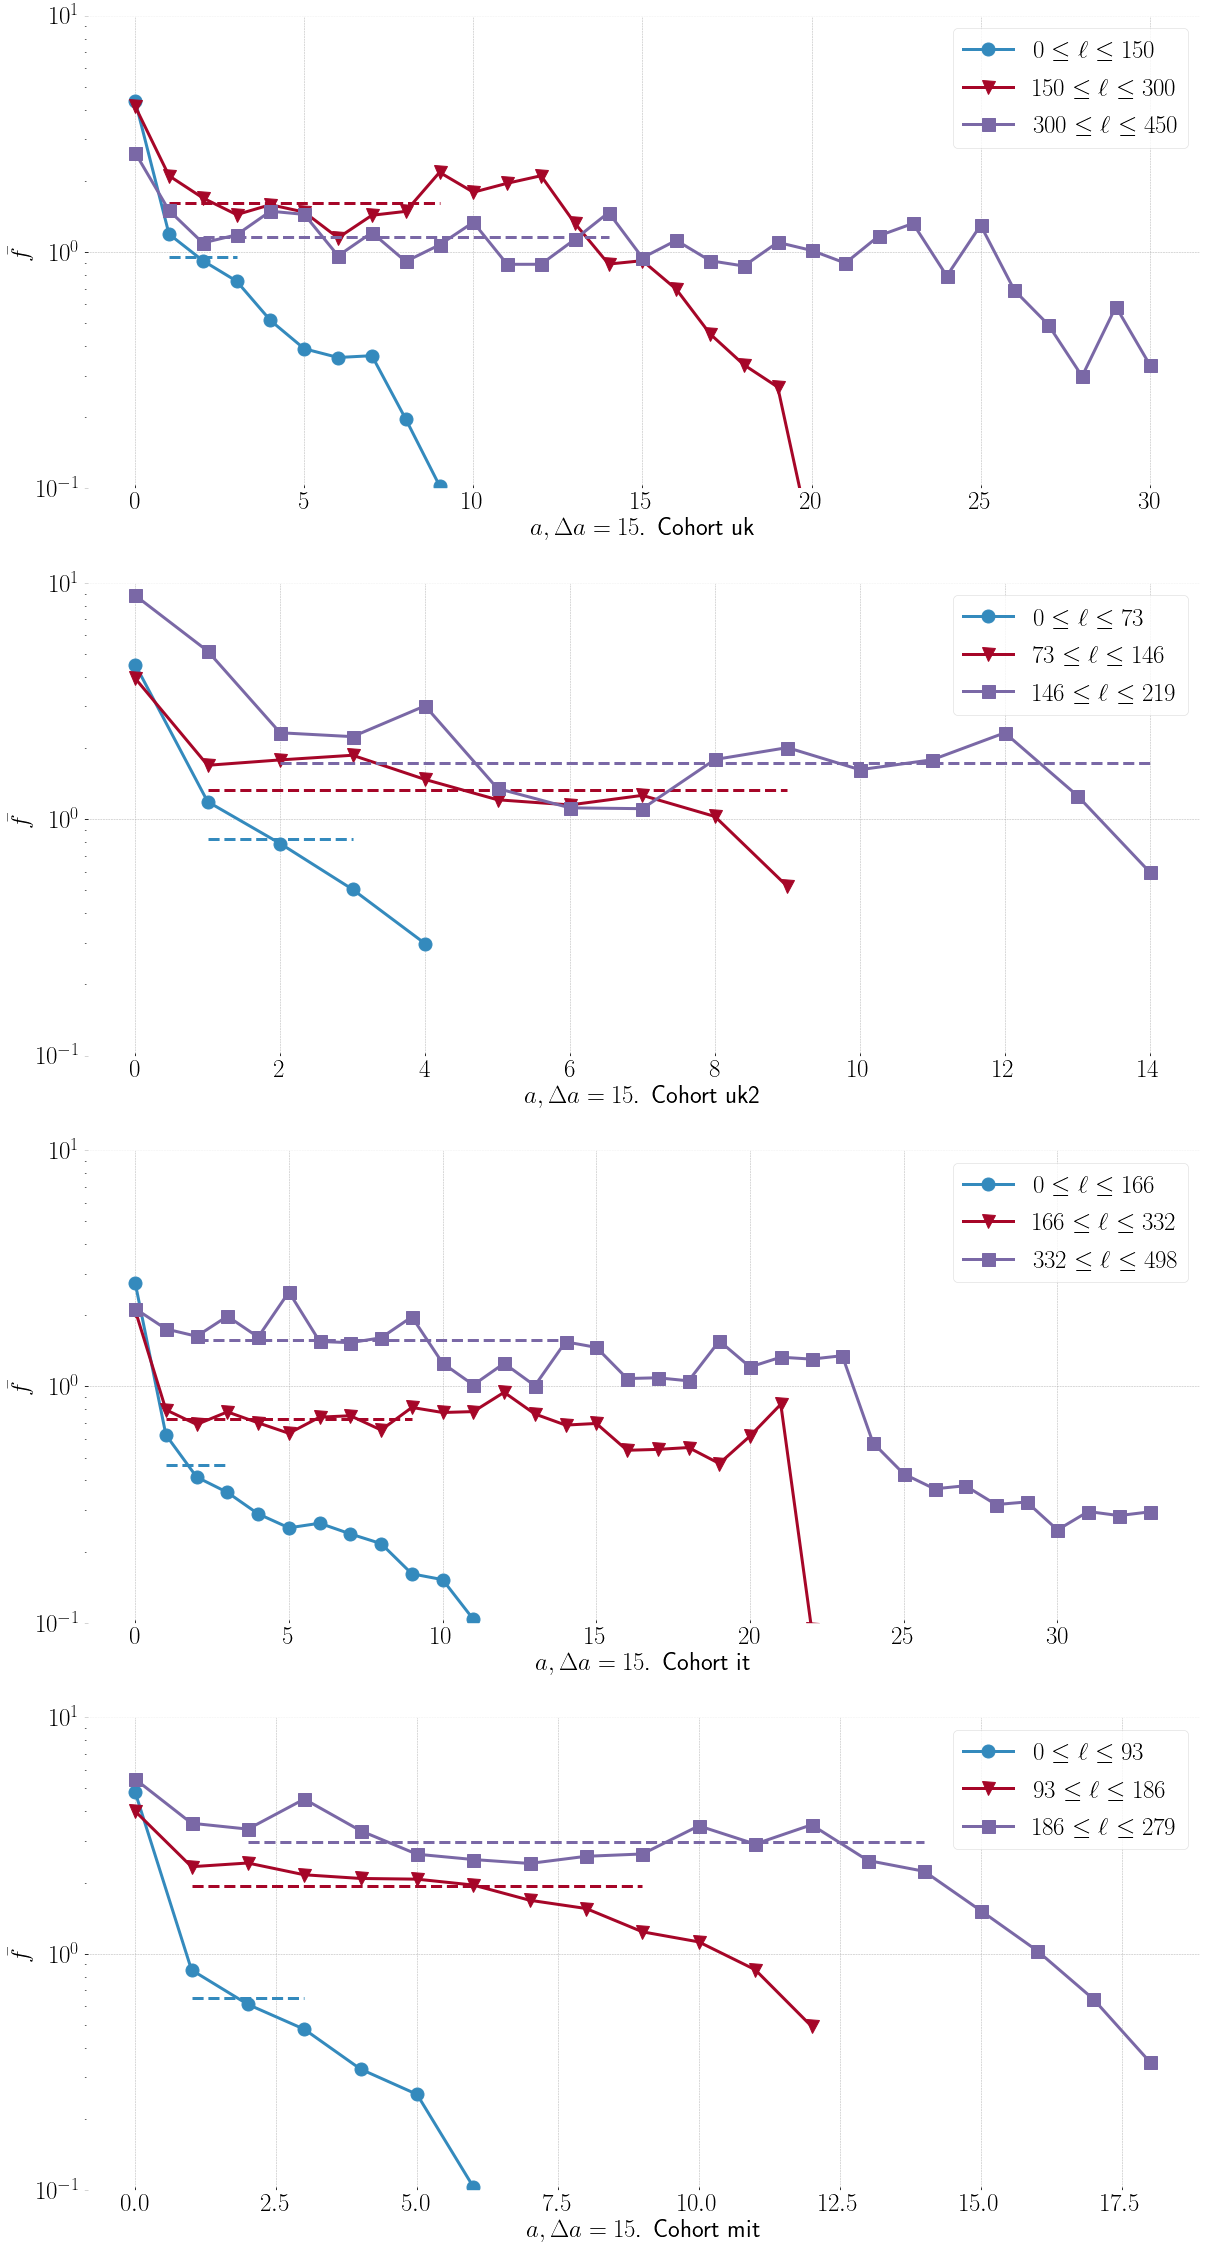

In [66]:
plt.figure(figsize=(20*1, 10*4))
p = 1
for c in ['uk', 'uk2', 'it', 'mit']:
    plt.subplot(4, 1, p)
    plt.ylim(10**(-1), 10**1)
    plt.semilogy()
    plt.xlabel(fr'$a, \Delta a  = 15$. Cohort {c}')
    plt.ylabel(r'$\bar{f}$')
    for i in range(3):
        plt.plot(fa[c][i]['f'].index, fa[c][i]['f']['f'], marker=markers[i], ls="solid", lw=3, markersize=13, c=colors[i], label=fr'${limits[c][i][0]}\leq \ell \leq {limits[c][i][1]}$')
        plt.plot(dashed[c][i][0], dashed[c][i][1], marker="", ls="--", lw=3, c=colors[i])
    plt.legend()
    p += 1
# plt.savefig("/home/vsvh/Desktop/B.png", dpi=200, pad_inches=2)

## Fig 2b

In [4]:
limits = {}
limits[0] = (0, 50)
limits[1] = (100, 150)
limits[2] = (200, 250)

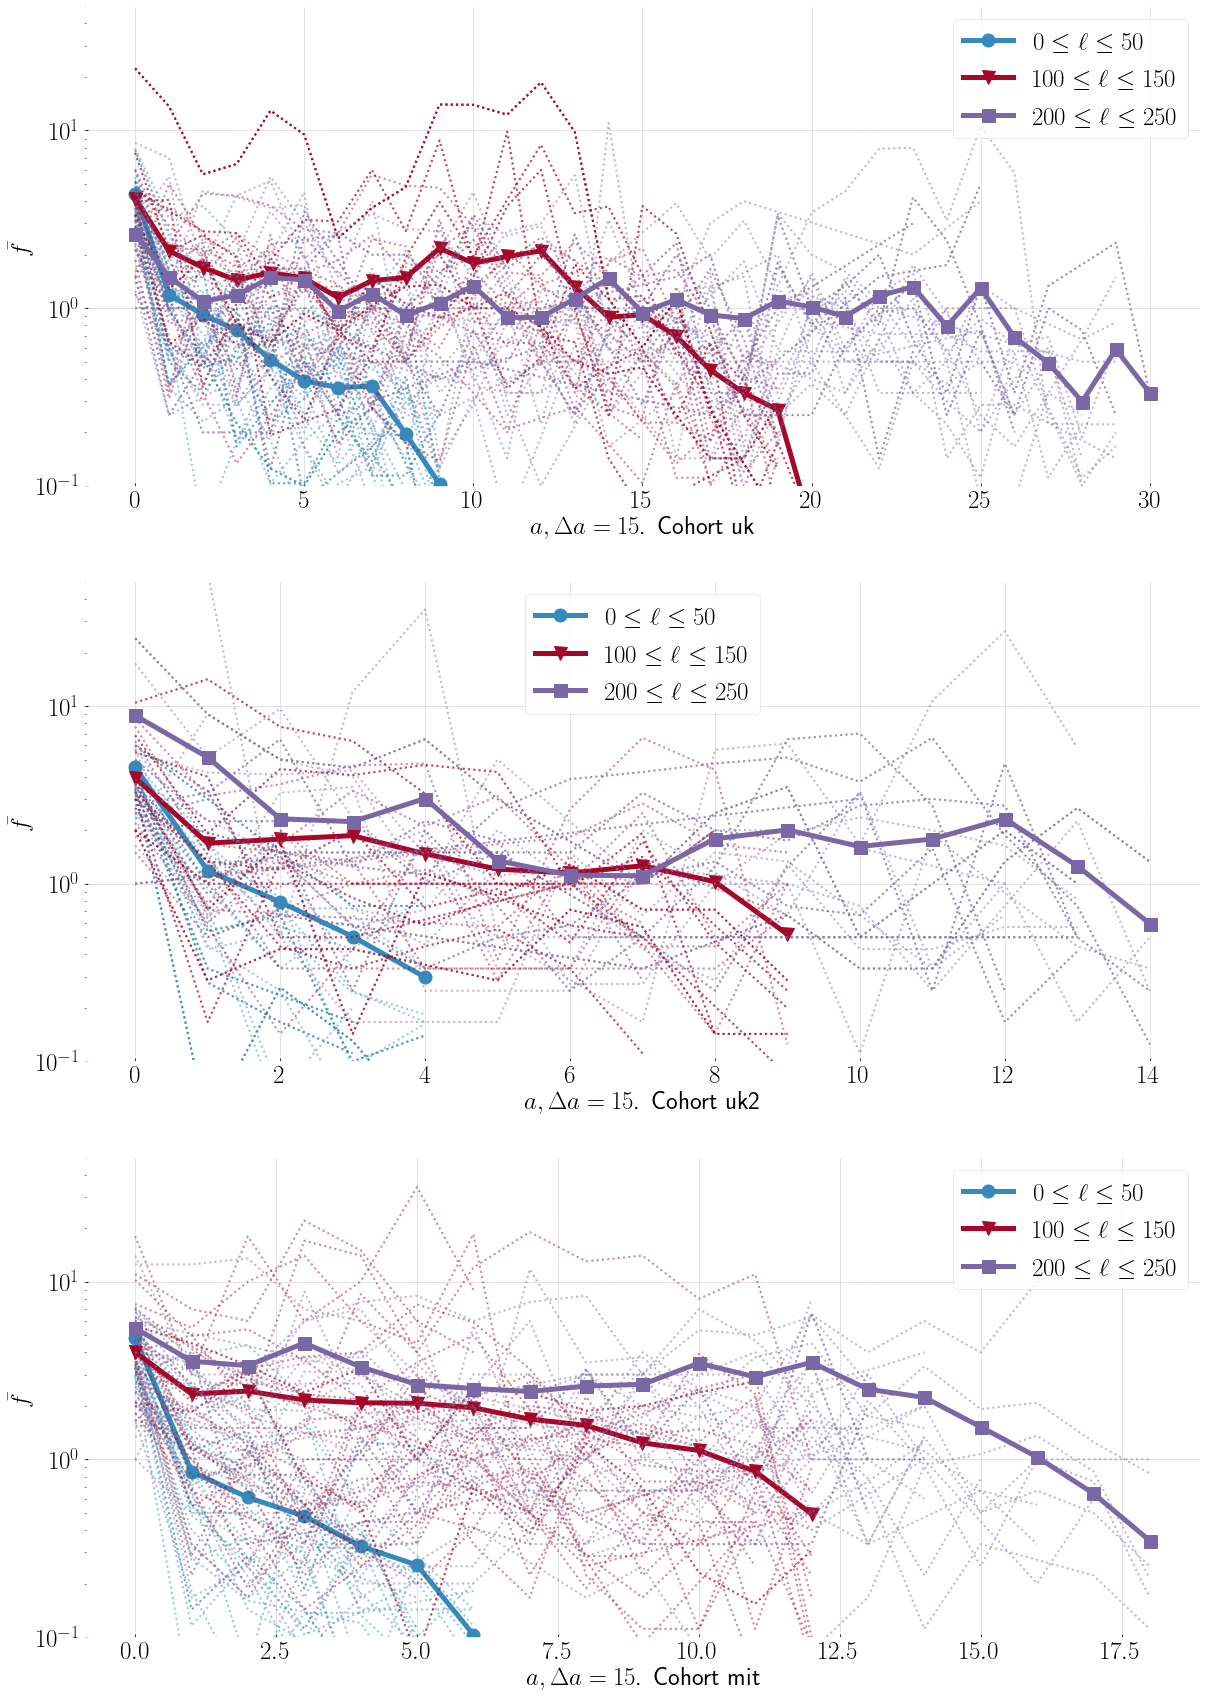

In [71]:
np.random.seed(0)
plt.figure(figsize=(20*1, 10*3))
p = 1
for c in ['uk', 'uk2', 'mit']:
    plt.subplot(3, 1, p)
    plt.ylim(10**(-1), 5*10**1)
    plt.semilogy()
    plt.xlabel(fr'$a, \Delta a  = 15$. Cohort {c}')
    plt.ylabel(r'$\bar{f}$')
    for i in limits.keys():
        plt.plot(fa[c][i]['f'].index, fa[c][i]['f']['f'], marker=markers[i], ls="solid", lw=5, markersize=13, c=colors[i], label=fr'${limits[i][0]}\leq \ell \leq {limits[i][1]}$')
        egos = np.random.choice(list(fa[c][i]['fi'].keys()), size=30)
        for e in egos:
            plt.plot(fa[c][i]['fi'][e].index, fa[c][i]['fi'][e]['f'], marker="", ls="dotted", lw=2, c=colors[i], alpha=0.5)
    plt.legend()
    p += 1
# plt.savefig("/home/vsvh/Desktop/A.png", dpi=200, pad_inches=2)

## Consistency between $f$ and $f_i$

In [72]:
a = {}
for i in limits.keys():
    a[i] = get_fal(calls['uk'], limits[i][0], limits[i][1], 5)

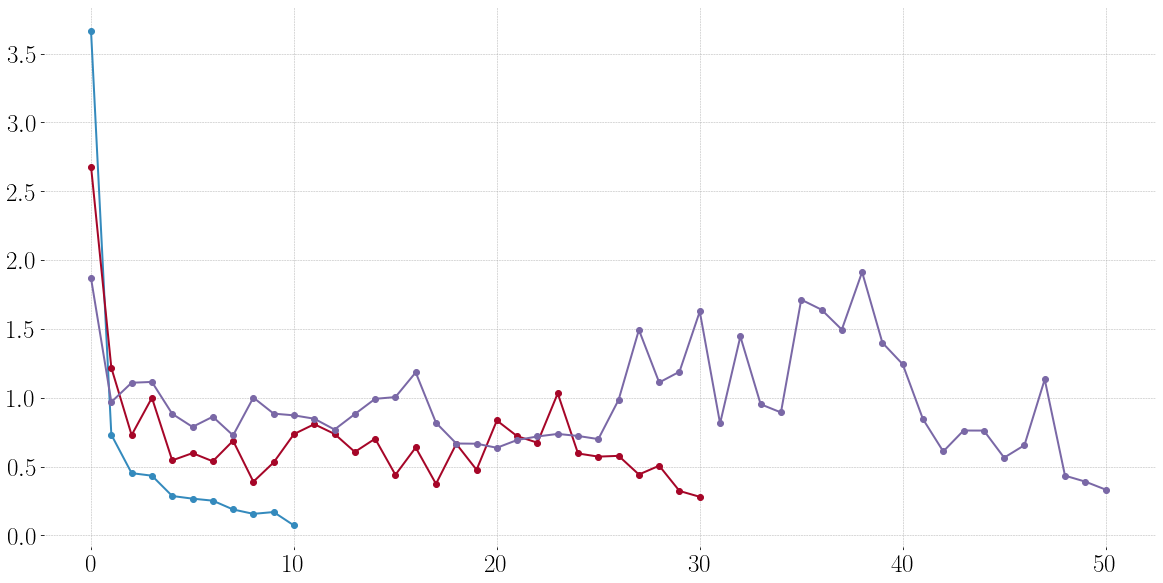

In [73]:
for i in a.keys():
    plt.plot(a[i]['f'].index, a[i]['f']['f'], "o-")

In [74]:
mediumlf = {}
for c in fa.keys():
    mediumlf[c] = {}
    df = fa[c][1]['f']
    dfl = df.loc[(df.index >= 1) & (df.index <= 5)]
    dfr = df.loc[(df.index >= 5) & (df.index <= 9)]
    dflr = df.loc[(df.index >= 1) & (df.index <= 9)]
    X = dflr.index
    X = sm.add_constant(X)
    Y = dflr['f']
    model = sm.OLS(Y, X).fit()
    mediumlf[c]['Slope'] = model.params[1]
    mediumlf[c]['avg'] = np.mean(dfl['f']) - np.mean(dfr['f'])
    mediumlf[c]['fi'] = []
    mediumlf[c]['fic'] = []
    mediumlf[c]['slopes'] = []
    for ego in fa[c][1]['fi'].keys():
        df = fa[c][1]['fi'][ego]
        dfl = df.loc[(df.index >= 1) & (df.index <= 5)]
        dfr = df.loc[(df.index >= 5) & (df.index <= 9)]
        dflr = df.loc[(df.index >= 1) & (df.index <= 9)]
        X = dflr.index
        X = sm.add_constant(X)
        Y = dflr['f']
        model = sm.OLS(Y, X).fit()
        if len(model.params) >= 2:
            mediumlf[c]['slopes'].append(model.params[1])
        if (not pd.isna(np.mean(dfl['f']))) and (not pd.isna(np.mean(dfr['f']))):
            mediumlf[c]['fi'].append(np.mean(dfl['f']) - np.mean(dfr['f']))
            mediumlf[c]['fic'].append(mediumlf[c]['fi'][-1] - mediumlf[c]['avg'])

ValueError: zero-size array to reduction operation maximum which has no identity

In [ ]:
longlf = {}
for c in fa.keys():
    longlf[c] = {}
    df = fa[c][2]['f']
    dfl = df.loc[(df.index >= 2) & (df.index <= 8)]
    dfr = df.loc[(df.index >= 8) & (df.index <= 14)]
    dflr = df.loc[(df.index >= 2) & (df.index <= 14)]
    X = dflr.index
    X = sm.add_constant(X)
    Y = dflr['f']
    model = sm.OLS(Y, X).fit()
    longlf[c]['Slope'] = model.params[1]
    longlf[c]['avg'] = np.mean(dfl['f']) - np.mean(dfr['f'])
    longlf[c]['fi'] = []
    longlf[c]['fic'] = []
    longlf[c]['slopes'] = []
    for ego in fa[c][2]['fi'].keys():
        df = fa[c][2]['fi'][ego]
        dfl = df.loc[(df.index >= 2) & (df.index <= 8)]
        dfr = df.loc[(df.index >= 8) & (df.index <= 14)]
        dflr = df.loc[(df.index >= 2) & (df.index <= 14)]
        if len(dflr) > 2:
            X = dflr.index
            X = sm.add_constant(X)
            Y = dflr['f']
            model = sm.OLS(Y, X).fit()
            if len(model.params) >= 2:
                longlf[c]['slopes'].append(model.params[1])
        if (not pd.isna(np.mean(dfl['f']))) and (not pd.isna(np.mean(dfr['f']))):
            longlf[c]['fi'].append(np.mean(dfl['f']) - np.mean(dfr['f']))
            longlf[c]['fic'].append(longlf[c]['fi'][-1] - longlf[c]['avg'])

In [ ]:
plt.figure(figsize=(20*2, 10*3))
p = 1
for c in ['uk', 'uk2', 'mit']:
    plt.subplot(3,2,p)
    plt.ylabel(r'$H(\Delta b_i - \Delta b)$')
    plt.xlabel(fr'$\Delta b_i - \Delta b$. Cohort {c}, Middle lifetime')
    plt.xlim(-3, 15)
    H = pc.histogram(mediumlf[c]['fic'], 10, log=False)
    dx = (max(H['label']) - min(H['label'])) / 10
    plt.bar(H['label'], H['pmf'], width=dx)
    diagy = [y / 10 for y in range(0, 7)]
    diagx = [((x * (1 - 9)) / 2) - mediumlf[c]['avg'] for x in diagy]
    plt.plot(diagx, diagy, "--", c="black", lw=3)
    plt.plot([x * -1 for x in diagx], diagy, "--", c="black", lw=3)
    p += 1
    
    plt.subplot(3,2,p)
    plt.ylabel(r'$H(\Delta b_i - \Delta b)$')
    plt.xlabel(fr'$\Delta b_i - \Delta b$. Cohort {c}, Long lifetime')
    plt.xlim(-12, 10)
    H = pc.histogram(longlf[c]['fic'], 10, log=False)
    dx = (max(H['label']) - min(H['label'])) / 10
    plt.bar(H['label'], H['pmf'], width=dx)
    diagy = [y / 10 for y in range(0, 7)]
    diagx = [((x * (2 - 14)) / 2) - longlf[c]['avg'] for x in diagy]
    plt.plot(diagx, diagy, "--", c="black", lw=3)
    plt.plot([x * -1 for x in diagx], diagy, "--", c="black", lw=3)
    p += 1
# plt.savefig("/home/vsvh/Desktop/A.png", dpi=150, pad_inches=2)

In [ ]:
plt.figure(figsize=(20*2, 10*3))
p = 1
for c in ['uk', 'uk2', 'mit']:
    plt.subplot(3, 2, p)
    plt.xlabel(f'Slope for cohort {c}. Middle lifetime')
    plt.xlim(-4, 6)
    H = pc.histogram(mediumlf[c]['slopes'], 10, log=False)
    plt.plot(H['label'], H['pmf'], marker="o", markersize=13, ls="dashed", lw=3)
    plt.axvline(mediumlf[c]['Slope'], c="black", ls="solid", lw=4)
    p += 1
    
    plt.subplot(3, 2, p)
    plt.xlabel(f'Slope for cohort {c}. Long lifetime')
    plt.xlim(-1.7, 1.2)
    H = pc.histogram(longlf[c]['slopes'], 10, log=False)
    plt.plot(H['label'], H['pmf'], marker="o", markersize=13, ls="dashed", lw=3)
    plt.axvline(longlf[c]['Slope'], c="black", ls="solid", lw=4)
    p += 1
#plt.savefig("/home/vsvh/Desktop/B.png", dpi=150, pad_inches=3)

## Another check for ecological fallacy

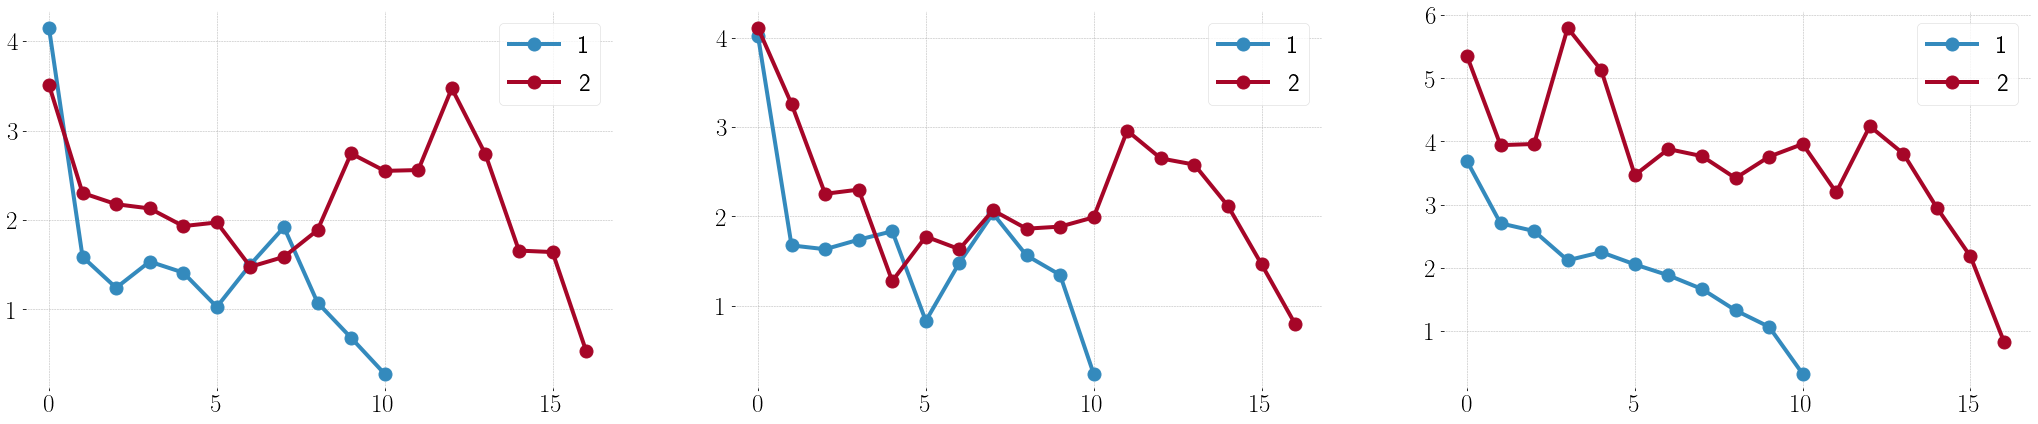

In [10]:
tmp = {}
for c in ['uk', 'uk2', 'mit']:
    tmp[c] = {}
    for i in [1, 2]:
        tmp[c][i] = pc.get_fal(pc.apply_filters(unfiltered[c], 60), limits[i][0], limits[i][1], 15)
        
plt.figure(figsize=(12*3, 7*1))
p = 1
for c in tmp.keys():
    plt.subplot(1,3,p)
    for i in tmp[c].keys():
        plt.plot(tmp[c][i]['f'].index, tmp[c][i]['f']['f'], "o-", markersize=13, lw=4, label=i)
    plt.legend()
    p += 1

In [6]:
a = {}
a[15] = {}
a[15][1] = (1, 5, 9)
a[15][2] = (2, 8, 14)
a[10] = {}
a[10][1] = (1, 7, 13)
a[10][2] = (2, 12, 22)
a[7] = {}
a[7][1] = (1, 10, 19)
a[7][2] = (2, 17, 32)
a[5] = {}
a[5][1] = (2, 15, 28)
a[5][2] = (2, 23, 44)
a[3] = {}
a[3][1] = (4, 25, 46)
a[3][2] = (2, 40, 78)

In [8]:
ksp = {}
for c in ['uk', 'uk2', 'mit']:
    ksp[c] = {}
    for Da in a.keys():
        ksp[c][Da] = {}
        series = pc.get_fal(pc.apply_filters(unfiltered[c], 60), limits[1][0], limits[1][1], Da)
        for ego in series['fi'].keys():
            df = series['fi'][ego]
            left = df.loc[(df.index >= a[Da][1][0]) & (df.index <= a[Da][1][1])]
            right = df.loc[(df.index >= a[Da][1][1]) & (df.index <= a[Da][1][2])]
            if (len(left) >= 1) and (len(right) >= 1):
                ksp[c][Da]['m'] = ksp[c][Da].get('m', [])
                ksp[c][Da]['m'].append(stats.ks_2samp(left['f'], right['f'])[1])
        series = pc.get_fal(pc.apply_filters(unfiltered[c], 60), limits[2][0], limits[2][1], Da)
        for ego in series['fi'].keys():
            df = series['fi'][ego]
            left = df.loc[(df.index >= a[Da][2][0]) & (df.index <= a[Da][2][1])]
            right = df.loc[(df.index >= a[Da][2][1]) & (df.index <= a[Da][2][2])]
            if (len(left) >= 1) and (len(right) >= 1):
                ksp[c][Da]['l'] = ksp[c][Da].get('l', [])
                ksp[c][Da]['l'].append(stats.ks_2samp(left['f'], right['f'])[1])

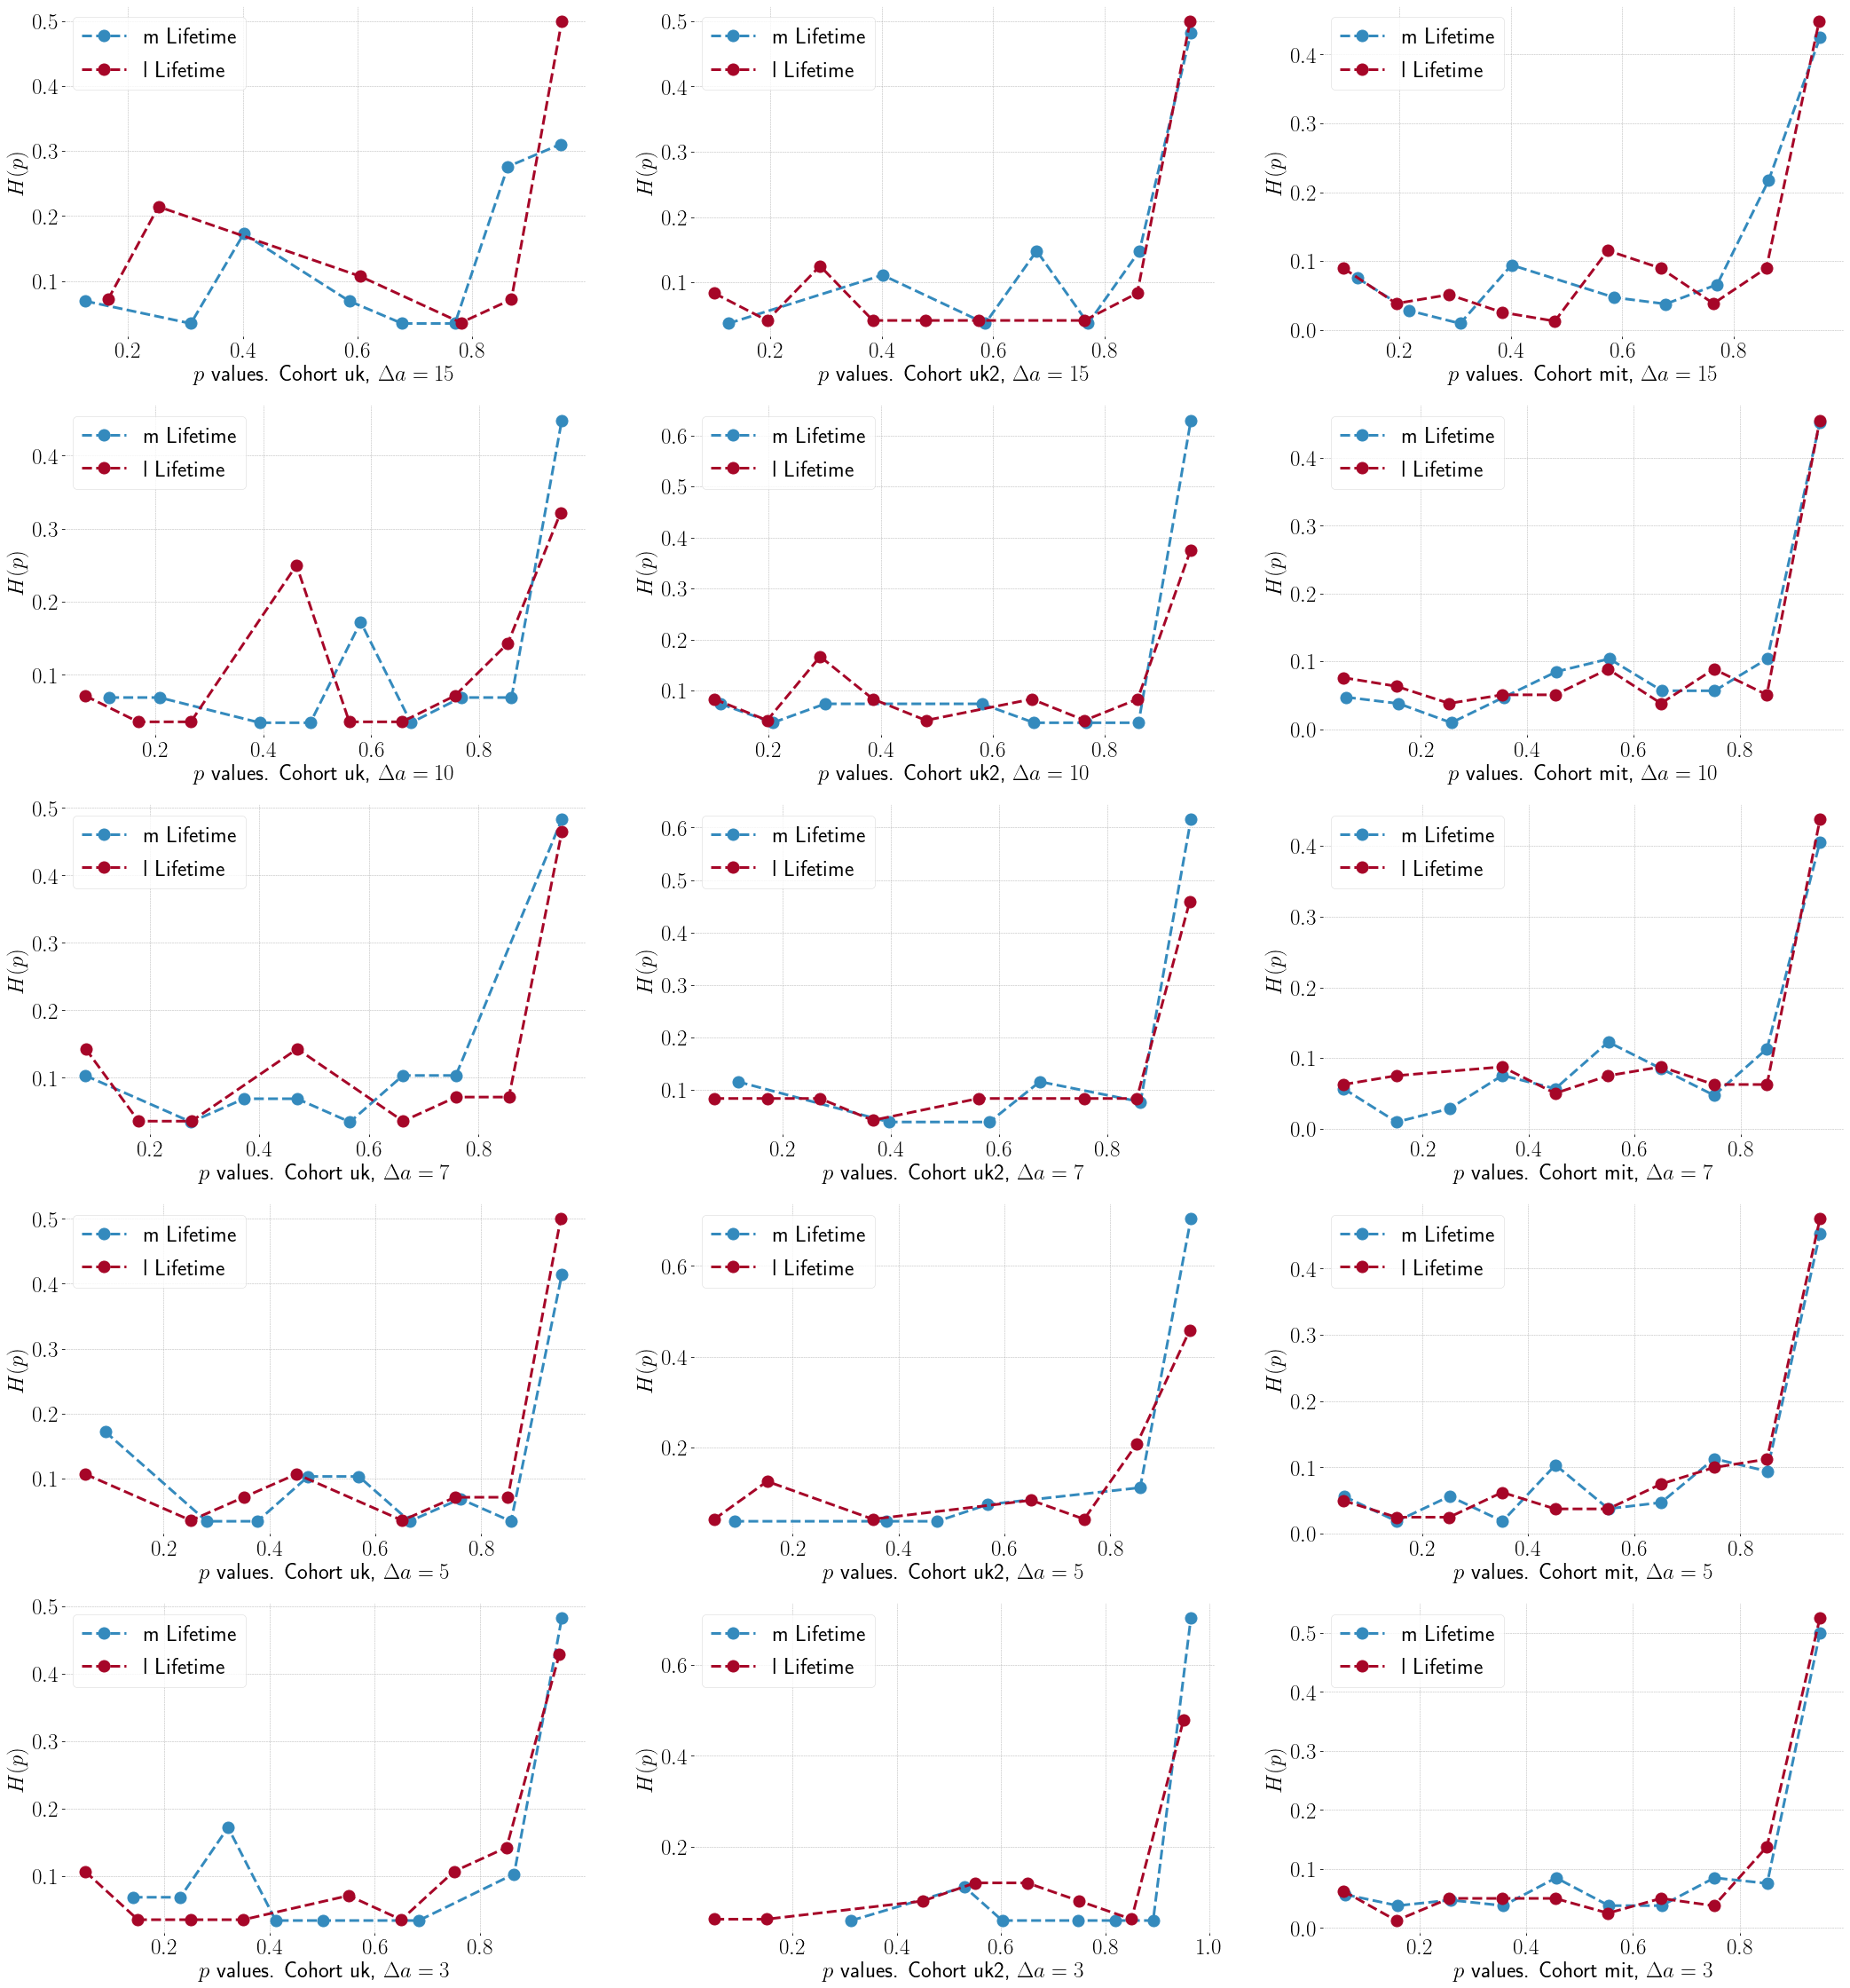

In [9]:
plt.figure(figsize=(12*3, 8*5))
p = 1
for Da in a.keys():
    for c in ksp.keys():
        plt.subplot(5, 3, p)
        plt.xlabel(fr"$p$ values. Cohort {c}, $\Delta a = {Da}$")
        plt.ylabel(r'$H(p)$')
        for s in ['m', 'l']:
            H = pc.histogram(ksp[c][Da][s], 10, log=False)
            plt.plot(H['label'], H['pmf'], marker=markers[0], markersize=13, ls="dashed", lw=3, label=f"{s} Lifetime")
        plt.legend()
        p += 1

In [ ]:
ksp2 = {}
for c in ['uk', 'uk2', 'mit']:
    ksp2[c] = {}
    for Da in a.keys():
        ksp2[c][Da] = {}
        series = get_fal(calls[c], limits[1][0], limits[1][1], Da)
        for ego in series['fi'].keys():
            df = series['fi'][ego]
            left = df.loc[(df.index >= a[Da][1][0]) & (df.index <= a[Da][1][1])]
            right = df.loc[(df.index >= a[Da][1][1]) & (df.index <= a[Da][1][2])]
            if (len(left) >= 1) and (len(right) >= 1):
                hl = pc.histogram(left['f'], 10, log=False)
                hr = pc.histogram(right['f'], 10, log=False)
                ksp2[c][Da]['m'] = ksp2[c][Da].get('m', [])
                ksp2[c][Da]['m'].append(stats.ks_2samp(hl['pmf'], hl['pmf'])[1])
        series = get_fal(calls[c], limits[2][0], limits[2][1], Da)
        for ego in series['fi'].keys():
            df = series['fi'][ego]
            left = df.loc[(df.index >= a[Da][2][0]) & (df.index <= a[Da][2][1])]
            right = df.loc[(df.index >= a[Da][2][1]) & (df.index <= a[Da][2][2])]
            if (len(left) >= 1) and (len(right) >= 1):
                hl = pc.histogram(left['f'], 10, log=False)
                hr = pc.histogram(right['f'], 10, log=False)
                ksp2[c][Da]['l'] = ksp2[c][Da].get('l', [])
                ksp2[c][Da]['l'].append(stats.ks_2samp(hl['pmf'], hr['pmf'])[1])

In [ ]:
plt.figure(figsize=(12*3, 8*5))
p = 1
for Da in a.keys():
    for c in ksp2.keys():
        plt.subplot(5, 3, p)
        plt.xlabel(fr"$p$ values. Cohort {c}, $\Delta a = {Da}$")
        plt.ylabel(r'$H(p)$')
        for s in ['m', 'l']:
            H = pc.histogram(ksp2[c][Da][s], 10, log=False)
            plt.plot(H['label'], H['pmf'], marker=markers[0], markersize=13, ls="dashed", lw=3, label=f"{s} Lifetime")
        plt.legend()
        p += 1

## Fig 3

For now, I will construct this figure only using UK and USA. I need to include Italian data once I have it.

In [ ]:
def get_survival(fresult, alphafixed=1, base=2, unbinned=False, lambdamax=999):
    '''
    This function takes as an input an "f dataframe"; and returns a dictionary that uses
    the gamma bins of activity during month "alphafixed" as keys, and the survival probabilities
    of alters as the values, in a dataframe. For each value of ell*, there are survival
    probabilities. The arguments are:
    fresult             : dataframe created using the get_f method
    alphafixed          : which bin of a I'm interested in using
    base                : the base for the "exponential binning"
    unbinned            : do not create bins of activity, use only the actual value. By
                          default, this is set to False
    '''
    tmp = {}
    for ego in fresult.keys():
        for alter in fresult[ego].keys():
            if type(alphafixed) == int:
                df = fresult[ego][alter].loc[fresult[ego][alter]['alpha'] == alphafixed]
            else:
                df = fresult[ego][alter].loc[(fresult[ego][alter]['alpha'] >= alphafixed[0]) & (fresult[ego][alter]['alpha'] <= alphafixed[1])]
            if len(df) > 0:
                if unbinned:
                    F = sum(df['f'])
                else:
                    F = int(math.log(sum(df['f']), base))
                lamb = df.iloc[0]['lambda']
                if lamb <= lambdamax:
                    tmp[F] = tmp.get(F, {})
                    tmp[F][lamb] = tmp[F].get(lamb, 0) + 1
    tmp2 = {}
    for F in sorted(tmp.keys()):
        df = pd.DataFrame.from_dict(tmp[F], orient='index').sort_index()
        tmp2[F] = {}
        df['p'] = df[0].div(sum(df[0]))
        for lc in range(max(df.index) + 1):
            df2 = df.loc[df.index >= lc]
            tmp2[F][lc] = round(sum(df2['p']), 6)
        tmp2[F] = pd.DataFrame.from_dict(tmp2[F], orient='index').sort_index()
    return tmp2

In [ ]:
dff = {}
dff['all'] = {}
for c in calls.keys():
    dff[c] = pc.get_f(calls[c], 'all', 30, 10)
    dff['all'].update(dff[c])

In [ ]:
survival = {}
for c in dff.keys():
    survival[c] = get_survival(dff[c], lambdamax=25)

In [ ]:
plt.figure(figsize=(12*2, 8*2))
p = 1
for c in ['all', 'mit', 'uk', 'uk2']:
    plt.subplot(2,2,p)
    plt.xlabel(fr"$\ell$ Cohort {c}")
    plt.ylabel(r"$P$")
    for i in range(6):
        plt.plot(survival[c][i].index, survival[c][i][0], marker=markers[i], markersize=13, ls="dashed", lw=3, label=fr'$\gamma = {i}$')
    plt.legend()
    p += 1
#plt.savefig("/home/vsvh/Desktop/C.png", dpi=200, pad_inches=2)

## Fig 4

# Global Time

In [ ]:
globaltf = dt.datetime.now() - globalt0
print(f'This notebook took {globaltf}')
os.system(f"notify-send 'Notebook done' 'it took {globaltf}'")